In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import json

import os
import math
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm


from sklearn.neighbors import KernelDensity 
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate


import xgboost
from xgboost import XGBRegressor, XGBClassifier

from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import seaborn as sns

def create_cyan_to_black_cmap(color1, color2, cmap_name = 'cyan_to_black'):
    colors = [color1, color2]
    return LinearSegmentedColormap.from_list(cmap_name, colors)

# Create the colormap
NP_cmap = create_cyan_to_black_cmap('black', mcolors.to_rgb('darkcyan'), cmap_name = 'NP_cmap')
SM_cmap = create_cyan_to_black_cmap(mcolors.to_rgb('coral'), 'black', cmap_name = 'SM_cmap')

In [3]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import XG, KDE_fitter, max_num_bins
from AUX_MLL_BL import Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve

In [4]:
import matplotlib as mpl
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 

In [5]:
BPs2plot = [2,5,8,11,14]
cmap = cm.get_cmap('Blues', 18)
#cmap = ['coral']
wjets_color = 'coral'
wgamma_color = 'red'
ttgamma_color = 'purple'

# custom functions

In [6]:
def MLL_aprox_discovery_ox(pred_XG_SM, pred_XG_NP, B_expected, S_expected):
   
    pspb_B_data = np.median([im / (1 - im) for im in pred_XG_SM])
    pspb_S_data = np.median([im / (1 - im) for im in pred_XG_NP])
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5



def MLL_aprox_discovery_KDE(pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, S_expected):
   
    pspb_B_data = np.median(pS_B_data/pB_B_data)
    pspb_S_data = np.median(pS_S_data/pB_S_data)
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5


# Reading the data

## SM

In [7]:
ttgamma_cross = 0.13 * 1000 #[fb]
ttgamma_NLO   = 1.46 # k-factor [14 TeV]

Wgamma_cross = 0.944 * 1000 #[fb]
Wgamma_NLO   = 2.37 # k-factor [14 TeV]

Wjets_cross = 168.12 * 1000 #[fb]
Wjets_NLO   = 1.27 # k-factor [14 TeV]

ttjets_cross = 29.0495 * 1000 # [fb]
ttjets_NLO   = 1.47

zjets_cross = 65.85 * 1000 # [fb] solo rama leptonica
zjets_NLO   = 1.35

wz_cross = 0.90 * 1000 # [fb]
wz_NLO   = 1.62

zz_cross = 0.2616 * 1000
zz_NLO   = 1.29

ww_cross = 0.409 * 1000
ww_NLO   = 1.40

tj_cross = 1.598 * 1000
tj_NLO   = 1.03

tb_cross = 2.882 * 1000
tb_NLO   = 1.34

tw_cross = 1.441 * 1000
tw_NLO   = 1.

In [8]:
Wgamma_fidcross  = 584.6234
Wjets_fidcross   = 600.5788
ttgamma_fidcross = 24.98413

ttjets_fidcross  = 180.510721
zjets_fidcross   = 33.609922
wz_fidcross      = 6.740334
zz_fidcross      = 0.843997
ww_fidcross      = 15.8203
tj_fidcross      = 7.9070
tb_fidcross      = 11.52578
tw_fidcross      = 12.72042

B_fidcross_tot   = Wgamma_fidcross + Wjets_fidcross + ttgamma_fidcross + \
                   ttjets_fidcross + zjets_fidcross + wz_fidcross  + \
                   zz_fidcross + ww_fidcross + tj_fidcross + \
                   tb_fidcross + tw_fidcross 
B_fidcross_tot

1479.8648040000003

In [9]:
Wgamma_aceptancia_init  = Wgamma_fidcross / (Wgamma_cross * Wgamma_NLO)
Wjets_aceptancia_init   = Wjets_fidcross / (Wjets_cross * Wjets_NLO)
ttgamma_aceptancia_init = ttgamma_fidcross / (ttgamma_cross * ttgamma_NLO)
ttjets_aceptancia_init  = ttjets_fidcross / (ttjets_cross * ttjets_NLO)
zjets_aceptancia_init   = zjets_fidcross / (zjets_cross * zjets_NLO)
wz_aceptancia_init      = wz_fidcross / (wz_cross * wz_NLO)
zz_aceptancia_init      = zz_fidcross / (zz_cross * zz_NLO)
ww_aceptancia_init      = ww_fidcross / (ww_cross * ww_NLO)
tj_aceptancia_init      = tj_fidcross / (tj_cross * tj_NLO)
tb_aceptancia_init      = tb_fidcross / (tb_cross * tb_NLO)
tw_aceptancia_init      = tw_fidcross / (tw_cross * tw_NLO)

In [10]:
Wgamma_expected  = 58462.34
Wjets_expected   = 60057.88
ttgamma_expected = 2498.413

ttjets_expected  = 18051.0721
zjets_expected   = 3360.9922
wz_expected      = 674.0334
zz_expected      = 84.3997
ww_expected      = 1582.03
tj_expected      = 790.70
tb_expected      = 1152.578
tw_expected      = 1272.042

B_expected = ttgamma_expected + Wjets_expected + Wgamma_expected + ttjets_expected + \
             zjets_expected + wz_expected + zz_expected + ww_expected + \
             tj_expected + tb_expected + tw_expected

print(B_expected)

147986.4804


In [11]:
sample = 200_000 # Number of signal and background events to train and validate

Wgamma_sample  = int(round(sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_sample   = int(round(sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_sample = int(round(sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_sample = int(round(sample * ttjets_fidcross / B_fidcross_tot))
zjets_sample = int(round(sample * zjets_fidcross / B_fidcross_tot))
wz_sample = int(round(sample * wz_fidcross / B_fidcross_tot))
zz_sample = int(round(sample * zz_fidcross / B_fidcross_tot))
ww_sample = int(round(sample * ww_fidcross / B_fidcross_tot))
tj_sample = int(round(sample * tj_fidcross / B_fidcross_tot))
tb_sample = int(round(sample * tb_fidcross / B_fidcross_tot))
tw_sample = int(round(sample * tw_fidcross / B_fidcross_tot))

print(Wgamma_sample)
print(Wjets_sample)
print(ttgamma_sample)
print(ttjets_sample)
print(zjets_sample)
print(wz_sample)
print(zz_sample)
print(ww_sample)
print(tj_sample)
print(tb_sample)
print(tw_sample)

79010
81167
3377
24396
4542
911
114
2138
1069
1558
1719


In [12]:
##############
# input data #
##############

# photon -> (pT, eta, phi, num_photon) from the leading photon
# jet -> (pT, eta, phi) from the leading jet
# lepton -> (pT, eta, phi, num_leptons, num_taus) from the lepton (electron or muon)
# MET -> (pT, eta, phi) eta = 0 by construction, but phi is important because we have a lot of jets that we do not use
# hadinfo -> (HT, HT_had, num_jets)  HT: sum of Pt of all partciles, HT_had: sum PT of all the jets, number of jets (b-tag or not)


######
# SM #
######

# W gamma + W gamma jet #
# Dominant # Np es el W jet el dominant??

datFolderWgamma = '../data/Wgamma/'

photon_Wgamma  = np.loadtxt(datFolderWgamma + 'photon_4.dat', delimiter=' ')
jet_Wgamma     = np.loadtxt(datFolderWgamma + 'jet_4.dat', delimiter=' ')
lepton_Wgamma  = np.loadtxt(datFolderWgamma + 'lepton_4.dat', delimiter=' ')
MET_Wgamma     = np.loadtxt(datFolderWgamma + 'MET_4.dat', delimiter=' ')
hadinfo_Wgamma = np.loadtxt(datFolderWgamma + 'hadinfo_4.dat', delimiter=' ')


# W jet + W jet jet #

datFolderWjets = '../data/Wjets/'

photon_Wjets  = np.loadtxt(datFolderWjets + 'photon_4.dat', delimiter=' ')
jet_Wjets     = np.loadtxt(datFolderWjets + 'jet_4.dat', delimiter=' ')
lepton_Wjets  = np.loadtxt(datFolderWjets + 'lepton_4.dat', delimiter=' ')
MET_Wjets     = np.loadtxt(datFolderWjets + 'MET_4.dat', delimiter=' ')
hadinfo_Wjets = np.loadtxt(datFolderWjets + 'hadinfo_4.dat', delimiter=' ')


# tt gamma + tt gamma jet #

datFolderttgamma = '../data/ttGamma/'
 
photon_ttgamma  = np.loadtxt(datFolderttgamma + 'photon_4.dat', delimiter=' ')
jet_ttgamma     = np.loadtxt(datFolderttgamma + 'jet_4.dat', delimiter=' ')
lepton_ttgamma  = np.loadtxt(datFolderttgamma + 'lepton_4.dat', delimiter=' ')
MET_ttgamma     = np.loadtxt(datFolderttgamma + 'MET_4.dat', delimiter=' ')
hadinfo_ttgamma = np.loadtxt(datFolderttgamma + 'hadinfo_4.dat', delimiter=' ')

# tt  jet #

datFolderttjets = '../data/ttjets/'
 
photon_ttjets  = np.loadtxt(datFolderttjets + 'photon_4.dat', delimiter=' ')
jet_ttjets     = np.loadtxt(datFolderttjets + 'jet_4.dat', delimiter=' ')
lepton_ttjets  = np.loadtxt(datFolderttjets + 'lepton_4.dat', delimiter=' ')
MET_ttjets     = np.loadtxt(datFolderttjets + 'MET_4.dat', delimiter=' ')
hadinfo_ttjets = np.loadtxt(datFolderttjets + 'hadinfo_4.dat', delimiter=' ')

# z jet # rama leptonica

datFolderzjets = '../data/Zlep+j/'
 
photon_zjets  = np.loadtxt(datFolderzjets + 'photon_4.dat', delimiter=' ')
jet_zjets     = np.loadtxt(datFolderzjets + 'jet_4.dat', delimiter=' ')
lepton_zjets  = np.loadtxt(datFolderzjets + 'lepton_4.dat', delimiter=' ')
MET_zjets     = np.loadtxt(datFolderzjets + 'MET_4.dat', delimiter=' ')
hadinfo_zjets = np.loadtxt(datFolderzjets + 'hadinfo_4.dat', delimiter=' ')

# wz #

datFolderwz = '../data/wz/'
 
photon_wz  = np.loadtxt(datFolderwz + 'photon_4.dat', delimiter=' ')
jet_wz     = np.loadtxt(datFolderwz + 'jet_4.dat', delimiter=' ')
lepton_wz  = np.loadtxt(datFolderwz + 'lepton_4.dat', delimiter=' ')
MET_wz     = np.loadtxt(datFolderwz + 'MET_4.dat', delimiter=' ')
hadinfo_wz = np.loadtxt(datFolderwz + 'hadinfo_4.dat', delimiter=' ')

# ww #

datFolderww = '../data/ww/'
 
photon_ww  = np.loadtxt(datFolderww + 'photon_4.dat', delimiter=' ')
jet_ww     = np.loadtxt(datFolderww + 'jet_4.dat', delimiter=' ')
lepton_ww  = np.loadtxt(datFolderww + 'lepton_4.dat', delimiter=' ')
MET_ww     = np.loadtxt(datFolderww + 'MET_4.dat', delimiter=' ')
hadinfo_ww = np.loadtxt(datFolderww + 'hadinfo_4.dat', delimiter=' ')

# zz #

datFolderzz = '../data/zz/'
 
photon_zz  = np.loadtxt(datFolderzz + 'photon_4.dat', delimiter=' ')
jet_zz     = np.loadtxt(datFolderzz + 'jet_4.dat', delimiter=' ')
lepton_zz  = np.loadtxt(datFolderzz + 'lepton_4.dat', delimiter=' ')
MET_zz     = np.loadtxt(datFolderzz + 'MET_4.dat', delimiter=' ')
hadinfo_zz = np.loadtxt(datFolderzz + 'hadinfo_4.dat', delimiter=' ')

# tj #

datFoldertj = '../data/singleTop+j/'
 
photon_tj  = np.loadtxt(datFoldertj + 'photon_4.dat', delimiter=' ')
jet_tj     = np.loadtxt(datFoldertj + 'jet_4.dat', delimiter=' ')
lepton_tj  = np.loadtxt(datFoldertj + 'lepton_4.dat', delimiter=' ')
MET_tj     = np.loadtxt(datFoldertj + 'MET_4.dat', delimiter=' ')
hadinfo_tj = np.loadtxt(datFoldertj + 'hadinfo_4.dat', delimiter=' ')

# tb #

datFoldertb = '../data/singleTop+b/'
 
photon_tb  = np.loadtxt(datFoldertb + 'photon_4.dat', delimiter=' ')
jet_tb     = np.loadtxt(datFoldertb + 'jet_4.dat', delimiter=' ')
lepton_tb  = np.loadtxt(datFoldertb + 'lepton_4.dat', delimiter=' ')
MET_tb     = np.loadtxt(datFoldertb + 'MET_4.dat', delimiter=' ')
hadinfo_tb = np.loadtxt(datFoldertb + 'hadinfo_4.dat', delimiter=' ')

# tw #

datFoldertw = '../data/singleTop+W/'
 
photon_tw  = np.loadtxt(datFoldertw + 'photon_4.dat', delimiter=' ')
jet_tw     = np.loadtxt(datFoldertw + 'jet_4.dat', delimiter=' ')
lepton_tw  = np.loadtxt(datFoldertw + 'lepton_4.dat', delimiter=' ')
MET_tw     = np.loadtxt(datFoldertw + 'MET_4.dat', delimiter=' ')
hadinfo_tw = np.loadtxt(datFoldertw + 'hadinfo_4.dat', delimiter=' ')

In [13]:
photon_SM  = np.concatenate([photon_Wgamma[:Wgamma_sample], photon_Wjets[:Wjets_sample], photon_ttgamma[:ttgamma_sample],
                             photon_ttjets[:ttjets_sample], photon_zjets[:zjets_sample], photon_wz[:wz_sample],
                             photon_zz[:zz_sample], photon_ww[:ww_sample], photon_tj[:tj_sample],
                             photon_tb[:tb_sample], photon_tw[:tw_sample]
                            ])
jet_SM     = np.concatenate([jet_Wgamma[:Wgamma_sample], jet_Wjets[:Wjets_sample], jet_ttgamma[:ttgamma_sample],
                             jet_ttjets[:ttjets_sample], jet_zjets[:zjets_sample], jet_wz[:wz_sample],
                             jet_zz[:zz_sample], jet_ww[:ww_sample], jet_tj[:tj_sample],
                             jet_tb[:tb_sample], jet_tw[:tw_sample]
                            ]) 
lepton_SM  = np.concatenate([lepton_Wgamma[:Wgamma_sample], lepton_Wjets[:Wjets_sample], lepton_ttgamma[:ttgamma_sample],
                             lepton_ttjets[:ttjets_sample], lepton_zjets[:zjets_sample], lepton_wz[:wz_sample],
                             lepton_zz[:zz_sample], lepton_ww[:ww_sample], lepton_tj[:tj_sample],
                             lepton_tb[:tb_sample], lepton_tw[:tw_sample]
                            ])
MET_SM     = np.concatenate([MET_Wgamma[:Wgamma_sample], MET_Wjets[:Wjets_sample], MET_ttgamma[:ttgamma_sample],
                             MET_ttjets[:ttjets_sample], MET_zjets[:zjets_sample], MET_wz[:wz_sample],
                             MET_zz[:zz_sample], MET_ww[:ww_sample], MET_tj[:tj_sample],
                             MET_tb[:tb_sample], MET_tw[:tw_sample]
                            ])
hadinfo_SM = np.concatenate([hadinfo_Wgamma[:Wgamma_sample], hadinfo_Wjets[:Wjets_sample], hadinfo_ttgamma[:ttgamma_sample],
                             hadinfo_ttjets[:ttjets_sample], hadinfo_zjets[:zjets_sample], hadinfo_wz[:wz_sample],
                             hadinfo_zz[:zz_sample], hadinfo_ww[:ww_sample], hadinfo_tj[:tj_sample],
                             hadinfo_tb[:tb_sample], hadinfo_tw[:tw_sample]
                            ])

In [14]:
bkg_flag = np.zeros(len(photon_SM))

bkg_flag[:Wgamma_sample] = 1

init_ind = Wgamma_sample
end_ind  = Wgamma_sample + Wjets_sample
bkg_flag[Wgamma_sample:(Wgamma_sample + Wjets_sample)] = 2

init_ind = end_ind
end_ind  = end_ind + ttgamma_sample
bkg_flag[(init_ind):(end_ind)] = 3

init_ind = end_ind
end_ind  = end_ind + ttjets_sample
bkg_flag[(init_ind):(end_ind)] = 4

init_ind = end_ind
end_ind  = end_ind + zjets_sample
bkg_flag[(init_ind):(end_ind)] = 5

init_ind = end_ind
end_ind  = end_ind + wz_sample
bkg_flag[(init_ind):(end_ind)] = 6

init_ind = end_ind
end_ind  = end_ind + zz_sample
bkg_flag[(init_ind):(end_ind)] = 7

init_ind = end_ind
end_ind  = end_ind + ww_sample
bkg_flag[(init_ind):(end_ind)] = 8

init_ind = end_ind
end_ind  = end_ind + tj_sample
bkg_flag[(init_ind):(end_ind)] = 9

init_ind = end_ind
end_ind  = end_ind + tb_sample
bkg_flag[(init_ind):(end_ind)] = 10

init_ind = end_ind
end_ind  = end_ind + tw_sample
bkg_flag[(init_ind):(end_ind)] = 11

In [15]:
wjets_pool  = len(photon_Wjets[Wjets_sample:])
pool_sample = int(wjets_pool * B_fidcross_tot / Wjets_fidcross)

Wgamma_pool_sample  = int(round(pool_sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_pool_sample   = int(round(pool_sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_pool_sample = int(round(pool_sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_pool_sample  = int(round(pool_sample * ttjets_fidcross / B_fidcross_tot))
zjets_pool_sample   = int(round(pool_sample * zjets_fidcross / B_fidcross_tot))
wz_pool_sample      = int(round(pool_sample * wz_fidcross / B_fidcross_tot))
zz_pool_sample      = int(round(pool_sample * zz_fidcross / B_fidcross_tot))
ww_pool_sample      = int(round(pool_sample * ww_fidcross / B_fidcross_tot))
tj_pool_sample      = int(round(pool_sample * tj_fidcross / B_fidcross_tot))
tb_pool_sample      = int(round(pool_sample * tb_fidcross / B_fidcross_tot))
tw_pool_sample      = int(round(pool_sample * tw_fidcross / B_fidcross_tot))

print(Wgamma_pool_sample)
print(Wjets_pool_sample)
print(ttgamma_pool_sample)
print(ttjets_pool_sample)
print(zjets_pool_sample)
print(wz_pool_sample)
print(zz_pool_sample)
print(ww_pool_sample)
print(tj_pool_sample)
print(tb_pool_sample)
print(tw_sample)

173444
178178
7412
53553
9971
2000
250
4694
2346
3419
1719


In [16]:
photon_SM_pool  = np.concatenate([photon_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  photon_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  photon_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  photon_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  photon_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  photon_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  photon_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  photon_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  photon_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  photon_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  photon_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])

jet_SM_pool     = np.concatenate([jet_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  jet_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  jet_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  jet_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  jet_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  jet_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  jet_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  jet_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  jet_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  jet_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  jet_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ]) 

lepton_SM_pool  = np.concatenate([lepton_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  lepton_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  lepton_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  lepton_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  lepton_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  lepton_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  lepton_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  lepton_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  lepton_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  lepton_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  lepton_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])

MET_SM_pool     = np.concatenate([MET_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  MET_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  MET_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  MET_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  MET_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  MET_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  MET_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  MET_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  MET_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  MET_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  MET_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])

hadinfo_SM_pool = np.concatenate([hadinfo_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  hadinfo_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  hadinfo_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  hadinfo_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  hadinfo_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  hadinfo_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  hadinfo_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  hadinfo_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  hadinfo_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  hadinfo_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  hadinfo_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])


In [17]:
bkg_flag_pool = np.zeros(len(photon_SM_pool))

bkg_flag_pool[:Wgamma_pool_sample] = 1

init_ind = Wgamma_pool_sample
end_ind  = Wgamma_pool_sample + Wjets_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 2

init_ind = end_ind
end_ind  = end_ind + ttgamma_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 3

init_ind = end_ind
end_ind  = end_ind + ttjets_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 4

init_ind = end_ind
end_ind  = end_ind + zjets_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 5

init_ind = end_ind
end_ind  = end_ind + wz_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 6

init_ind = end_ind
end_ind  = end_ind + zz_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 7

init_ind = end_ind
end_ind  = end_ind + ww_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 8

init_ind = end_ind
end_ind  = end_ind + tj_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 9

init_ind = end_ind
end_ind  = end_ind + tb_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 10

init_ind = end_ind
end_ind  = end_ind + tw_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 11

In [18]:
print(photon_Wjets.shape)
print(photon_ttgamma.shape)
print(photon_Wgamma.shape)
print(photon_ttjets.shape)
print(photon_zjets.shape)
print(photon_wz.shape)
print(photon_zz.shape)
print(photon_ww.shape)
print(photon_tj.shape)
print(photon_tb.shape)
print(photon_tw.shape)

(259345, 4)
(2710879, 4)
(3579946, 4)
(92997, 4)
(15123, 4)
(9246, 4)
(2501, 4)
(27629, 4)
(4804, 4)
(5969, 4)
(17655, 4)


### Other variables

In [19]:
ST_Wgamma = photon_Wgamma[:,0] + lepton_Wgamma[:,0] + jet_Wgamma[:,0]

MET_sig_Wgamma = np.divide( MET_Wgamma[:,0], np.sqrt(hadinfo_Wgamma[:,0]) )

m_eff_Wgamma = MET_Wgamma[:,0] + photon_Wgamma[:,0] + lepton_Wgamma[:,0] + jet_Wgamma[:,0]

phi_MET_photon_Wgamma = np.absolute( MET_Wgamma[:,2] - photon_Wgamma[:,2] )
phi_MET_jet_Wgamma    = np.absolute( MET_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_MET_lepton_Wgamma = np.absolute( MET_Wgamma[:,2] - lepton_Wgamma[:,2] )

mT_photon_Wgamma = np.sqrt( (2*photon_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_photon_Wgamma)) )
mT_jet_Wgamma    = np.sqrt( (2*jet_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_jet_Wgamma)) )
mT_lepton_Wgamma = np.sqrt( (2*lepton_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_lepton_Wgamma)) )

phi_photon_jet_Wgamma    = np.absolute( photon_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_photon_lepton_Wgamma = np.absolute( photon_Wgamma[:,2] - lepton_Wgamma[:,2] )
phi_lepton_jet_Wgamma    = np.absolute( lepton_Wgamma[:,2] - jet_Wgamma[:,2] )

phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]       = (2.* np.pi) - phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]
phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi]
phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]       = (2.* np.pi) - phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]

deltaR_photon_jet_Wgamma    = np.sqrt( (photon_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_photon_jet_Wgamma)**2 )
deltaR_photon_lepton_Wgamma = np.sqrt( (photon_Wgamma[:,1]-lepton_Wgamma[:,1])**2 + (phi_photon_lepton_Wgamma)**2 )
deltaR_lepton_jet_Wgamma    = np.sqrt( (lepton_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_lepton_jet_Wgamma)**2 )

In [20]:
ST_Wjets = photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

MET_sig_Wjets = np.divide( MET_Wjets[:,0],np.sqrt(hadinfo_Wjets[:,0]) )

m_eff_Wjets = MET_Wjets[:,0] + photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

phi_MET_photon_Wjets = np.absolute( MET_Wjets[:,2] - photon_Wjets[:,2] )
phi_MET_jet_Wjets    = np.absolute( MET_Wjets[:,2] - jet_Wjets[:,2] )
phi_MET_lepton_Wjets = np.absolute( MET_Wjets[:,2] - lepton_Wjets[:,2] )

mT_photon_Wjets = np.sqrt( (2*photon_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_photon_Wjets)) )
mT_jet_Wjets    = np.sqrt( (2*jet_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_jet_Wjets)) )
mT_lepton_Wjets = np.sqrt( (2*lepton_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_lepton_Wjets)) )

phi_photon_jet_Wjets    = np.absolute( photon_Wjets[:,2] - jet_Wjets[:,2] )
phi_photon_lepton_Wjets = np.absolute( photon_Wjets[:,2] - lepton_Wjets[:,2] )
phi_lepton_jet_Wjets    = np.absolute( lepton_Wjets[:,2] - jet_Wjets[:,2] )

phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]       = (2.* np.pi) - phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]
phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi] = (2.* np.pi) - phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi]
phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]       = (2.* np.pi) - phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]

deltaR_photon_jet_Wjets    = np.sqrt( (photon_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_photon_jet_Wjets)**2 )
deltaR_photon_lepton_Wjets = np.sqrt( (photon_Wjets[:,1]-lepton_Wjets[:,1])**2 + (phi_photon_lepton_Wjets)**2 )
deltaR_lepton_jet_Wjets    = np.sqrt( (lepton_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_lepton_jet_Wjets)**2 )

In [21]:
ST_ttgamma = photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

MET_sig_ttgamma = np.divide( MET_ttgamma[:,0],np.sqrt(hadinfo_ttgamma[:,0]) )

m_eff_ttgamma = MET_ttgamma[:,0] + photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

phi_MET_photon_ttgamma = np.absolute( MET_ttgamma[:,2] - photon_ttgamma[:,2] )
phi_MET_jet_ttgamma    = np.absolute( MET_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_MET_lepton_ttgamma = np.absolute( MET_ttgamma[:,2] - lepton_ttgamma[:,2] )

mT_photon_ttgamma = np.sqrt( (2*photon_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_photon_ttgamma)) )
mT_jet_ttgamma    = np.sqrt( (2*jet_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_jet_ttgamma)) )
mT_lepton_ttgamma = np.sqrt( (2*lepton_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_lepton_ttgamma)) )

phi_photon_jet_ttgamma    = np.absolute( photon_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_photon_lepton_ttgamma = np.absolute( photon_ttgamma[:,2] - lepton_ttgamma[:,2] )
phi_lepton_jet_ttgamma    = np.absolute( lepton_ttgamma[:,2] - jet_ttgamma[:,2] )

phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]       = (2.* np.pi) - phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]
phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi]
phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]       = (2.* np.pi) - phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]

deltaR_photon_jet_ttgamma    = np.sqrt( (photon_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_photon_jet_ttgamma)**2 )
deltaR_photon_lepton_ttgamma = np.sqrt( (photon_ttgamma[:,1]-lepton_ttgamma[:,1])**2 + (phi_photon_lepton_ttgamma)**2 )
deltaR_lepton_jet_ttgamma    = np.sqrt( (lepton_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_lepton_jet_ttgamma)**2 )

In [22]:
# other variables

ST_SM = photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

MET_sig_SM = np.divide( MET_SM[:,0],np.sqrt(hadinfo_SM[:,0]) )

m_eff_SM = MET_SM[:,0] + photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

phi_MET_photon_SM = np.absolute( MET_SM[:,2] - photon_SM[:,2] )
phi_MET_jet_SM    = np.absolute( MET_SM[:,2] - jet_SM[:,2] )
phi_MET_lepton_SM = np.absolute( MET_SM[:,2] - lepton_SM[:,2] )

mT_photon_SM = np.sqrt( (2*photon_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_photon_SM)) )
mT_jet_SM    = np.sqrt( (2*jet_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_jet_SM)) )
mT_lepton_SM = np.sqrt( (2*lepton_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_lepton_SM)) )

phi_photon_jet_SM    = np.absolute( photon_SM[:,2] - jet_SM[:,2] )
phi_photon_lepton_SM = np.absolute( photon_SM[:,2] - lepton_SM[:,2] )
phi_lepton_jet_SM    = np.absolute( lepton_SM[:,2] - jet_SM[:,2] )

phi_photon_jet_SM[phi_photon_jet_SM>np.pi]       = (2.* np.pi) - phi_photon_jet_SM[phi_photon_jet_SM>np.pi]
phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi] = (2.* np.pi) - phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi]
phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]

deltaR_photon_jet_SM    = np.sqrt( (photon_SM[:,1]-jet_SM[:,1])**2 + (phi_photon_jet_SM)**2 )
deltaR_photon_lepton_SM = np.sqrt( (photon_SM[:,1]-lepton_SM[:,1])**2 + (phi_photon_lepton_SM)**2 )
deltaR_lepton_jet_SM    = np.sqrt( (lepton_SM[:,1]-jet_SM[:,1])**2 + (phi_lepton_jet_SM)**2 )

In [23]:
# other variables, individual channels pool sample:

ST_SM_pool = photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

MET_sig_SM_pool = np.divide( MET_SM_pool[:,0],np.sqrt(hadinfo_SM_pool[:,0]) )

m_eff_SM_pool = MET_SM_pool[:,0] + photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

phi_MET_photon_SM_pool = np.absolute( MET_SM_pool[:,2] - photon_SM_pool[:,2] )
phi_MET_jet_SM_pool    = np.absolute( MET_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_MET_lepton_SM_pool = np.absolute( MET_SM_pool[:,2] - lepton_SM_pool[:,2] )

mT_photon_SM_pool = np.sqrt( (2*photon_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_photon_SM_pool)) )
mT_jet_SM_pool    = np.sqrt( (2*jet_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_jet_SM_pool)) )
mT_lepton_SM_pool = np.sqrt( (2*lepton_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_lepton_SM_pool)) )

phi_photon_jet_SM_pool    = np.absolute( photon_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_photon_lepton_SM_pool = np.absolute( photon_SM_pool[:,2] - lepton_SM_pool[:,2] )
phi_lepton_jet_SM_pool    = np.absolute( lepton_SM_pool[:,2] - jet_SM_pool[:,2] )

phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]
phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi] = (2.* np.pi) - phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi]
phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]

deltaR_photon_jet_SM_pool    = np.sqrt( (photon_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_photon_jet_SM_pool)**2 )
deltaR_photon_lepton_SM_pool = np.sqrt( (photon_SM_pool[:,1]-lepton_SM_pool[:,1])**2 + (phi_photon_lepton_SM_pool)**2 )
deltaR_lepton_jet_SM_pool    = np.sqrt( (lepton_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_lepton_jet_SM_pool)**2 )

## NP

In [24]:
######
# NP #
######

datFolderNP = '../data/Signal/'

photon_NP  = []
jet_NP     = []
lepton_NP  = []
MET_NP     = []
hadinfo_NP = []
name       = []
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    name.append('BP' + str(i))
    photon_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_photon_5.dat', delimiter=' ') )
    jet_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_jet_5.dat', delimiter=' ') )
    lepton_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_lepton_5.dat', delimiter=' ') )
    MET_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_MET_5.dat', delimiter=' ') )
    hadinfo_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_hadinfo_5.dat', delimiter=' ') )

In [25]:
print('SM', lepton_SM.shape)
for i in range(len(jet_NP)):
    print(name[i], lepton_NP[i].shape)

SM (200001, 5)
BP1 (524041, 5)
BP2 (492157, 5)
BP3 (414951, 5)
BP4 (603424, 5)
BP5 (533112, 5)
BP6 (406048, 5)
BP7 (631234, 5)
BP8 (560590, 5)
BP9 (451741, 5)
BP10 (652300, 5)
BP11 (583750, 5)
BP12 (488317, 5)
BP13 (670737, 5)
BP14 (602479, 5)
BP15 (516051, 5)


In [26]:
cross_section_bps    = np.asarray([190, 189, 189, 92, 92, 92, 49, 48, 48, 27, 27, 27, 16, 16, 16])
branching_ratios_bps = np.asarray([0.14, 0.37, 0.73, 0.15, 0.36, 0.67, 0.16, 0.36, 0.62, 0.17, 0.35, 0.58, 0.16, 0.32, 0.52])

signal_cross        = cross_section_bps * branching_ratios_bps *  0.2134 # fb
signal_init_sim_eve = np.asarray([1836673, 2e6, 2400081, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6])
#signal_cut_ev       = np.asarray([238160,246196,242249,301575,266047,203155,315960,280065,225958,326687,292051,244271,334782,301215,258277]) #OLD
signal_cut_ev       = np.asarray([524041, 492157, 414951, 603424, 533112, 406048, 631234, 560590, 451741, 652300, 583750, 488317, 670737, 602479, 516051])
signal_NLO          = 1.25

cross       = signal_cross * signal_NLO
aceptancia  = signal_cut_ev / (1. * signal_init_sim_eve)
luminosidad = 100

signal_fidcross = cross * aceptancia
S_expected = cross * aceptancia * luminosidad

print('fiducial cross section: ', signal_fidcross)
print('Events expected: ', S_expected)

fiducial cross section:  [2.02450796 4.59030589 6.36297195 1.11064713 2.35495829 3.33821603
 0.66005614 1.29200298 1.79306845 0.39933235 0.73575485 1.01992452
 0.22901644 0.41142086 0.57265147]
Events expected:  [202.4507965  459.03058905 636.29719543 111.06471288 235.49582866
 333.82160293  66.00561444 129.20029848 179.30684468  39.93323524
  73.57548516 101.99245228  22.90164413  41.14208595  57.26514737]


In [27]:
# other variables NEW PHYSICS
ST_NP      = []
MET_sig_NP = []
m_eff_NP   = []

phi_MET_photon_NP = []
phi_MET_jet_NP    = []
phi_MET_lepton_NP = []

mT_photon_NP = []
mT_jet_NP    = []
mT_lepton_NP = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

deltaR_photon_jet_NP    = []
deltaR_photon_lepton_NP = []
deltaR_lepton_jet_NP    = []

for i in range(len(photon_NP)):
    ST_NP.append( photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    MET_sig_NP.append( np.divide( MET_NP[i][:,0],np.sqrt(hadinfo_NP[i][:,0]) ) )

    m_eff_NP.append( MET_NP[i][:,0] + photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    phi_MET_photon_NP.append( np.absolute( MET_NP[i][:,2] - photon_NP[i][:,2] ) )
    phi_MET_jet_NP.append( np.absolute( MET_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_MET_lepton_NP.append( np.absolute( MET_NP[i][:,2] - lepton_NP[i][:,2] ) )

    mT_photon_NP.append( np.sqrt( (2*photon_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_photon_NP[i])) ) )
    mT_jet_NP.append( np.sqrt( (2*jet_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_jet_NP[i])) ) )
    mT_lepton_NP.append( np.sqrt( (2*lepton_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_lepton_NP[i])) ) )

    phi_photon_jet_NP.append( np.absolute( photon_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_photon_lepton_NP.append( np.absolute( photon_NP[i][:,2] - lepton_NP[i][:,2] ) )
    phi_lepton_jet_NP.append( np.absolute( lepton_NP[i][:,2] - jet_NP[i][:,2] ) )

    phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]
    phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi] = (2.* np.pi) - phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi]
    phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]

    deltaR_photon_jet_NP.append( np.sqrt( (photon_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_photon_jet_NP[i])**2 ) )
    deltaR_photon_lepton_NP.append( np.sqrt( (photon_NP[i][:,1]-lepton_NP[i][:,1])**2 + (phi_photon_lepton_NP[i])**2 ) )
    deltaR_lepton_jet_NP.append( np.sqrt( (lepton_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_lepton_jet_NP[i])**2 ) )

In [28]:
print(photon_SM.shape)
print(photon_NP[0].shape)

(200001, 4)
(524041, 4)


# Analysis

## training

In [29]:
# LOW LEVEL VARIABLES ----------------------

print(photon_SM.shape)
print(jet_SM.shape)
print(lepton_SM.shape)
print(MET_SM.shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------
print(hadinfo_SM.shape)
print(ST_SM.shape)
print(MET_sig_SM.shape)
print(m_eff_SM.shape)
print(mT_photon_SM.shape)
print(mT_jet_SM.shape)
print(mT_lepton_SM.shape)
#-------------------------------------------

(200001, 4)
(200001, 3)
(200001, 5)
(200001, 3)
(200001, 3)
(200001,)
(200001,)
(200001,)
(200001,)
(200001,)
(200001,)


In [30]:
# bp correspond to benchmark points (bp + 1) !!!!
bp = 0

# LOW LEVEL VARIABLES ----------------------


print(photon_NP[bp].shape)
print(jet_NP[bp].shape)
print(lepton_NP[bp].shape)
print(MET_NP[bp].shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------

print(hadinfo_NP[bp].shape)
print(ST_NP[bp].shape)
print(MET_sig_NP[bp].shape)
print(m_eff_NP[bp].shape)
print(mT_photon_NP[bp].shape)
print(mT_jet_NP[bp].shape)
print(mT_lepton_NP[bp].shape)
#-------------------------------------------

(524041, 4)
(524041, 3)
(524041, 5)
(524041, 3)
(524041, 3)
(524041,)
(524041,)
(524041,)
(524041,)
(524041,)
(524041,)


In [31]:
nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
nobs

200001

In [32]:
df = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']
#np.random.seed(28890)

SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])
df[lst[11]]= np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][:nobs,4]])

df[lst[12]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
df[lst[13]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

df[lst[14]]= np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][:nobs,0]])
df[lst[15]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])
df[lst[16]]= np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][:nobs,2]])

df[lst[17]]= np.concatenate([ST_SM[SM_indices], ST_NP[bp][:nobs]])
df[lst[18]]= np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][:nobs]])
#df[lst[19]]= np.concatenate([m_eff_SM[SM_indices], m_eff_NP[bp][:nobs]])

df[lst[19]]= np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][:nobs]])
df[lst[20]]= np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][:nobs]])
df[lst[21]]= np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][:nobs]])

#%df[lst[22]]= np.concatenate([phi_MET_photon_SM[SM_indices], phi_MET_photon_NP[bp][:nobs]])
#%df[lst[23]]= np.concatenate([phi_MET_jet_SM[SM_indices], phi_MET_jet_NP[bp][:nobs]])
#%df[lst[24]]= np.concatenate([phi_MET_lepton_SM[SM_indices], phi_MET_lepton_NP[bp][:nobs]])

#%df[lst[25]]= np.concatenate([deltaR_photon_jet_SM[SM_indices], deltaR_photon_jet_NP[bp][:nobs]])
#%df[lst[26]]= np.concatenate([deltaR_photon_lepton_SM[SM_indices], deltaR_photon_lepton_NP[bp][:nobs]])
#%df[lst[27]]= np.concatenate([deltaR_lepton_jet_SM[SM_indices], deltaR_lepton_jet_NP[bp][:nobs]])


df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

df[lst[22]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

df_array = np.asarray(df)
df

,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ [GeV],$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag,SM=0 - NP=1
0,19.77,0.125,-0.065,1.0,167.81,-0.906,1.943,26.76,-0.406,-0.295,...,301.94,255.41,2.0,214.34,7.525140,36.439993,290.339311,29.441535,2.0,0.0
1,91.25,-0.911,0.555,1.0,279.06,0.282,-2.926,151.59,0.558,-0.047,...,812.12,569.28,5.0,521.90,3.535722,134.461340,275.402937,113.263639,1.0,0.0
2,49.95,-1.579,-2.175,1.0,197.67,0.502,-2.763,67.96,-0.585,-0.145,...,383.02,265.11,2.0,315.58,5.384015,143.730859,285.104862,68.779430,8.0,0.0
3,16.19,2.024,0.519,1.0,255.62,1.270,3.057,69.74,1.943,3.091,...,495.71,409.78,4.0,341.55,9.843453,24.018351,471.069610,246.432020,4.0,0.0
4,38.46,-0.295,-2.185,1.0,251.76,0.256,0.634,12.02,-0.060,2.916,...,340.62,290.14,2.0,302.24,13.366462,12.264889,496.018223,54.877073,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399997,82.70,1.513,0.323,1.0,194.71,-0.488,2.440,46.57,-0.996,-2.221,...,349.33,220.06,2.0,323.98,9.047439,128.723085,362.182874,113.861393,0.0,1.0
399998,30.22,-0.265,-2.717,1.0,252.58,-2.339,0.790,21.05,-0.891,-1.419,...,446.58,395.31,4.0,303.85,10.377884,33.782079,470.552970,57.880616,0.0,1.0
399999,81.75,-1.347,-1.755,1.0,143.71,-2.000,2.015,63.92,0.607,0.522,...,484.32,338.65,3.0,289.38,5.858064,137.609659,248.535956,71.369224,0.0,1.0
400000,16.98,0.442,-1.898,1.0,153.24,1.470,1.235,24.44,-0.616,-0.915,...,357.76,316.34,3.0,194.66,5.769634,47.684297,214.724048,9.849081,0.0,1.0


In [33]:
df_test = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

df_test[lst[0]]= np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][nobs:,0]])
df_test[lst[1]]= np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][nobs:,1]])
df_test[lst[2]]= np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][nobs:,2]])
df_test[lst[3]]= np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][nobs:,3]])

df_test[lst[4]]= np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][nobs:,0]])
df_test[lst[5]]= np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][nobs:,1]])
df_test[lst[6]]= np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][nobs:,2]])

df_test[lst[7]]= np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][nobs:,0]])
df_test[lst[8]]= np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][nobs:,1]])
df_test[lst[9]]= np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][nobs:,2]])
df_test[lst[10]]= np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][nobs:,3]])
df_test[lst[11]]= np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][nobs:,4]])

df_test[lst[12]]= np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][nobs:,0]])
df_test[lst[13]]= np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][nobs:,2]])

df_test[lst[14]]= np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][nobs:,0]])
df_test[lst[15]]= np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][nobs:,1]])
df_test[lst[16]]= np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][nobs:,2]])

df_test[lst[17]]= np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][nobs:]])
df_test[lst[18]]= np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][nobs:]])
#df_test[lst[19]]= np.concatenate([m_eff_SM_pool[SM_indices], m_eff_NP[bp][nobs:]])

df_test[lst[19]]= np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][nobs:]])
df_test[lst[20]]= np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][nobs:]])
df_test[lst[21]]= np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][nobs:]])

#%df_test[lst[22]]= np.concatenate([phi_MET_photon_SM_pool[SM_indices], phi_MET_photon_NP[bp][nobs:]])
#%df_test[lst[23]]= np.concatenate([phi_MET_jet_SM_pool[SM_indices], phi_MET_jet_NP[bp][nobs:]])
#%df_test[lst[24]]= np.concatenate([phi_MET_lepton_SM_pool[SM_indices], phi_MET_lepton_NP[bp][nobs:]])

#%df_test[lst[25]]= np.concatenate([deltaR_photon_jet_SM_pool[SM_indices], deltaR_photon_jet_NP[bp][nobs:]])
#%df_test[lst[26]]= np.concatenate([deltaR_photon_lepton_SM_pool[SM_indices], deltaR_photon_lepton_NP[bp][nobs:]])
#%df_test[lst[27]]= np.concatenate([deltaR_lepton_jet_SM_pool[SM_indices], deltaR_lepton_jet_NP[bp][nobs:]])


df_test['bkg_flag_pool']= np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][nobs:]))) )

df_test[lst[22]]= np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][nobs:]))])

df_test_array = np.asarray(df_test)
df_test

,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ [GeV],$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag_pool,SM=0 - NP=1
0,11.38,0.910,0.007,1.0,190.78,1.163,-2.723,74.09,0.607,-1.348,...,617.81,532.34,7.0,276.25,4.249715,8.128920,282.810104,126.304456,4.0,0.0
1,10.71,1.096,-0.501,1.0,236.60,-0.376,1.903,13.83,1.498,1.500,...,457.64,433.10,3.0,261.14,6.586414,4.309732,347.392773,76.844357,2.0,0.0
2,21.84,-1.932,2.398,1.0,104.12,-2.839,-0.616,30.41,-2.319,2.023,...,231.04,178.79,2.0,156.37,9.075000,32.178300,233.169965,60.389770,2.0,0.0
3,28.88,-1.481,-2.427,1.0,173.94,-0.259,0.017,34.90,0.343,2.175,...,237.72,173.94,1.0,237.72,8.167635,39.539823,295.969384,64.332245,1.0,0.0
4,17.97,-1.477,2.254,1.0,107.27,-2.487,-1.217,89.11,-0.236,1.785,...,407.52,300.44,4.0,214.35,5.956272,24.393760,206.443190,99.251908,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763076,35.22,-0.318,-2.756,1.0,154.39,-1.615,1.949,25.27,-0.802,-0.255,...,214.88,154.39,1.0,214.88,10.533615,113.488053,307.369357,45.468039,0.0,1.0
763077,41.88,-0.527,1.158,1.0,328.35,-1.107,-0.449,71.36,0.818,-2.868,...,479.93,366.69,2.0,441.59,13.736971,158.066475,628.633737,99.836002,0.0,1.0
763078,136.06,-1.625,-1.174,1.0,466.47,-0.644,3.120,86.92,0.721,1.155,...,822.35,599.37,4.0,689.45,14.584342,296.454855,879.459305,180.806702,0.0,1.0
763079,174.78,-0.331,-2.456,1.0,182.66,-1.585,-2.635,32.32,0.505,0.490,...,472.95,265.85,3.0,389.76,15.159504,477.302820,490.710474,2.064452,0.0,1.0


In [34]:
nobs = len(df_array)

train_size = int(0.80 * nobs)
#%test_size  = int(0.15 * nobs)
val_size   = nobs - train_size #%- test_size 

random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

train_indices = random_indices[:train_size]
#%test_indices  = random_indices[train_size:(train_size + test_size)]
#%val_indices   = random_indices[(train_size + test_size):]
val_indices   = random_indices[train_size:]

In [35]:
print('Variables to analyze:', df.columns[:22])

Variables to analyze: Index(['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$', 'lepton $p_T$ [GeV]',
       'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$', '$H_T$ [GeV]', '$H_T$ (jets) [GeV]',
       'num_jets', '$S_T$ [GeV]', 'MET sig [GeV]', '$m_T$ photon [GeV]',
       '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]'],
      dtype='object')


In [36]:
print('Bkg flag:', df.columns[22]) # Just to check

Bkg flag: bkg_flag


In [37]:
X_train        = df_array[train_indices, :22]
bkg_flag_train = df_array[train_indices, 22]
y_mon_train    = df_array[train_indices, -1]

X_test        = df_test_array[:, :22]
bkg_flag_test = df_test_array[:, 22]
y_mon_test    = df_test_array[:, -1]

X_val        = df_array[val_indices, :22]
bkg_flag_val = df_array[val_indices, 22]
y_mon_val    = df_array[val_indices, -1]

In [38]:
ind_signal_train  = np.where(bkg_flag_train == 0)[0]
ind_wgamma_train  = np.where(bkg_flag_train == 1)[0] # W gamma
ind_wjets_train   = np.where(bkg_flag_train == 2)[0] # W jets
ind_ttgamma_train = np.where(bkg_flag_train == 3)[0] # tt gamma
ind_ttjets_train  = np.where(bkg_flag_train == 4)[0] # tt jets
ind_zjets_train   = np.where(bkg_flag_train == 5)[0] # zjets
ind_wz_train      = np.where(bkg_flag_train == 6)[0] # wz
ind_zz_train      = np.where(bkg_flag_train == 7)[0] # zz
ind_ww_train      = np.where(bkg_flag_train == 8)[0] # ww
ind_tj_train      = np.where(bkg_flag_train == 9)[0] # tj
ind_tb_train      = np.where(bkg_flag_train == 10)[0] # tb
ind_tw_train      = np.where(bkg_flag_train == 11)[0] # tw

if(len(ind_signal_train) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal_train), S_expected[bp]))

if(len(ind_wgamma_train) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma_train), Wgamma_expected))
if(len(ind_ttgamma_train) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma_train), ttgamma_expected))
if(len(ind_wjets_train) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets_train), Wjets_expected))
if(len(ind_ttjets_train) < ttjets_expected): print('There are less ttjets events {} than expected {}'.format(len(ind_ttjets_train), ttjets_expected))
if(len(ind_zjets_train) < zjets_expected): print('There are less zjets events {} than expected {}'.format(len(ind_zjets_train), zjets_expected))
if(len(ind_wz_train) < wz_expected): print('There are less wz events {} than expected {}'.format(len(ind_wz_train), wz_expected))
if(len(ind_zz_train) < zz_expected): print('There are less zz events {} than expected {}'.format(len(ind_zz_train), zz_expected))
if(len(ind_ww_train) < ww_expected): print('There are less ww events {} than expected {}'.format(len(ind_ww_train), ww_expected))
if(len(ind_tj_train) < tj_expected): print('There are less tj events {} than expected {}'.format(len(ind_tj_train), tj_expected))
if(len(ind_tb_train) < tb_expected): print('There are less tb events {} than expected {}'.format(len(ind_tb_train), tb_expected))
if(len(ind_tw_train) < tw_expected): print('There are less tw events {} than expected {}'.format(len(ind_tw_train), tw_expected))

In [39]:
ind_signal_test  = np.where(bkg_flag_test == 0)[0]
ind_wgamma_test  = np.where(bkg_flag_test == 1)[0] # W gamma
ind_wjets_test   = np.where(bkg_flag_test == 2)[0] # W jets
ind_ttgamma_test = np.where(bkg_flag_test == 3)[0] # tt gamma
ind_ttjets_test  = np.where(bkg_flag_test == 4)[0] # tt jets
ind_zjets_test   = np.where(bkg_flag_test == 5)[0] # zjets
ind_wz_test      = np.where(bkg_flag_test == 6)[0] # wz
ind_zz_test      = np.where(bkg_flag_test == 7)[0] # zz
ind_ww_test      = np.where(bkg_flag_test == 8)[0] # ww
ind_tj_test      = np.where(bkg_flag_test == 9)[0] # tj
ind_tb_test      = np.where(bkg_flag_test == 10)[0] # tb
ind_tw_test      = np.where(bkg_flag_test == 11)[0] # tw

if(len(ind_signal_test) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal_test), S_expected[bp]))

if(len(ind_wgamma_test) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma_test), Wgamma_expected))
if(len(ind_ttgamma_test) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma_test), ttgamma_expected))
if(len(ind_wjets_test) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets_test), Wjets_expected))
if(len(ind_ttjets_test) < ttjets_expected): print('There are less ttjets events {} than expected {}'.format(len(ind_ttjets_test), ttjets_expected))
if(len(ind_zjets_test) < zjets_expected): print('There are less zjets events {} than expected {}'.format(len(ind_zjets_test), zjets_expected))
if(len(ind_wz_test) < wz_expected): print('There are less wz events {} than expected {}'.format(len(ind_wz_test), wz_expected))
if(len(ind_zz_test) < zz_expected): print('There are less zz events {} than expected {}'.format(len(ind_zz_test), zz_expected))
if(len(ind_ww_test) < ww_expected): print('There are less ww events {} than expected {}'.format(len(ind_ww_test), ww_expected))
if(len(ind_tj_test) < tj_expected): print('There are less tj events {} than expected {}'.format(len(ind_tj_test), tj_expected))
if(len(ind_tb_test) < tb_expected): print('There are less tb events {} than expected {}'.format(len(ind_tb_test), tb_expected))
if(len(ind_tw_test) < tw_expected): print('There are less tw events {} than expected {}'.format(len(ind_tw_test), tw_expected))

In [40]:
ind_signal  = np.where(bkg_flag_val == 0)[0]
ind_wgamma  = np.where(bkg_flag_val == 1)[0] # W gamma
ind_wjets   = np.where(bkg_flag_val == 2)[0] # W jets
ind_ttgamma = np.where(bkg_flag_val == 3)[0] # tt gamma
ind_ttjets  = np.where(bkg_flag_val == 4)[0] # tt jets
ind_zjets   = np.where(bkg_flag_val == 5)[0] # zjets
ind_wz      = np.where(bkg_flag_val == 6)[0] # wz
ind_zz      = np.where(bkg_flag_val == 7)[0] # zz
ind_ww      = np.where(bkg_flag_val == 8)[0] # ww
ind_tj      = np.where(bkg_flag_val == 9)[0] # tj
ind_tb      = np.where(bkg_flag_val == 10)[0] # tb
ind_tw      = np.where(bkg_flag_val == 11)[0] # tw

if(len(ind_signal) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal), S_expected[bp]))

if(len(ind_wgamma) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma), Wgamma_expected))
if(len(ind_ttgamma) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma), ttgamma_expected))
if(len(ind_wjets) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets), Wjets_expected))
if(len(ind_ttjets) < ttjets_expected): print('There are less ttjets events {} than expected {}'.format(len(ind_ttjets), ttjets_expected))
if(len(ind_zjets) < zjets_expected): print('There are less zjets events {} than expected {}'.format(len(ind_zjets), zjets_expected))
if(len(ind_wz) < wz_expected): print('There are less wz events {} than expected {}'.format(len(ind_wz), wz_expected))
if(len(ind_zz) < zz_expected): print('There are less zz events {} than expected {}'.format(len(ind_zz), zz_expected))
if(len(ind_ww) < ww_expected): print('There are less ww events {} than expected {}'.format(len(ind_ww), ww_expected))
if(len(ind_tj) < tj_expected): print('There are less tj events {} than expected {}'.format(len(ind_tj), tj_expected))
if(len(ind_tb) < tb_expected): print('There are less tb events {} than expected {}'.format(len(ind_tb), tb_expected))
if(len(ind_tw) < tw_expected): print('There are less tw events {} than expected {}'.format(len(ind_tw), tw_expected))

There are less Wgamma events 15770 than expected 58462.34
There are less ttgamma events 686 than expected 2498.413
There are less Wjets events 16172 than expected 60057.88
There are less ttjets events 4879 than expected 18051.0721
There are less zjets events 897 than expected 3360.9922
There are less wz events 173 than expected 674.0334
There are less zz events 22 than expected 84.3997
There are less ww events 444 than expected 1582.03
There are less tj events 223 than expected 790.7
There are less tb events 305 than expected 1152.578
There are less tw events 363 than expected 1272.042


In [41]:
# to normalize
x_scaler = preprocessing.MinMaxScaler()
x_scaler = x_scaler.fit(X_train)

X_mon_train = x_scaler.transform(X_train)
X_mon_test  = x_scaler.transform(X_test)
X_mon_val   = x_scaler.transform(X_val)

In [42]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators  = 500,
    learning_rate = 0.1,
    reg_lambda    = 0.0, reg_alpha = 0.0,
    early_stopping_rounds = 50,#early stopping
    eval_metric = 'logloss',
    gamma = 0.0, objective = 'binary:logistic',
    max_depth = 5)

# FIT
classifier.fit(X_mon_train, y_mon_train, 
               eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
               verbose  =True)

[0]	validation_0-logloss:0.65964	validation_1-logloss:0.65984
[1]	validation_0-logloss:0.63188	validation_1-logloss:0.63233
[2]	validation_0-logloss:0.60865	validation_1-logloss:0.60915
[3]	validation_0-logloss:0.58807	validation_1-logloss:0.58875
[4]	validation_0-logloss:0.57104	validation_1-logloss:0.57195
[5]	validation_0-logloss:0.55577	validation_1-logloss:0.55680
[6]	validation_0-logloss:0.54214	validation_1-logloss:0.54332
[7]	validation_0-logloss:0.53014	validation_1-logloss:0.53154
[8]	validation_0-logloss:0.52024	validation_1-logloss:0.52177
[9]	validation_0-logloss:0.51054	validation_1-logloss:0.51230
[10]	validation_0-logloss:0.50181	validation_1-logloss:0.50377
[11]	validation_0-logloss:0.49443	validation_1-logloss:0.49653
[12]	validation_0-logloss:0.48735	validation_1-logloss:0.48962
[13]	validation_0-logloss:0.48189	validation_1-logloss:0.48430
[14]	validation_0-logloss:0.47574	validation_1-logloss:0.47823
[15]	validation_0-logloss:0.47082	validation_1-logloss:0.47341
[1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0.0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [43]:
# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

In [44]:
print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (320001, 22)
y_mon_train :  (320001,)
X_mon_val :  (80001, 22)
y_mon_val :  (80001,)
X_mon_test :  (763081, 22)
y_mon_test :  (763081,)



In [45]:
# Let's estimate the ROC Curve
nvals = 50
tpr_total   = np.zeros(nvals) 
fpr_total   = np.zeros(nvals) 
tpr_ttgamma = np.zeros(nvals) 
fpr_ttgamma = np.zeros(nvals) 
tpr_wgamma  = np.zeros(nvals) 
fpr_wgamma  = np.zeros(nvals) 
tpr_wjets   = np.zeros(nvals) 
fpr_wjets   = np.zeros(nvals) 

for ith, th in enumerate(np.linspace(0,1, nvals)):
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_total[ith] = len(tp) / (len(tp) + len(fn))
    fpr_total[ith] = len(fp) / (len(fp) + len(tn))
    auc_total = auc(fpr_total, tpr_total)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_wgamma = auc(fpr_wgamma, tpr_wgamma)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))
    auc_wjets = auc(fpr_wjets, tpr_wjets)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_ttgamma = auc(fpr_ttgamma, tpr_ttgamma)

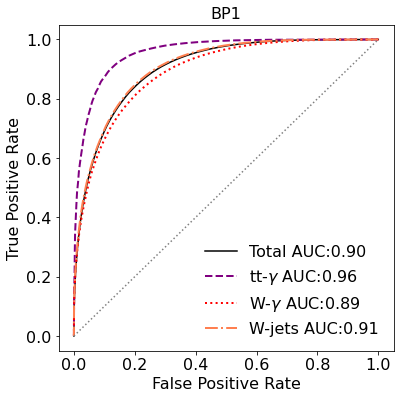

In [46]:
plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.plot(fpr_total, tpr_total, c = 'black', label = 'Total AUC:{:.2f}'.format(auc_total))
plt.plot(fpr_ttgamma, tpr_ttgamma, c = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$ AUC:{:.2f}'.format(auc_ttgamma))
plt.plot(fpr_wgamma, tpr_wgamma, c = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$ AUC:{:.2f}'.format(auc_wgamma))
plt.plot(fpr_wjets, tpr_wjets, c = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets AUC:{:.2f}'.format(auc_wjets))
plt.legend(frameon=False,fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.xlabel("False Positive Rate",fontsize=16)
plt.plot([0,1],[0,1],ls=":",color="grey")
plt.title(r"BP" + str(bp + 1),fontsize=16)

plt.savefig('../graph/ROC_BP' + str(bp + 1) + '_new.png', bbox_inches='tight')

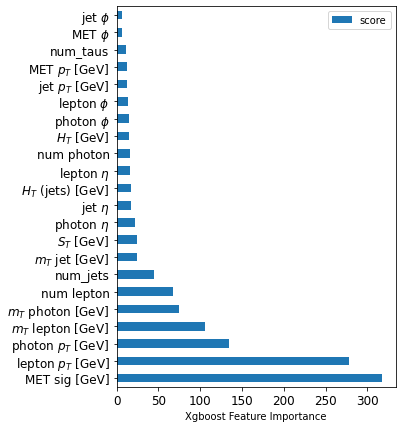

In [47]:
fig, ax = plt.subplots(figsize = (5,7))

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(len(lst) - 1, columns="score").plot(kind='barh', ax = ax) ## plot top 20 features

ax.set_xlabel("Xgboost Feature Importance")
ax.set_yticklabels(np.asarray(lst)[np.argsort(values)[::-1]])

plt.savefig('../graph/BP' + str(bp + 1) + '_featureImportance_new.png', bbox_inches='tight')

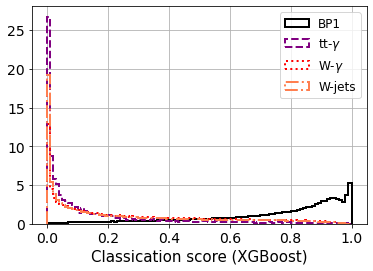

In [48]:
plt.hist(y_pred_xg[np.where(bkg_flag_test == 0)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = 'black', label = 'BP' + str(bp + 1), lw = 2)
plt.hist(y_pred_xg[np.where(bkg_flag_test == 3)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 1)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 2)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
#plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('../graph/MLOutput_dist_BP' + str(bp + 1) + '_new.png', bbox_inches="tight")

In [49]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

In [50]:
len(np.where(bkg_flag_test != 0)[0])

439041

In [51]:
len(np.where(bkg_flag_test == 0)[0])

324040

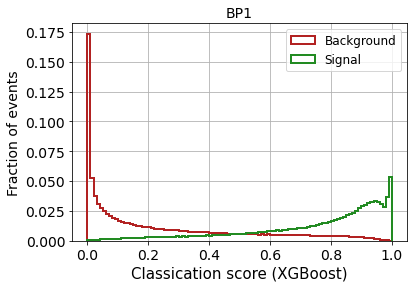

In [52]:
# XGBoost

########################
# CLASSIFICATION SCORE #
########################
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 100, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 100, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.title('BP' + str(bp + 1), fontsize=14)

plt.savefig('../graph/' + '2monian-output.pdf', format="pdf", bbox_inches="tight")

In [53]:
S_expected[bp]

202.45079649725346

In [54]:
S_expected[bp] / np.sqrt(B_expected)

0.5262698246238222

In [55]:
B_expected

147986.4804

In [56]:
print('MLL aproximated Z:')
print( MLL_aprox_discovery_ox(pred_XG_SM, pred_XG_NP, int(B_expected), int(S_expected[bp]))) 

MLL aproximated Z:
nan


/tmp/ipykernel_1023717/1019789035.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return (f0 + fB + fS)**0.5


## Sequential selection criteria

In [145]:
nbins = 10
indices_aux = np.arange(len(df_test_array))
        
n_np0      = len(np.where(df_test_array[:, 22] == 0)[0])

n_wgamma0  = len(np.where(df_test_array[:, 22] == 1)[0])
n_wjets0   = len(np.where(df_test_array[:, 22] == 2)[0])
n_ttgamma0 = len(np.where(df_test_array[:, 22] == 3)[0])
n_ttjets0  = len(np.where(df_test_array[:, 22] == 4)[0])
n_zjets0   = len(np.where(df_test_array[:, 22] == 5)[0])
n_wz0      = len(np.where(df_test_array[:, 22] == 6)[0])
n_zz0      = len(np.where(df_test_array[:, 22] == 7)[0])
n_ww0      = len(np.where(df_test_array[:, 22] == 8)[0])
n_tj0      = len(np.where(df_test_array[:, 22] == 9)[0])
n_tb0      = len(np.where(df_test_array[:, 22] == 10)[0])
n_tw0      = len(np.where(df_test_array[:, 22] == 11)[0])

sup_cuts = {}
inf_cuts = {}
random_vars = np.random.choice(range(len(df_test.columns) - 2), size = 100, replace = True)
random_vars = np.concatenate((np.random.choice(range(len(df_test.columns) - 3), size = len(df_test.columns) - 3, replace = False), random_vars))
#random_vars = list(np.argsort(values)[::-1])*10

for ivar in random_vars:
    #print(indices_aux)
    cuts = np.linspace(np.min(df_test_array[indices_aux,ivar]), np.max(df_test_array[indices_aux,ivar]), nbins)
    Z_sup = np.zeros(nbins)
    Z_inf = np.zeros(nbins)

    indices = []
    Z = []
    for icut, cut in enumerate(cuts): 
        
        # Superior ------------------------------------------------------------------------------------
        indices_sup = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cut) )[0]]
        indices.append(indices_sup)
        n_np      = len(np.where(df_test_array[indices_sup, 22] == 0)[0])
        
        n_wgamma  = len(np.where(df_test_array[indices_sup, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_sup, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_sup, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_sup, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_sup, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_sup, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_sup, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_sup, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_sup, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_sup, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_sup, 22] == 11)[0])

        wgamma_expected  = Wgamma_cross * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = Wjets_cross * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)
        ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
        zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
        wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
        zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
        ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
        tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
        tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
        tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

        S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + Wjets_expected + Wgamma_expected + ttjets_expected + \
                             zjets_expected + wz_expected + zz_expected + ww_expected + \
                             tj_expected + tb_expected + tw_expected)
        #if B_expected > 5: Z_sup[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (S_expected_aux > 5): 
            Z_sup[icut] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
            Z.append( np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)) )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------

        # Inferior ------------------------------------------------------------------------------------
        indices_inf = indices_aux[np.where( (df_test_array[indices_aux,ivar] <= cut) )[0]]
        indices.append(indices_inf)
        
        n_np      = len(np.where(df_test_array[indices_inf, 22] == 0)[0])
        
        n_wgamma  = len(np.where(df_test_array[indices_inf, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_inf, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_inf, 22] == 3)[0])
        n_ttjets  = len(np.where(df_test_array[indices_inf, 22] == 4)[0])
        n_zjets   = len(np.where(df_test_array[indices_inf, 22] == 5)[0])
        n_wz      = len(np.where(df_test_array[indices_inf, 22] == 6)[0])
        n_zz      = len(np.where(df_test_array[indices_inf, 22] == 7)[0])
        n_ww      = len(np.where(df_test_array[indices_inf, 22] == 8)[0])
        n_tj      = len(np.where(df_test_array[indices_inf, 22] == 9)[0])
        n_tb      = len(np.where(df_test_array[indices_inf, 22] == 10)[0])
        n_tw      = len(np.where(df_test_array[indices_inf, 22] == 11)[0])

        wgamma_expected  = Wgamma_cross * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = Wjets_cross * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)
        ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
        zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
        wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
        zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
        ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
        tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
        tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
        tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

        S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + Wjets_expected + Wgamma_expected + ttjets_expected + \
                             zjets_expected + wz_expected + zz_expected + ww_expected + \
                             tj_expected + tb_expected + tw_expected)
        
        #if B_expected > 5: Z_inf[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (S_expected_aux > 5): 
            Z_inf[icut] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
            Z.append( np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)) )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------
    max_cut = np.argmax(np.asarray(Z))
    #print('Z = ' + str(Z[max_cut]))
    indices_aux = indices[max_cut]
    max_cut = np.argmax((Z_inf, Z_sup))
    if max_cut >= len(Z_inf):
        print(df_test.columns[ivar] + ' >= ' + str(cuts[max_cut - len(Z_sup)]) + '; Z = ' + str(Z_sup[max_cut - len(Z_inf)]))
    #%    indices_aux = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cuts[max_cut - len(Z_sup)]) )[0]]
        if df.columns[ivar] in inf_cuts.keys():
            inf_cuts[df_test.columns[ivar]] = cuts[max_cut - len(Z_sup)]
        inf_cuts.setdefault(df_test.columns[ivar], cuts[max_cut - len(Z_sup)])
        sup_cuts.setdefault(df_test.columns[ivar], 999999)
    else:
        print(df_test.columns[ivar] + ' <= ' + str(cuts[max_cut]) + '; Z = ' + str(Z_inf[max_cut]))
    #%    indices_aux = indices_aux[np.where( (df_array[indices_aux,ivar] <= cuts[max_cut]) )[0]]
        if df.columns[ivar] in sup_cuts.keys():
            sup_cuts[df_test.columns[ivar]] = cuts[max_cut]
        sup_cuts.setdefault(df_test.columns[ivar], cuts[max_cut])
        inf_cuts.setdefault(df_test.columns[ivar], -999999)   
    
    
n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

wgamma_expected  = Wgamma_cross * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = Wjets_cross * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)
ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

# Formula discovery
B_expected_aux = int(ttgamma_expected + Wjets_expected + Wgamma_expected + ttjets_expected + \
                     zjets_expected + wz_expected + zz_expected + ww_expected + \
                     tj_expected + tb_expected + tw_expected)
if (B_expected_aux > 5) and (S_expected_aux > 5): 
    print('\n')
    print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)))
    print('Expected Background = ' + str(B_expected_aux))
    print('Expected Signal = ' + str(S_expected_aux))

num_taus <= 1.0; Z = 0.52502554464802
MET $\phi$ <= 3.142; Z = 0.52502554464802
jet $\eta$ <= 3.488666666666666; Z = 0.5251621503676188
$m_T$ photon [GeV] <= 704.5140591374243; Z = 0.5252207282803265
jet $p_T$ [GeV] <= 1436.8544444444444; Z = 0.5252367075345719
lepton $\phi$ <= 3.142; Z = 0.5252367075345719
num lepton <= 1.3333333333333333; Z = 0.5268880195584098
$m_T$ jet [GeV] <= 1623.965478651416; Z = 0.526898881242201
lepton $\eta$ <= 2.5; Z = 0.526898881242201
num photon <= 2.111111111111111; Z = 0.5269025019941774
$H_T$ [GeV] <= 2347.0288888888886; Z = 0.5269477672012814
jet $\phi$ <= 3.142; Z = 0.5269477672012814
photon $\phi$ <= 3.142; Z = 0.5269477672012814
photon $\eta$ <= 2.369; Z = 0.5269477672012814
lepton $p_T$ [GeV] <= 136.20555555555555; Z = 0.5299921456801336
photon $p_T$ [GeV] <= 241.4033333333333; Z = 0.530663335306558
MET $p_T$ [GeV] <= 816.4633333333334; Z = 0.53066520331039
$H_T$ (jets) [GeV] <= 1535.1433333333332; Z = 0.5308203135049219
MET sig [GeV] <= 30.520954

In [133]:
sup_cuts

{'num_taus': 1.0,
 '$H_T$ [GeV]': 1899.25,
 'photon $p_T$ [GeV]': 265.29,
 '$m_T$ photon [GeV]': 374.489118283658,
 'jet $\\phi$': 3.142,
 'MET $\\phi$': 3.142,
 'lepton $\\phi$': 3.142,
 'MET sig [GeV]': 35.16693936666481,
 'MET $p_T$ [GeV]': 1285.1877777777777,
 'lepton $p_T$ [GeV]': 123.47,
 'photon $\\eta$': 2.369,
 '$m_T$ lepton [GeV]': 330.15498905801724,
 'num photon': 2.111111111111111,
 'photon $\\phi$': 3.142,
 'jet $\\eta$': 4.483,
 'lepton $\\eta$': 2.5,
 'num lepton': 1.3333333333333333,
 '$m_T$ jet [GeV]': 2579.1063907564426,
 '$S_T$ [GeV]': 1616.8344444444444,
 '$H_T$ (jets) [GeV]': 1660.5077777777776}

In [134]:
inf_cuts

{'num_taus': -999999,
 '$H_T$ [GeV]': -999999,
 'photon $p_T$ [GeV]': -999999,
 '$m_T$ photon [GeV]': -999999,
 'jet $\\phi$': -999999,
 'MET $\\phi$': -999999,
 'lepton $\\phi$': -999999,
 'MET sig [GeV]': -999999,
 'MET $p_T$ [GeV]': -999999,
 'lepton $p_T$ [GeV]': -999999,
 'photon $\\eta$': -999999,
 '$m_T$ lepton [GeV]': -999999,
 'num photon': -999999,
 'photon $\\phi$': -999999,
 'jet $\\eta$': -999999,
 'lepton $\\eta$': -999999,
 'num lepton': -999999,
 '$m_T$ jet [GeV]': -999999,
 '$S_T$ [GeV]': -999999,
 '$H_T$ (jets) [GeV]': -999999}

In [135]:
write = True
if write:
    with open('../data/cuts/BP' + str(bp+1) + '_supCuts_new.txt', "w") as fp:
        json.dump(sup_cuts, fp)

    with open('../data/cuts/BP' + str(bp+1) + '_infCuts_new.txt', "w") as fp:
        json.dump(inf_cuts, fp)
else:
    with open('../data/cuts/BP' + str(bp+1) + '_supCuts_new.txt', "r") as fp:
        # Load the dictionary from the file
        sup_cuts = json.load(fp)
    with open('../data/cuts/BP' + str(bp+1) + '_infCuts_new.txt', "r") as fp:
        # Load the dictionary from the file
        inf_cuts = json.load(fp)

In [146]:
SM_test_pool = np.where(df_test_array[:,22] > 0)[0]
NP_test_pool = np.where(df_test_array[:,22] == 0)[0]

SM_indices = np.random.choice(SM_test_pool, size = np.random.poisson(int(B_expected)), replace = False)
NP_indices = np.random.choice(NP_test_pool, size = np.random.poisson(int(S_expected[bp])), replace = False)
indices_aux = np.concatenate((NP_indices, SM_indices))

variables = list(sup_cuts.keys())
for i in range(len(variables)):
    ind_var = np.where(df_test.columns == variables[i])[0][0]
    indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                            (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                           )[0]]


In [148]:
n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

wgamma_expected  = Wgamma_cross * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = Wjets_cross * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)
ttgamma_expected = ttgamma_cross * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
ttjets_expected  = ttjets_cross * ttjets_NLO * luminosidad * (n_ttjets * ttjets_aceptancia_init / n_ttjets0)
zjets_expected   = zjets_cross * zjets_NLO * luminosidad * (n_zjets * zjets_aceptancia_init / n_zjets0)
wz_expected      = wz_cross * wz_NLO * luminosidad * (n_wz * wz_aceptancia_init / n_wz0)
zz_expected      = zz_cross * zz_NLO * luminosidad * (n_zz * zz_aceptancia_init / n_zz0)
ww_expected      = ww_cross * ww_NLO * luminosidad * (n_ww * ww_aceptancia_init / n_ww0)
tj_expected      = tj_cross * tj_NLO * luminosidad * (n_tj * tj_aceptancia_init / n_tj0)
tb_expected      = tb_cross * tb_NLO * luminosidad * (n_tb * tb_aceptancia_init / n_tb0)
tw_expected      = tw_cross * tw_NLO * luminosidad * (n_tw * tw_aceptancia_init / n_tw0)

S_expected_aux = n_np#int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

# Formula discovery
B_expected_aux = int(ttgamma_expected + Wjets_expected + Wgamma_expected + ttjets_expected + \
                     zjets_expected + wz_expected + zz_expected + ww_expected + \
                     tj_expected + tb_expected + tw_expected)
if (B_expected_aux >= 5) and (S_expected_aux >= 5): 
    print('\n')
    print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)))
    print('Expected Background = ' + str(B_expected_aux))
    print('Expected Signal = ' + str(S_expected_aux))



Z =  0.6484486599362412
Expected Background = 124639
Expected Signal = 229


In [149]:
nexperiments = 2000

SM_test_pool = np.where(df_test_array[:,22] > 0)[0]
NP_test_pool = np.where(df_test_array[:,22] == 0)[0]

q0_exp = np.zeros(nexperiments)
B_observed_exp = np.zeros(nexperiments)
S_observed_exp = np.zeros(nexperiments)
for nexp in tqdm(range(nexperiments)):
    # Let's create a pseudo-experiment
    SM_indices = np.random.choice(SM_test_pool, size = np.random.poisson(int(B_expected)), replace = False)
    NP_indices = np.random.choice(NP_test_pool, size = np.random.poisson(int(S_expected[bp])), replace = False)
    indices_aux = np.concatenate((NP_indices, SM_indices))

    #%print('At the beggining')
    #%print('\n')
    #%print('Total:' + str(len(indices_aux)))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
    #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
    #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
    #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
    #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    #%print('\n')
    # Let's make the cuts

    variables = list(sup_cuts.keys())
    for i in range(len(variables)):
        #print(variables[i] + '<=' + str(sup_cuts[variables[i]]))
        #print(variables[i] + '>=' + str(inf_cuts[variables[i]]))
        ind_var = np.where(df_test.columns == variables[i])[0][0]
        indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                                (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                               )[0]]

        #%print('Total:' + str(len(indices_aux)))
        #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
        #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
        #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
        #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
        #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    # Let's calculate everything
    
    n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])
    
    n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
    n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
    n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])
    n_ttjets  = len(np.where(df_test_array[indices_aux, 22] == 4)[0])
    n_zjets   = len(np.where(df_test_array[indices_aux, 22] == 5)[0])
    n_wz      = len(np.where(df_test_array[indices_aux, 22] == 6)[0])
    n_zz      = len(np.where(df_test_array[indices_aux, 22] == 7)[0])
    n_ww      = len(np.where(df_test_array[indices_aux, 22] == 8)[0])
    n_tj      = len(np.where(df_test_array[indices_aux, 22] == 9)[0])
    n_tb      = len(np.where(df_test_array[indices_aux, 22] == 10)[0])
    n_tw      = len(np.where(df_test_array[indices_aux, 22] == 11)[0])

    #%print('At the end')
    #%print('\n')
    #%print('Total:' + str(len(indices_aux)))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 22] == 0)[0])))
    #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
    #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
    #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
    #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    #%print('\n')

    #S_expected_aux = n_np
    S_observed_exp[nexp] = n_np

    # Formula discovery
    B_observed_exp[nexp] = n_ttgamma + n_wgamma + n_wjets + \
                           n_ttjets + n_zjets + n_wz + \
                           n_zz + n_ww + n_tj + \
                           n_tb + n_tw
        
    N_observed = n_np + n_ttgamma + n_wgamma + n_wjets+ \
                 n_ttjets + n_zjets + n_wz + \
                 n_zz + n_ww + n_tj + \
                 n_tb + n_tw
    
    if (B_expected_aux >= 5) and (S_expected_aux >= 5): 
        q0_exp[nexp] = -2 * N_observed * np.log(B_expected_aux / N_observed) -2 * (N_observed - B_expected_aux)
        #Z_exp[nexp] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
        #%print('\n')
        #%print('Z = ', Z_exp[nexp])
        #%print('Expected Background = ' + str(B_expected_aux))
        #%print('Expected Signal = ' + str(S_expected_aux))
    else:
        q0_exp[nexp] = -99
        #print('Expected Background = ' + str(B_observed_exp))
        #print('Expected Signal = ' + str(S_observed_exp))
    #%print('------------------------------------------')
        

100%|████████████████████████████████████████████████████████████████| 2000/2000 [01:25<00:00, 23.28it/s]


(array([  1.,  34., 119., 367., 531., 513., 302.,  99.,  29.,   5.]),
 array([147. , 157.1, 167.2, 177.3, 187.4, 197.5, 207.6, 217.7, 227.8,
        237.9, 248. ]),
 <BarContainer object of 10 artists>)

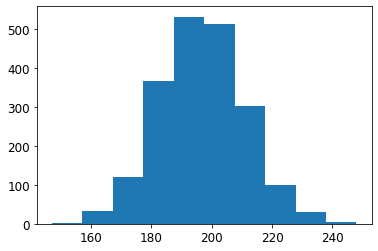

In [150]:
plt.hist(S_observed_exp)

(array([  7.,  23., 109., 251., 414., 497., 407., 209.,  67.,  16.]),
 array([113870. , 114077.8, 114285.6, 114493.4, 114701.2, 114909. ,
        115116.8, 115324.6, 115532.4, 115740.2, 115948. ]),
 <BarContainer object of 10 artists>)

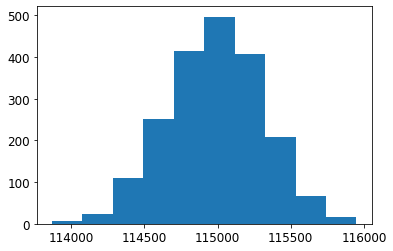

In [151]:
plt.hist(B_observed_exp)

In [152]:
print('Final results: for BP ' + str(bp+1) + '\n ')
print('Z = ' + str(np.sqrt(np.median(q0_exp))) + '; Z_std = ' + str(np.std(q0_exp) / (2 * np.sqrt(np.median(q0_exp)))))
print('B_exp = ' + str(np.mean(B_observed_exp)) + '; B_exp_std = ' + str(np.std(B_observed_exp)))
print('S_exp = ' + str(np.mean(S_observed_exp)) + '; S_exp_std = ' + str(np.std(S_observed_exp)))

Final results: for BP 1
 
Z = 27.144341662688564; Z_std = 0.94230779225132
B_exp = 114983.1715; B_exp_std = 323.19286979720016
S_exp = 196.695; S_exp_std = 13.968964707522172


In [142]:
imp_vars = np.array(['MET sig [GeV]', 'lepton $p_T$ [GeV]', '$m_T$ lepton [GeV]',
       '$m_T$ photon [GeV]'])
#imp_vars = np.asarray(lst)[np.argsort(values)[::-1]][:4]


In [143]:
imp_vars

array(['MET sig [GeV]', 'lepton $p_T$ [GeV]', '$m_T$ lepton [GeV]',
       '$m_T$ photon [GeV]'], dtype='<U18')

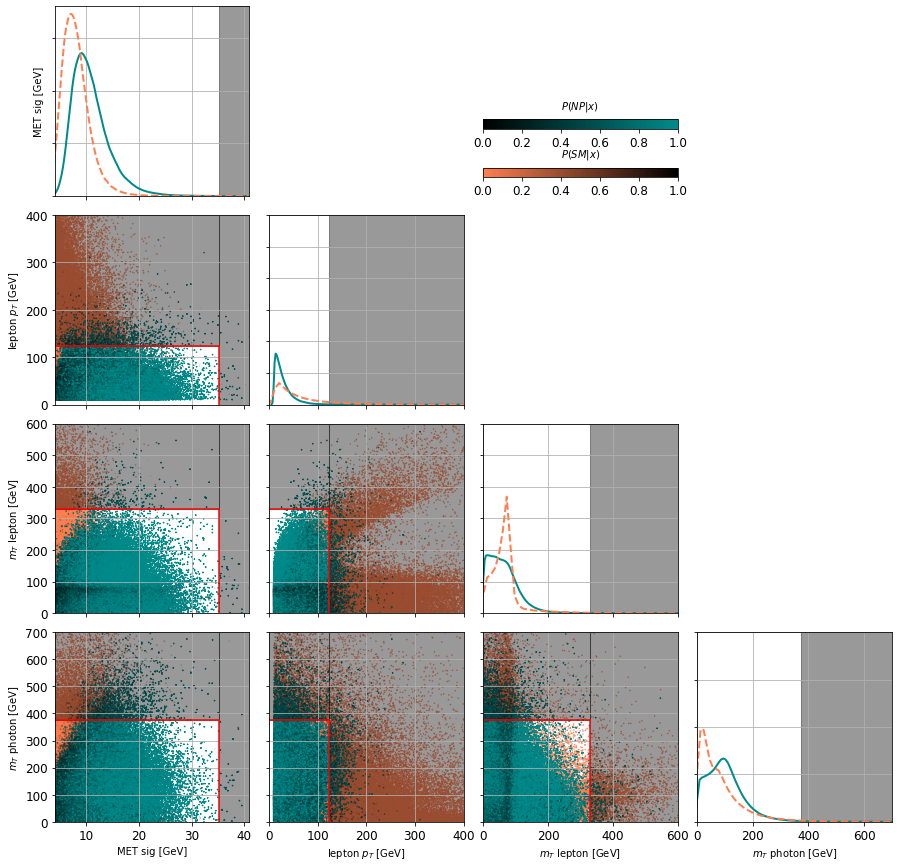

In [144]:
SM = df_test.loc[df_test['bkg_flag_pool'] > 0]
NP = df_test.loc[df_test['bkg_flag_pool'] == 0]

limites = [[4,41], [0,400], [0,600], [0,700]]
ylimites = [[0,0.18], [0,0.15], [0,0.03], [0,0.02]]

fig,ax = plt.subplots(4,4, figsize = (15,15), gridspec_kw={'hspace':0.1, 'wspace':0.1})

for i in range(4):
    for j in range(4):
        if i != 3: ax[i,j].set_xticklabels([])
        if j != 0: ax[i,j].set_yticklabels([])
        if i >= j:
            if i==j:
                sns.kdeplot(NP[imp_vars[i]], ax = ax[i,j], color = 'darkcyan', lw=2, ls = 'solid')
                sns.kdeplot(SM[imp_vars[i]], ax = ax[i,j], color = 'coral', lw=2, ls = '--')
                ax[i,j].set_ylabel('')
                ax[i,j].set_xlabel('')
                ax[i,j].set_xlim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = sup_cuts[imp_vars[i]], x2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = -1, x2 = inf_cuts[imp_vars[i]], color = 'black', alpha = 0.4)
                ax[i,j].set_ylim(ylimites[i])
            else:
                im_SM = ax[i,j].scatter(SM[imp_vars[j]], SM[imp_vars[i]], s = 0.8, marker = '.', 
                                        c = pred_XG_SM, cmap = SM_cmap, vmin = 0, vmax = 1, alpha = (1-pred_XG_SM))
                im_NP = ax[i,j].scatter(NP[imp_vars[j]], NP[imp_vars[i]], s = 0.8, marker = '*', 
                                        c = pred_XG_NP, cmap = NP_cmap, vmin = 0, vmax = 1, alpha = pred_XG_NP)
                ax[i,j].set_xlim(SM[imp_vars[j]].min(), SM[imp_vars[j]].max())
                ax[i,j].set_ylim(SM[imp_vars[i]].min(), SM[imp_vars[i]].max())
                ax[i,j].set_xlim(limites[j])
                ax[i,j].set_ylim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 10000], x1 = sup_cuts[imp_vars[j]], x2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_betweenx(y = [-1, 10000], x1 = -1, x2 = inf_cuts[imp_vars[j]], color = 'black', alpha = 0.4)
                ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = sup_cuts[imp_vars[i]], y2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = -1, y2 = inf_cuts[imp_vars[i]], color = 'black', alpha = 0.4)
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], inf_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[sup_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], inf_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([sup_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                
            ax[i,j].grid(which = 'both')
        else:
            ax[i,j].axis('off')

ax[3,0].set_xlabel(imp_vars[0])
ax[3,1].set_xlabel(imp_vars[1])
ax[3,2].set_xlabel(imp_vars[2])
ax[3,3].set_xlabel(imp_vars[3])

ax[0,0].set_ylabel(imp_vars[0])
ax[1,0].set_ylabel(imp_vars[1])
ax[2,0].set_ylabel(imp_vars[2])
ax[3,0].set_ylabel(imp_vars[3])

ax[0,0].set_xticklabels([])

ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])

ax[2,2].set_yticklabels([])
ax[2,2].set_xticklabels([])

ax[3,3].set_yticklabels([])
ax[0,0].set_yticklabels([])

cbar_SM = plt.colorbar(im_SM, ax = ax[0,2], orientation = 'horizontal')
cbar_SM.set_label('$P(SM|x)$', labelpad=-50)
cbar_NP = plt.colorbar(im_NP, ax = ax[0,2], orientation = 'horizontal')
cbar_NP.set_label('$P(NP|x)$', labelpad=-50)

plt.savefig('../graph/BP' + str(bp+1) + '/ImpVars_dist_new.pdf')

## BinnedLikelihood

In [153]:
print(pred_XG_SM.shape)
print(pred_XG_NP.shape)

(439041,)
(324040,)


In [154]:
B_expected = int(B_expected)

In [155]:
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)

bins_to_test=range(1,500) # number of bins we are testing to see if condition holds

# FIND THE NUMBER OF BINS:
num_bins = max_num_bins(pred_XG_SM, int(B_expected), range_dat, MIN_EVS, bins_to_test)

print('\n FOR BIN LIKELIHOOD WE ARE SETTING:')
print('min number of Background events allowed per bin: ', MIN_EVS)
print('number of bins we are going to use: ', num_bins)
print('range of our data: ', range_dat)

At least 5 B events per bin, range = [[0, 1]]:
# bins:  224 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
number of bins we are going to use:  224
range of our data:  [[0, 1]]


In [156]:
# Z Poisson Bin Likelihood (Asimov data set)
D_or_E = 'discovery'
store_Z_asimov = []

Z_asimov = Z_BL_asimov(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), 25, range_dat, MIN_EVS, linear_bins=True) 
store_Z_asimov.append( Z_asimov )
    
    
print('\n FINAL RESULT for BP' + str(bp+1) + ':\n')
print(store_Z_asimov)


 FINAL RESULT for BP1:

[2.0082248257137674]


B_expected:  147986
S_expected:  202.45079649725346

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


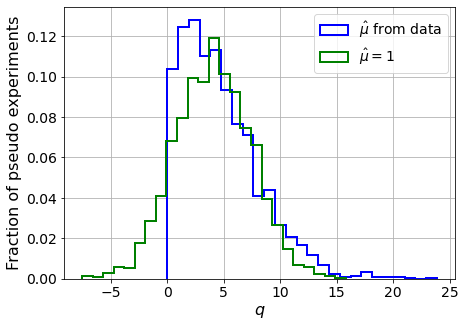

muhat mean:  1.028125
Z_bins:  2.0175272376703317
std Z_bins:  0.8628754231237187
Z_bins mu=0:  2.0189762198568157
std Z_bins mu=0:  0.831968896206629

--------


 FINAL RESULT:

[[2.0175272376703317, 0.8628754231237187, 1.028125, 2.0189762198568157, 0.831968896206629]]


In [157]:
# requested number of pseudo experiments
num_pseudo = 2000

# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []

    
print('B_expected: ', B_expected)
print('S_expected: ', S_expected[bp])
print('')

#Z_BL = BL_test_fast(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True, path = '../graph/BP' + str(bp+1) + '/') 
Z_BL = BL_test_fast(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 

store_Z_BL.append( list(Z_BL) )

print('muhat mean: ', Z_BL[2])
print('Z_bins: ', Z_BL[0])
print('std Z_bins: ', Z_BL[1])
print('Z_bins mu=0: ', Z_BL[3])
print('std Z_bins mu=0: ', Z_BL[4])
print('')
print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)

B_expected:  147986
S_expected:  202.45079649725346

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


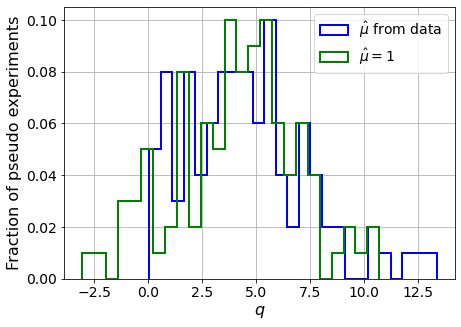

muhat mean:  1.0092043807903361
Z_bins:  2.0811436686027958
std Z_bins:  0.6888901505352494
Z_bins mu=0:  2.0796310719802613
std Z_bins mu=0:  0.6872851003165914

--------


 FINAL RESULT:

[[2.0811436686027958, 0.6888901505352494, 1.0092043807903361, 2.0796310719802613, 0.6872851003165914]]


In [158]:
# requested number of pseudo experiments
num_pseudo = 100

# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []

    
print('B_expected: ', B_expected)
print('S_expected: ', S_expected[bp])
print('')

#Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True, path = '../graph/BP' + str(bp+1) + '/') 
Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 

store_Z_BL.append( list(Z_BL) )

print('muhat mean: ', Z_BL[2])
print('Z_bins: ', Z_BL[0])
print('std Z_bins: ', Z_BL[1])
print('Z_bins mu=0: ', Z_BL[3])
print('std Z_bins mu=0: ', Z_BL[4])
print('')
print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)

## loop pseudo exps. Fix ML and KDE

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
           -inf  2151.66378942  2013.53428755  1843.62405184
  1643.69758171  1402.18250311  1107.36022748   744.87670133
   296.77911631  -281.88868635 -1017.15099543 -2092.48214707]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  1801.25202889


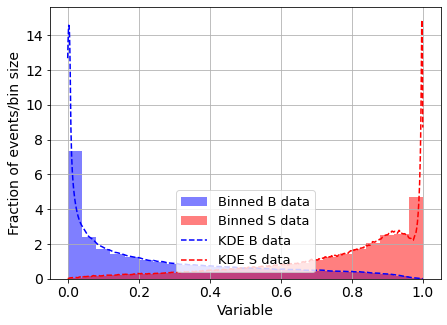

KDE Kernel:  epanechnikov
Background bandwidth:  0.008287452507534925
Signal bandwidth:  0.0031053121543406503


In [53]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs

# outputs:
# 1st -> background PDF
# 2nd -> signal PDF
# 3rd -> (normalization factor of the background PDF)**-1
# 4th -> (normalization factor of the signal PDF)**-1
# 5th -> background bandwidth
# 6th -> signal bandwidth
kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                        20000, # Numero de datos para fitear
                                                                                        np.logspace(-4.0, 0.05, 20), 
                                                                                        set_kernel='epanechnikov')

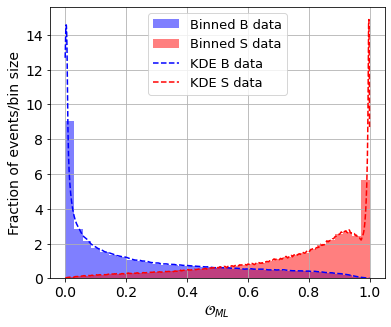

In [70]:
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

# points
s_vals = np.linspace(min_val,max_val,1000)

# evaluate the PDFs for each value of s
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )

# normalize
dens_bkg = dens_bkg / norm_factor_SM
dens_sig = dens_sig / norm_factor_NP

plt.figure(figsize=(6,5))

plt.hist(pred_XG_SM, 35, range=[min_val,max_val], density=True, color='blue',alpha=0.5, linewidth=2, label=r'Binned B data');
plt.hist(pred_XG_NP, 35, range=[min_val,max_val], density=True, color='red',alpha=0.5, linewidth=2, label=r'Binned S data');

plt.plot(s_vals, dens_bkg, color='blue',label=r'KDE B data',linestyle='dashed');
plt.plot(s_vals, dens_sig, color='red',label=r'KDE S data',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.yscale('log')
plt.xlabel("$\mathcal{O}_{ML}$",fontsize=14)
plt.ylabel("Fraction of events/bin size",fontsize=14)
plt.grid()
plt.legend(loc='upper center',fontsize=13)

plt.savefig('../graph/KDE_fit_BP' + str(bp+1) + '.pdf')

In [54]:
print(norm_factor_SM)
print(norm_factor_NP)

97.97245046006259
271.8735532200964


In [55]:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

print('This may take a while...')

pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
print('1 done')
pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
print('2 done')

# Normalize
pB_B_data = pB_B_data / norm_factor_SM
pS_B_data = pS_B_data / norm_factor_NP

This may take a while...
1 done
2 done


In [56]:
# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
print('3 done')
pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
print('4 done')

# Normalize
pB_S_data = pB_S_data / norm_factor_SM
pS_S_data = pS_S_data / norm_factor_NP
   

3 done
4 done


(array([143422., 138086.,   6451.,   4478.,   3429.,   2722.,   3403.,
          4645.,   5681.,  11725.]),
 array([7.08305385e-03, 1.52018219e+00, 3.03328133e+00, 4.54638047e+00,
        6.05947960e+00, 7.57257874e+00, 9.08567788e+00, 1.05987770e+01,
        1.21118762e+01, 1.36249753e+01, 1.51380744e+01]),
 [<matplotlib.patches.Polygon at 0x7f0a856c35e0>])

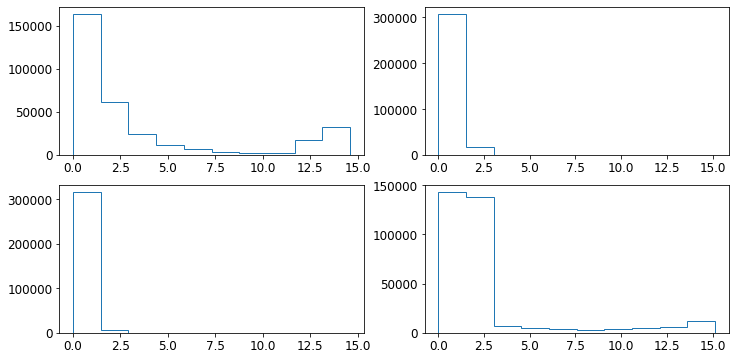

In [57]:
fig,ax = plt.subplots(2,2, figsize = (12,6))

ax[0,0].hist(pB_B_data, histtype = 'step')
ax[0,1].hist(pS_B_data, histtype = 'step')

ax[1,0].hist(pB_S_data, histtype = 'step')
ax[1,1].hist(pS_S_data, histtype = 'step')

In [ ]:
# indeces (to later build a random pseudo experiment)
indices_B = [i for i in range(len(pS_B_data))]
indices_S = [i for i in range(len(pS_S_data))]
        
        

In [ ]:
# loop over the number of pseudo experiments
#np.random.seed(91218)
Z_MLL = []
Z_MLL_std = []
Z_MLL_mu = []
Z_MLL_std_mu = []
for iloop in range(20): 
    print(iloop)
    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(200)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )
            
    

    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )

In [ ]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.savefig('../graph/loopBP6_KDEfijo.pdf')

## Loop varying KDE

In [ ]:
B_expected

In [ ]:
Z_MLL = []
Z_MLL_std = []
Z_MLL_mu = []
Z_MLL_std_mu = []
for iloop in range(20):
    print(iloop)
    kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                            50000, # Numero de datos para fitear
                                                                                            np.logspace(-4.0, 0.05, 20), 
                                                                                            set_kernel='epanechnikov')
    print('This may take a while...')

    pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
    print('1 done')
    pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
    print('2 done')

    # Normalize
    pB_B_data = pB_B_data / norm_factor_SM
    pS_B_data = pS_B_data / norm_factor_NP
    
    pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
    print('3 done')
    pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
    print('4 done')

    # Normalize
    pB_S_data = pB_S_data / norm_factor_SM
    pS_S_data = pS_S_data / norm_factor_NP
    
    # indeces (to later build a random pseudo experiment)
    indices_B = [i for i in range(len(pS_B_data))]
    indices_S = [i for i in range(len(pS_S_data))]
    # loop over the number of pseudo experiments
    #np.random.seed(91218)

    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(50)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )



    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )

In [ ]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.savefig('../graph/loopBP6_50000_KDEvariable_B_2.pdf')

## loop varying ML

In [56]:
lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

0
AUC:0.9038603651300705
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


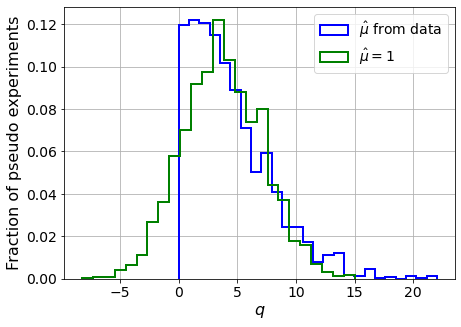

Z BL:(1.9141668332282669, 0.9106932319849318, 1.00175, 1.9141668332282669, 0.8853605859717837)


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
  5704.4096533   5427.12953423  5074.7400816   4659.79420554
  4155.70433574  3541.2541551   2808.06547242  1906.72094433
   755.65818051  -740.87200454 -2604.40301718 -5256.20794765]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  4076.60021923


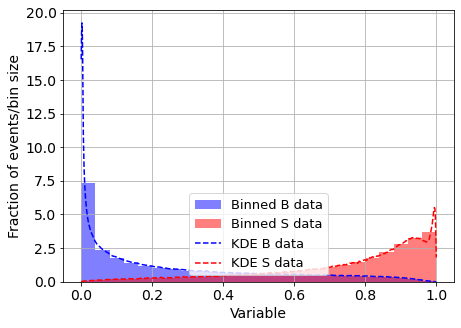

KDE Kernel:  epanechnikov
Background bandwidth:  0.005072980090653727
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.005418586555851798
0.005418586555851798
3 done
4 done
0.0033333555678656097
0.0033333555678656097
B_expected:  147986
S_expected:  202

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


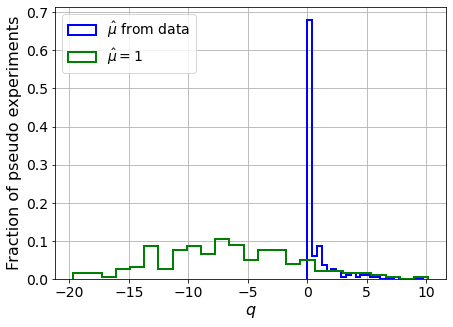

Z_MLL:  0.1290076608905668
std Z_MLL:  5.600584022788989


  0%|▎                                                                   | 1/200 [00:00<01:31,  2.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5159895056658624
<p_{s}(Sdata)> = 1.8447734739927573
<p_{b}(Bdata)> = 4.026064693902021
<p_{s}(Bdata)> = 0.42483587664598993


  1%|▋                                                                   | 2/200 [00:00<01:31,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4599182689396881
<p_{s}(Sdata)> = 1.9353959744164704
<p_{b}(Bdata)> = 4.057672567099336
<p_{s}(Bdata)> = 0.42665227501250924


  2%|█▎                                                                  | 4/200 [00:02<02:25,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4422835137283826
<p_{s}(Sdata)> = 2.0110432855015294
<p_{b}(Bdata)> = 4.060472188820154
<p_{s}(Bdata)> = 0.4255035419419532


  2%|█▋                                                                  | 5/200 [00:03<02:04,  1.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39917188229444983
<p_{s}(Sdata)> = 2.0434023137184916
<p_{b}(Bdata)> = 4.052604347708822
<p_{s}(Bdata)> = 0.4256946774427633


  4%|██▋                                                                 | 8/200 [00:05<02:19,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3954089942041342
<p_{s}(Sdata)> = 2.006544436558414
<p_{b}(Bdata)> = 4.055480552761346
<p_{s}(Bdata)> = 0.4249349423965286


  5%|███▎                                                               | 10/200 [00:07<02:20,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3984722484282896
<p_{s}(Sdata)> = 2.092811350457789
<p_{b}(Bdata)> = 4.041539281643006
<p_{s}(Bdata)> = 0.4249754760497145


  6%|████▎                                                              | 13/200 [00:10<02:23,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46791247746953724
<p_{s}(Sdata)> = 2.089792664470129
<p_{b}(Bdata)> = 4.0472313027609985
<p_{s}(Bdata)> = 0.42555981862020525


  8%|█████▎                                                             | 16/200 [00:13<02:46,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5221077447103898
<p_{s}(Sdata)> = 1.751002933858174
<p_{b}(Bdata)> = 4.039398149693606
<p_{s}(Bdata)> = 0.4257347352131908


 11%|███████▎                                                           | 22/200 [00:21<03:11,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4725719210162579
<p_{s}(Sdata)> = 1.9466493447365691
<p_{b}(Bdata)> = 4.064452741803867
<p_{s}(Bdata)> = 0.42607770536992834


 12%|████████                                                           | 24/200 [00:22<02:29,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5008060066070994
<p_{s}(Sdata)> = 1.9149081868353888
<p_{b}(Bdata)> = 4.048528113377209
<p_{s}(Bdata)> = 0.42701702640215977


 13%|████████▋                                                          | 26/200 [00:23<02:10,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43133946647849664
<p_{s}(Sdata)> = 2.0066093296459964
<p_{b}(Bdata)> = 4.058967835182809
<p_{s}(Bdata)> = 0.4254925415001658


 18%|███████████▋                                                       | 35/200 [00:34<02:44,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37779099772762376
<p_{s}(Sdata)> = 2.1442129240696874
<p_{b}(Bdata)> = 4.042451809405846
<p_{s}(Bdata)> = 0.42687637266029727


 18%|████████████                                                       | 36/200 [00:34<02:17,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4390685586017615
<p_{s}(Sdata)> = 2.0342922709727738
<p_{b}(Bdata)> = 4.057312542748944
<p_{s}(Bdata)> = 0.4224886097730824


 18%|████████████▍                                                      | 37/200 [00:35<01:58,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4514646905285099
<p_{s}(Sdata)> = 1.9352937236903123
<p_{b}(Bdata)> = 4.022564373437043
<p_{s}(Bdata)> = 0.4248006771227038


 19%|████████████▋                                                      | 38/200 [00:35<01:44,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3864323970730254
<p_{s}(Sdata)> = 2.0862693017647924
<p_{b}(Bdata)> = 4.059517407787518
<p_{s}(Bdata)> = 0.4245119050613353


 20%|█████████████                                                      | 39/200 [00:36<01:35,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4287442751775398
<p_{s}(Sdata)> = 2.0189085991164135
<p_{b}(Bdata)> = 4.046222079639154
<p_{s}(Bdata)> = 0.4267511271582393


 22%|██████████████▋                                                    | 44/200 [00:42<03:01,  1.16s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.40542784086724726
<p_{s}(Sdata)> = 2.0782076961206637
<p_{b}(Bdata)> = 4.0498799445219325
<p_{s}(Bdata)> = 0.4233657610544166


 28%|██████████████████▍                                                | 55/200 [00:56<02:27,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4265879267417378
<p_{s}(Sdata)> = 1.907580235055484
<p_{b}(Bdata)> = 4.048940574064357
<p_{s}(Bdata)> = 0.42382328139434355


 30%|████████████████████▍                                              | 61/200 [01:03<02:21,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.407002198253735
<p_{s}(Sdata)> = 2.130351014646151
<p_{b}(Bdata)> = 4.082137549757395
<p_{s}(Bdata)> = 0.42505301737504786


 31%|████████████████████▊                                              | 62/200 [01:04<01:57,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48844424313407137
<p_{s}(Sdata)> = 2.0281191061398065
<p_{b}(Bdata)> = 4.052580776297273
<p_{s}(Bdata)> = 0.4244220987989328


 32%|█████████████████████▊                                             | 65/200 [01:07<02:13,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40012033067900016
<p_{s}(Sdata)> = 2.072311745550724
<p_{b}(Bdata)> = 4.041300366461962
<p_{s}(Bdata)> = 0.4267842649991786


 33%|██████████████████████                                             | 66/200 [01:08<01:51,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4390985925316444
<p_{s}(Sdata)> = 1.9924345642689858
<p_{b}(Bdata)> = 4.043242456021098
<p_{s}(Bdata)> = 0.4255859621073847


 34%|██████████████████████▍                                            | 67/200 [01:08<01:36,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4604404483397746
<p_{s}(Sdata)> = 1.927276412424525
<p_{b}(Bdata)> = 4.057187412313691
<p_{s}(Bdata)> = 0.4253082354272878


 34%|██████████████████████▊                                            | 68/200 [01:09<01:24,  1.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4471846765372481
<p_{s}(Sdata)> = 1.8854043212606157
<p_{b}(Bdata)> = 4.056557060954057
<p_{s}(Bdata)> = 0.42423310002809583


 34%|███████████████████████                                            | 69/200 [01:09<01:17,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3887467817409726
<p_{s}(Sdata)> = 2.2086484712472885
<p_{b}(Bdata)> = 4.054113866383495
<p_{s}(Bdata)> = 0.425209939763039


 36%|████████████████████████▍                                          | 73/200 [01:13<01:39,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39746037056436917
<p_{s}(Sdata)> = 2.0473961096481377
<p_{b}(Bdata)> = 4.036535742839635
<p_{s}(Bdata)> = 0.42706676783440234


 38%|█████████████████████████▊                                         | 77/200 [01:17<01:51,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41294659004184076
<p_{s}(Sdata)> = 2.0430102860234003
<p_{b}(Bdata)> = 4.057985477119158
<p_{s}(Bdata)> = 0.4270005964500735


 42%|████████████████████████████▏                                      | 84/200 [01:25<01:52,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4274914764154305
<p_{s}(Sdata)> = 1.942279601645845
<p_{b}(Bdata)> = 4.054526246954222
<p_{s}(Bdata)> = 0.42788588971636343


 44%|█████████████████████████████▏                                     | 87/200 [01:28<01:39,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4215304391795188
<p_{s}(Sdata)> = 2.030174164716259
<p_{b}(Bdata)> = 4.047805800759618
<p_{s}(Bdata)> = 0.42566128350801136


 44%|█████████████████████████████▊                                     | 89/200 [01:30<01:28,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42320848700022257
<p_{s}(Sdata)> = 2.0754282556106016
<p_{b}(Bdata)> = 4.010060093230353
<p_{s}(Bdata)> = 0.4284661336584827


 45%|██████████████████████████████▏                                    | 90/200 [01:30<01:17,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4020419647427811
<p_{s}(Sdata)> = 2.1628188205165326
<p_{b}(Bdata)> = 4.032624270902279
<p_{s}(Bdata)> = 0.42727549356543904


 46%|██████████████████████████████▍                                    | 91/200 [01:31<01:08,  1.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43598663431083085
<p_{s}(Sdata)> = 1.9872615694799158
<p_{b}(Bdata)> = 4.05754271509119
<p_{s}(Bdata)> = 0.4255352988524336


 46%|██████████████████████████████▊                                    | 92/200 [01:31<01:02,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49725066971438103
<p_{s}(Sdata)> = 1.8887592403786255
<p_{b}(Bdata)> = 4.043550275574774
<p_{s}(Bdata)> = 0.42549741928380924


 46%|███████████████████████████████▏                                   | 93/200 [01:31<00:58,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45135566816618855
<p_{s}(Sdata)> = 1.9678732374840286
<p_{b}(Bdata)> = 4.06784197104177
<p_{s}(Bdata)> = 0.4248755752411937


 47%|███████████████████████████████▍                                   | 94/200 [01:32<00:54,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.435653219390714
<p_{s}(Sdata)> = 2.049270213794317
<p_{b}(Bdata)> = 4.054214395720117
<p_{s}(Bdata)> = 0.42463605855167036


 49%|████████████████████████████████▊                                  | 98/200 [01:36<01:19,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.413758843258007
<p_{s}(Sdata)> = 2.0401008362788606
<p_{b}(Bdata)> = 4.054898146121228
<p_{s}(Bdata)> = 0.42369312912358653


 50%|█████████████████████████████████▏                                 | 99/200 [01:36<01:09,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5598458264409274
<p_{s}(Sdata)> = 1.744928204803331
<p_{b}(Bdata)> = 4.074328674270201
<p_{s}(Bdata)> = 0.42460897931332975


 50%|█████████████████████████████████                                 | 100/200 [01:37<01:02,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43835614627326525
<p_{s}(Sdata)> = 1.969287395870925
<p_{b}(Bdata)> = 4.046042749887369
<p_{s}(Bdata)> = 0.4226546182937134


 50%|█████████████████████████████████▎                                | 101/200 [01:37<00:56,  1.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39843360207986234
<p_{s}(Sdata)> = 2.013654012615982
<p_{b}(Bdata)> = 4.054969516033106
<p_{s}(Bdata)> = 0.4272988772869514


 53%|██████████████████████████████████▉                               | 106/200 [01:43<01:37,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.42865685287548577
<p_{s}(Sdata)> = 1.986149505440589
<p_{b}(Bdata)> = 4.0367931742034
<p_{s}(Bdata)> = 0.42830116414920166


 54%|███████████████████████████████████▋                              | 108/200 [01:45<01:26,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4485046320971811
<p_{s}(Sdata)> = 1.8644451477307218
<p_{b}(Bdata)> = 4.0482034811651255
<p_{s}(Bdata)> = 0.42775938817190573


 56%|████████████████████████████████████▋                             | 111/200 [01:48<01:11,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42720454562887555
<p_{s}(Sdata)> = 1.9536966700155711
<p_{b}(Bdata)> = 4.052245639472286
<p_{s}(Bdata)> = 0.4244780314006094


 57%|█████████████████████████████████████▉                            | 115/200 [01:51<01:08,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4204423650655318
<p_{s}(Sdata)> = 2.042790760601972
<p_{b}(Bdata)> = 4.053176455463721
<p_{s}(Bdata)> = 0.424920709850955


 61%|████████████████████████████████████████▎                         | 122/200 [01:58<01:08,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5416155138596414
<p_{s}(Sdata)> = 1.9553436449444888
<p_{b}(Bdata)> = 4.063739729338316
<p_{s}(Bdata)> = 0.42460182094721455


 62%|████████████████████████████████████████▌                         | 123/200 [01:58<00:58,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4467476164586877
<p_{s}(Sdata)> = 1.9569737801138691
<p_{b}(Bdata)> = 4.049221160414837
<p_{s}(Bdata)> = 0.4251337641081738


 62%|████████████████████████████████████████▉                         | 124/200 [01:59<00:51,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4232792761815725
<p_{s}(Sdata)> = 1.958449146296505
<p_{b}(Bdata)> = 4.0646020480894345
<p_{s}(Bdata)> = 0.42284694923227595


 66%|███████████████████████████████████████████▏                      | 131/200 [02:08<01:13,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.386856272820552
<p_{s}(Sdata)> = 2.1507607481947617
<p_{b}(Bdata)> = 4.066764867315853
<p_{s}(Bdata)> = 0.42377615272808694


 66%|███████████████████████████████████████████▌                      | 132/200 [02:08<00:59,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4509041968920264
<p_{s}(Sdata)> = 1.900289853070611
<p_{b}(Bdata)> = 4.059681616237055
<p_{s}(Bdata)> = 0.42415058133835315


 67%|████████████████████████████████████████████▏                     | 134/200 [02:10<00:52,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4707897698455417
<p_{s}(Sdata)> = 1.7869040391400015
<p_{b}(Bdata)> = 4.04170791548781
<p_{s}(Bdata)> = 0.4261425336272195


 68%|█████████████████████████████████████████████▏                    | 137/200 [02:12<00:47,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43436318536890095
<p_{s}(Sdata)> = 1.9570967973453104
<p_{b}(Bdata)> = 4.031787832009065
<p_{s}(Bdata)> = 0.42474834842959436


 69%|█████████████████████████████████████████████▌                    | 138/200 [02:13<00:41,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46642884320570016
<p_{s}(Sdata)> = 1.8390276333096174
<p_{b}(Bdata)> = 4.036951333752603
<p_{s}(Bdata)> = 0.425050495432621


 70%|██████████████████████████████████████████████▏                   | 140/200 [02:14<00:44,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40875326119764877
<p_{s}(Sdata)> = 1.9858441713480477
<p_{b}(Bdata)> = 4.055435786084868
<p_{s}(Bdata)> = 0.4247551171589003


 71%|██████████████████████████████████████████████▊                   | 142/200 [02:16<00:40,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46697220086038854
<p_{s}(Sdata)> = 1.945443020279329
<p_{b}(Bdata)> = 4.0859276300788565
<p_{s}(Bdata)> = 0.4219175280325301


 72%|███████████████████████████████████████████████▏                  | 143/200 [02:16<00:35,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45816838377531705
<p_{s}(Sdata)> = 1.9370657275199965
<p_{b}(Bdata)> = 4.031440454616685
<p_{s}(Bdata)> = 0.42685815246989445


 73%|████████████████████████████████████████████████▏                 | 146/200 [02:21<01:01,  1.14s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.421966322912474
<p_{s}(Sdata)> = 1.948053247179643
<p_{b}(Bdata)> = 4.0545119310695155
<p_{s}(Bdata)> = 0.42542319825912955


 74%|█████████████████████████████████████████████████▏                | 149/200 [02:23<00:43,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4563407265138664
<p_{s}(Sdata)> = 1.8954193632556813
<p_{b}(Bdata)> = 4.054113325193731
<p_{s}(Bdata)> = 0.42482863440987145


 75%|█████████████████████████████████████████████████▌                | 150/200 [02:24<00:36,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41963339458716087
<p_{s}(Sdata)> = 2.080459109442113
<p_{b}(Bdata)> = 4.056217299099446
<p_{s}(Bdata)> = 0.42613043991557015


 78%|███████████████████████████████████████████████████▏              | 155/200 [02:30<00:49,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.40873264913260715
<p_{s}(Sdata)> = 2.0122721578074625
<p_{b}(Bdata)> = 4.0393406564980285
<p_{s}(Bdata)> = 0.42549682768242975


 79%|████████████████████████████████████████████████████▏             | 158/200 [02:33<00:40,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4793531562870932
<p_{s}(Sdata)> = 1.9362756705647188
<p_{b}(Bdata)> = 4.049908223421373
<p_{s}(Bdata)> = 0.4266528524876773


 80%|████████████████████████████████████████████████████▍             | 159/200 [02:34<00:33,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4411387033809383
<p_{s}(Sdata)> = 1.9058422323058026
<p_{b}(Bdata)> = 4.069929031286721
<p_{s}(Bdata)> = 0.42393806414906376


 80%|█████████████████████████████████████████████████████▏            | 161/200 [02:36<00:32,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45843750463680866
<p_{s}(Sdata)> = 1.996548714482869
<p_{b}(Bdata)> = 4.039257988278424
<p_{s}(Bdata)> = 0.4250245323664235


 82%|██████████████████████████████████████████████████████▍           | 165/200 [02:40<00:31,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4700746767327573
<p_{s}(Sdata)> = 2.019487893066826
<p_{b}(Bdata)> = 4.063676835527231
<p_{s}(Bdata)> = 0.42428102187617006


 83%|██████████████████████████████████████████████████████▊           | 166/200 [02:40<00:25,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4466039233198126
<p_{s}(Sdata)> = 1.9527229277308362
<p_{b}(Bdata)> = 4.0438928544151125
<p_{s}(Bdata)> = 0.42570524194729176


 85%|████████████████████████████████████████████████████████          | 170/200 [02:45<00:27,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42016217692175045
<p_{s}(Sdata)> = 1.981227271593222
<p_{b}(Bdata)> = 4.039687086871782
<p_{s}(Bdata)> = 0.4239049008523778


 86%|█████████████████████████████████████████████████████████         | 173/200 [02:47<00:22,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4734102363183267
<p_{s}(Sdata)> = 1.9408324569100415
<p_{b}(Bdata)> = 4.059030367242825
<p_{s}(Bdata)> = 0.424937662471169


 88%|██████████████████████████████████████████████████████████▍       | 177/200 [02:52<00:22,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5300614235966102
<p_{s}(Sdata)> = 1.9170855163192964
<p_{b}(Bdata)> = 4.0656378217010225
<p_{s}(Bdata)> = 0.42515406125669997


 89%|██████████████████████████████████████████████████████████▋       | 178/200 [02:52<00:17,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4912513902354873
<p_{s}(Sdata)> = 1.7963299685289664
<p_{b}(Bdata)> = 4.050274430965441
<p_{s}(Bdata)> = 0.4238922714732759


 91%|████████████████████████████████████████████████████████████      | 182/200 [02:56<00:14,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4282182013898917
<p_{s}(Sdata)> = 2.013970370168195
<p_{b}(Bdata)> = 4.0350483194284585
<p_{s}(Bdata)> = 0.42609477559299624


 94%|█████████████████████████████████████████████████████████████▋    | 187/200 [03:00<00:10,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4580758080655279
<p_{s}(Sdata)> = 1.8026468921267818
<p_{b}(Bdata)> = 4.061807044565876
<p_{s}(Bdata)> = 0.42809257181060073


100%|█████████████████████████████████████████████████████████████████▋| 199/200 [03:14<00:00,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.431438198012958
<p_{s}(Sdata)> = 1.934686962116434
<p_{b}(Bdata)> = 4.0562592565058
<p_{s}(Bdata)> = 0.4238951585161707


100%|██████████████████████████████████████████████████████████████████| 200/200 [03:15<00:00,  1.03it/s]


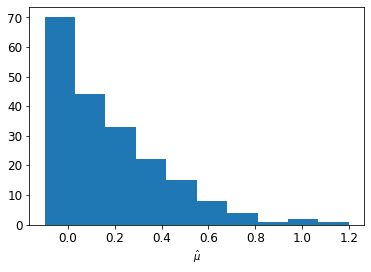

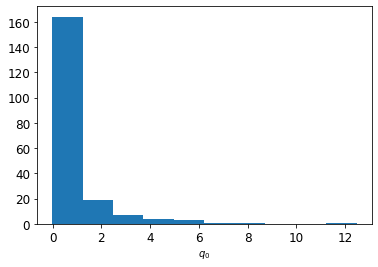

Z:0.28390059798180467
Z_std:2.7132660094149856
Z_1:2.495084484504053
Z_std_1:1.0784387952671315
1
AUC:0.9056913631788529
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

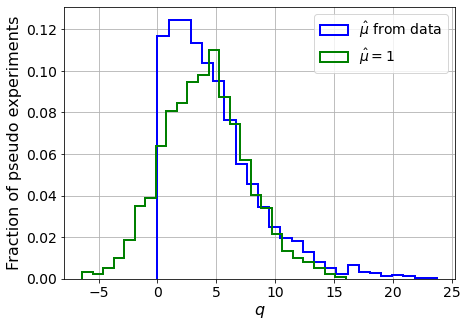

Z BL:(1.9960708085774423, 0.9504562454701302, 1.0175500000000002, 1.9967745886496187, 0.8941422089594764)


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  6180.55769474
  5952.35585675  5655.56603646  5288.40115749  4844.4745344
  4318.06467177  3688.53522169  2949.94748855  2033.88800107
   854.82719347  -652.65736239 -2533.92115072 -5228.48436287]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  4142.07473323  4141.00432468
 

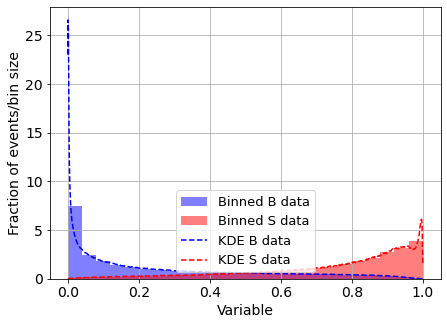

KDE Kernel:  epanechnikov
Background bandwidth:  0.0031053121543406503
Signal bandwidth:  0.0019008479046983867
This may take a while...
1 done
2 done
0.005533766143852072
0.005533766143852072
3 done
4 done
0.0020800655690255392
0.0020800655690255392
B_expected:  147986
S_expected:  202

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


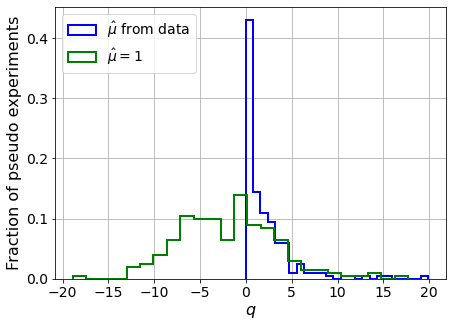

Z_MLL:  1.097814010243939
std Z_MLL:  1.3194450796976496


  3%|██                                                                  | 6/200 [00:08<03:39,  1.13s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4106411995903583
<p_{s}(Sdata)> = 2.1678240342924675
<p_{b}(Bdata)> = 4.778202611894008
<p_{s}(Bdata)> = 0.4158172897191482


  4%|██▋                                                                 | 8/200 [00:10<03:11,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41902900607255406
<p_{s}(Sdata)> = 1.9619898305461474
<p_{b}(Bdata)> = 4.741892686398398
<p_{s}(Bdata)> = 0.41904471094133855


  5%|███▎                                                               | 10/200 [00:11<02:41,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45199271584640177
<p_{s}(Sdata)> = 1.8965733259702582
<p_{b}(Bdata)> = 4.810385383957354
<p_{s}(Bdata)> = 0.4172736300103768


  7%|████▋                                                              | 14/200 [00:16<02:54,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42283555846145404
<p_{s}(Sdata)> = 1.9388078009621357
<p_{b}(Bdata)> = 4.797992994979263
<p_{s}(Bdata)> = 0.41764477619258206


 10%|███████                                                            | 21/200 [00:24<03:42,  1.24s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4248900735403136
<p_{s}(Sdata)> = 2.0257994086838838
<p_{b}(Bdata)> = 4.7725164357191545
<p_{s}(Bdata)> = 0.41732651050878633


 14%|█████████                                                          | 27/200 [00:31<02:50,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4419092789207308
<p_{s}(Sdata)> = 1.8882372971552797
<p_{b}(Bdata)> = 4.792123196791464
<p_{s}(Bdata)> = 0.4176817702127333


 16%|██████████▋                                                        | 32/200 [00:39<03:42,  1.32s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4661373766487057
<p_{s}(Sdata)> = 2.033912271652298
<p_{b}(Bdata)> = 4.74656309370071
<p_{s}(Bdata)> = 0.41906883589693794


 19%|████████████▋                                                      | 38/200 [00:46<02:57,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.40203791542675876
<p_{s}(Sdata)> = 2.0108388851154557
<p_{b}(Bdata)> = 4.809378698871227
<p_{s}(Bdata)> = 0.41647950338339285


 21%|██████████████                                                     | 42/200 [00:51<02:44,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4233757659012691
<p_{s}(Sdata)> = 2.0412756843061066
<p_{b}(Bdata)> = 4.787768157239897
<p_{s}(Bdata)> = 0.4170049141163167


 27%|██████████████████                                                 | 54/200 [01:06<02:22,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46506882752603806
<p_{s}(Sdata)> = 1.889620372930897
<p_{b}(Bdata)> = 4.828691706346065
<p_{s}(Bdata)> = 0.4177591790245765


 29%|███████████████████▍                                               | 58/200 [01:10<02:10,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4132289856114929
<p_{s}(Sdata)> = 1.9707529514094717
<p_{b}(Bdata)> = 4.76767122419527
<p_{s}(Bdata)> = 0.41924198684473446


 30%|███████████████████▊                                               | 59/200 [01:10<01:49,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38435350019325754
<p_{s}(Sdata)> = 2.0700324899838196
<p_{b}(Bdata)> = 4.79199917799267
<p_{s}(Bdata)> = 0.41623698051628183


 30%|████████████████████▍                                              | 61/200 [01:12<01:58,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4020128144231278
<p_{s}(Sdata)> = 2.074319818789667
<p_{b}(Bdata)> = 4.77043455580402
<p_{s}(Bdata)> = 0.41454807341013267


 38%|█████████████████████████▍                                         | 76/200 [01:34<02:31,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4441319346822778
<p_{s}(Sdata)> = 1.9491510146299007
<p_{b}(Bdata)> = 4.76439271675997
<p_{s}(Bdata)> = 0.4156920965505491


 40%|██████████████████████████▊                                        | 80/200 [01:39<02:10,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.42548360733880725
<p_{s}(Sdata)> = 2.007474178889591
<p_{b}(Bdata)> = 4.754749439077952
<p_{s}(Bdata)> = 0.4169176958876437


 46%|██████████████████████████████▍                                    | 91/200 [01:54<02:13,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.40475153035542744
<p_{s}(Sdata)> = 2.0477626695769584
<p_{b}(Bdata)> = 4.791068864413195
<p_{s}(Bdata)> = 0.41609534647164853


 46%|██████████████████████████████▊                                    | 92/200 [01:55<01:47,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3889930586955989
<p_{s}(Sdata)> = 2.0558945551401147
<p_{b}(Bdata)> = 4.741689141728923
<p_{s}(Bdata)> = 0.41687986520997034


 47%|███████████████████████████████▍                                   | 94/200 [01:56<01:33,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.438370373571184
<p_{s}(Sdata)> = 1.9276399059406577
<p_{b}(Bdata)> = 4.761888758379281
<p_{s}(Bdata)> = 0.41681477783742177


 48%|████████████████████████████████▍                                  | 97/200 [02:00<01:36,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4050295832997081
<p_{s}(Sdata)> = 2.026077833200661
<p_{b}(Bdata)> = 4.783653765639787
<p_{s}(Bdata)> = 0.41745141397830304


 52%|██████████████████████████████████▎                               | 104/200 [02:09<01:50,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.41636103393959356
<p_{s}(Sdata)> = 1.9877838784216342
<p_{b}(Bdata)> = 4.75075325575722
<p_{s}(Bdata)> = 0.4179283096130313


 52%|██████████████████████████████████▋                               | 105/200 [02:10<01:29,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47006749425492933
<p_{s}(Sdata)> = 1.9371894708434125
<p_{b}(Bdata)> = 4.777213581229277
<p_{s}(Bdata)> = 0.4210611212141619


 55%|████████████████████████████████████▎                             | 110/200 [02:16<01:26,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5248368209674672
<p_{s}(Sdata)> = 1.861511596071898
<p_{b}(Bdata)> = 4.746634949150238
<p_{s}(Bdata)> = 0.4186054743915771


 56%|████████████████████████████████████▉                             | 112/200 [02:17<01:12,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4319682178072623
<p_{s}(Sdata)> = 1.9596214431057346
<p_{b}(Bdata)> = 4.762022751658153
<p_{s}(Bdata)> = 0.41618341019956623


 60%|███████████████████████████████████████▉                          | 121/200 [02:28<01:12,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42938354986548877
<p_{s}(Sdata)> = 2.033150378686554
<p_{b}(Bdata)> = 4.801448447359989
<p_{s}(Bdata)> = 0.4176214568795065


 66%|███████████████████████████████████████████▌                      | 132/200 [02:43<01:09,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.47141615570848605
<p_{s}(Sdata)> = 2.0413215849229847
<p_{b}(Bdata)> = 4.8306734777319855
<p_{s}(Bdata)> = 0.41133809975056107


 68%|████████████████████████████████████████████▉                     | 136/200 [02:47<01:05,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.39221859310031204
<p_{s}(Sdata)> = 2.130422850897295
<p_{b}(Bdata)> = 4.836478715899552
<p_{s}(Bdata)> = 0.417690445858437


 68%|█████████████████████████████████████████████▏                    | 137/200 [02:47<00:53,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4396190487283253
<p_{s}(Sdata)> = 1.8516440769078384
<p_{b}(Bdata)> = 4.764171515828524
<p_{s}(Bdata)> = 0.41979436692012306


 69%|█████████████████████████████████████████████▌                    | 138/200 [02:48<00:45,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43112851242274886
<p_{s}(Sdata)> = 1.8746017455174069
<p_{b}(Bdata)> = 4.770802905985997
<p_{s}(Bdata)> = 0.41729133323441797


 75%|█████████████████████████████████████████████████▌                | 150/200 [03:03<00:54,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.42899993833183275
<p_{s}(Sdata)> = 1.9360528655483809
<p_{b}(Bdata)> = 4.766662733185228
<p_{s}(Bdata)> = 0.4199901097685146


 78%|███████████████████████████████████████████████████▍              | 156/200 [03:12<00:53,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.41079244537136633
<p_{s}(Sdata)> = 1.9986700729321762
<p_{b}(Bdata)> = 4.777692496947757
<p_{s}(Bdata)> = 0.41899498712607297


 78%|███████████████████████████████████████████████████▊              | 157/200 [03:12<00:42,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41760510495068215
<p_{s}(Sdata)> = 1.9467471469134832
<p_{b}(Bdata)> = 4.7529902324849855
<p_{s}(Bdata)> = 0.4200129956728386


 84%|███████████████████████████████████████████████████████▍          | 168/200 [03:27<00:33,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.43411877462715037
<p_{s}(Sdata)> = 1.926025302748161
<p_{b}(Bdata)> = 4.768824683262773
<p_{s}(Bdata)> = 0.41809805095849956


 91%|████████████████████████████████████████████████████████████      | 182/200 [03:46<00:20,  1.12s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.43966446944864424
<p_{s}(Sdata)> = 2.037676152015751
<p_{b}(Bdata)> = 4.773664074286475
<p_{s}(Bdata)> = 0.4180215915712992


 93%|█████████████████████████████████████████████████████████████▍    | 186/200 [03:50<00:13,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47729362501965156
<p_{s}(Sdata)> = 1.9351032301783027
<p_{b}(Bdata)> = 4.778065578066438
<p_{s}(Bdata)> = 0.418631158511849


 94%|█████████████████████████████████████████████████████████████▋    | 187/200 [03:51<00:10,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41363635082933387
<p_{s}(Sdata)> = 2.020322012199183
<p_{b}(Bdata)> = 4.770064695196096
<p_{s}(Bdata)> = 0.4174193963141742


 96%|███████████████████████████████████████████████████████████████▎  | 192/200 [03:56<00:07,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4448234753871989
<p_{s}(Sdata)> = 1.9131156104345721
<p_{b}(Bdata)> = 4.782097417718001
<p_{s}(Bdata)> = 0.41649137627518246


 98%|█████████████████████████████████████████████████████████████████ | 197/200 [04:05<00:04,  1.35s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.43156440335189783
<p_{s}(Sdata)> = 1.9407348301569554
<p_{b}(Bdata)> = 4.799737556617846
<p_{s}(Bdata)> = 0.41656961976687285


100%|██████████████████████████████████████████████████████████████████| 200/200 [04:08<00:00,  1.24s/it]


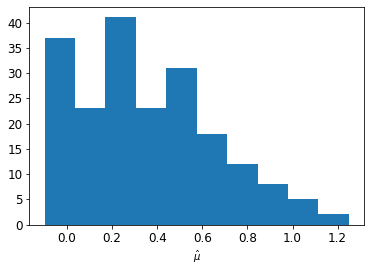

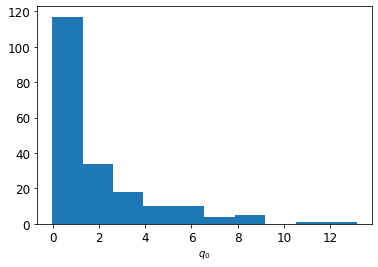

Z:0.9183105048030975
Z_std:1.280614391655558
Z_1:1.7165505241262264
Z_std_1:1.6178646746253438
2
AUC:0.9046247108983135
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

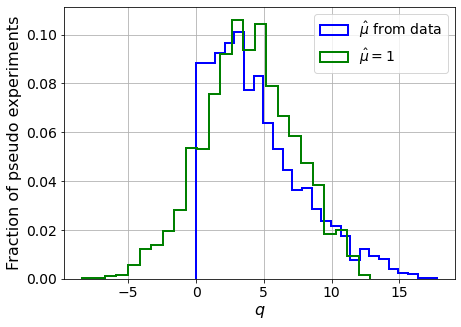

Z BL:(1.9564724197187848, 0.8646220317655645, 1.00735, 1.9564724197187848, 0.8662778494860481)


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
  5628.84292642  5347.9029892   4993.46499992  4572.41579295
  4070.16565439  3473.10192563  2744.51031889  1838.88181236
   704.17393594  -744.93985058 -2568.41227809 -5243.3174517 ]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  4078.23025776  4084.07735299


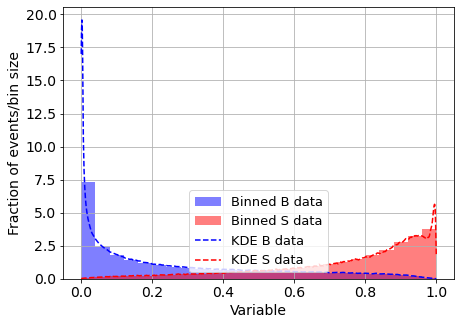

KDE Kernel:  epanechnikov
Background bandwidth:  0.005072980090653727
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.006636708801355598
0.006636708801355598
3 done
4 done
0.0034602519958785863
0.0034602519958785863
B_expected:  147986
S_expected:  202

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


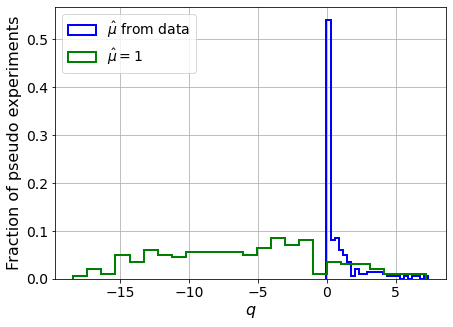

Z_MLL:  0.3612830598039618
std Z_MLL:  1.9318853161953404


  1%|▋                                                                   | 2/200 [00:01<02:52,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4181156657505218
<p_{s}(Sdata)> = 2.055736825060588
<p_{b}(Bdata)> = 4.123481691317012
<p_{s}(Bdata)> = 0.41914434592891164


  2%|█▋                                                                  | 5/200 [00:04<02:40,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4481255831685697
<p_{s}(Sdata)> = 2.0772655152780755
<p_{b}(Bdata)> = 4.103351608877921
<p_{s}(Bdata)> = 0.4217936588969315


  3%|██                                                                  | 6/200 [00:05<02:15,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4198387680655013
<p_{s}(Sdata)> = 1.984802405702307
<p_{b}(Bdata)> = 4.141412381794267
<p_{s}(Bdata)> = 0.4180337812028477


  4%|██▍                                                                 | 7/200 [00:05<02:00,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4328325855702481
<p_{s}(Sdata)> = 2.0058385596807518
<p_{b}(Bdata)> = 4.1070596618995205
<p_{s}(Bdata)> = 0.42237628181251824


  6%|███▋                                                               | 11/200 [00:09<02:46,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4360406643747121
<p_{s}(Sdata)> = 2.1552763906161836
<p_{b}(Bdata)> = 4.113361472761207
<p_{s}(Bdata)> = 0.4194991518361927


  7%|████▋                                                              | 14/200 [00:12<02:40,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5002104909273205
<p_{s}(Sdata)> = 1.9290209614148246
<p_{b}(Bdata)> = 4.1164353966243175
<p_{s}(Bdata)> = 0.42118323675740715


  8%|█████▋                                                             | 17/200 [00:15<02:17,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4604783665775307
<p_{s}(Sdata)> = 1.9993176874641954
<p_{b}(Bdata)> = 4.117057546165886
<p_{s}(Bdata)> = 0.42317848164070676


 10%|██████▎                                                            | 19/200 [00:16<02:23,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4846253325381863
<p_{s}(Sdata)> = 1.9218539513506752
<p_{b}(Bdata)> = 4.145356036485914
<p_{s}(Bdata)> = 0.4195984317368065


 12%|███████▋                                                           | 23/200 [00:20<02:27,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.438423356431141
<p_{s}(Sdata)> = 1.9310515855200743
<p_{b}(Bdata)> = 4.096271006537422
<p_{s}(Bdata)> = 0.42492494269506303


 12%|████████                                                           | 24/200 [00:21<02:07,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4367227790734699
<p_{s}(Sdata)> = 2.00290304093271
<p_{b}(Bdata)> = 4.1132325985295966
<p_{s}(Bdata)> = 0.42163926587732553


 14%|█████████▋                                                         | 29/200 [00:27<02:51,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4147249790838243
<p_{s}(Sdata)> = 1.968133677113927
<p_{b}(Bdata)> = 4.097985699068364
<p_{s}(Bdata)> = 0.42296441663033635


 15%|██████████                                                         | 30/200 [00:27<02:22,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4691523991518451
<p_{s}(Sdata)> = 1.9426512073290856
<p_{b}(Bdata)> = 4.11923701968032
<p_{s}(Bdata)> = 0.4233972412311541


 16%|███████████                                                        | 33/200 [00:30<02:41,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4751297654918872
<p_{s}(Sdata)> = 1.9344941441971237
<p_{b}(Bdata)> = 4.119590106710691
<p_{s}(Bdata)> = 0.42270538516897627


 17%|███████████▍                                                       | 34/200 [00:31<02:15,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4003714528598845
<p_{s}(Sdata)> = 2.048511958203421
<p_{b}(Bdata)> = 4.11750127749192
<p_{s}(Bdata)> = 0.4207852530890879


 18%|███████████▋                                                       | 35/200 [00:31<01:57,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47428427943278384
<p_{s}(Sdata)> = 1.878695538888514
<p_{b}(Bdata)> = 4.106474485361404
<p_{s}(Bdata)> = 0.4229468625091407


 19%|████████████▋                                                      | 38/200 [00:35<02:37,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43225990781257273
<p_{s}(Sdata)> = 2.0184516674218362
<p_{b}(Bdata)> = 4.113812772578996
<p_{s}(Bdata)> = 0.42080815502163327


 20%|█████████████▍                                                     | 40/200 [00:37<02:24,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40467219239353125
<p_{s}(Sdata)> = 2.0300289433707
<p_{b}(Bdata)> = 4.126003259467975
<p_{s}(Bdata)> = 0.4222661795162656


 21%|██████████████                                                     | 42/200 [00:38<02:04,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4319290810249266
<p_{s}(Sdata)> = 1.95216154621534
<p_{b}(Bdata)> = 4.103425981680832
<p_{s}(Bdata)> = 0.4221773994691955


 22%|██████████████▍                                                    | 43/200 [00:39<01:48,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4470998431237791
<p_{s}(Sdata)> = 1.9091698214168042
<p_{b}(Bdata)> = 4.127754742609792
<p_{s}(Bdata)> = 0.4213395903775904


 22%|██████████████▋                                                    | 44/200 [00:39<01:37,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4486925310670421
<p_{s}(Sdata)> = 1.9309134317949384
<p_{b}(Bdata)> = 4.1211647632624056
<p_{s}(Bdata)> = 0.4214361750128902


 22%|███████████████                                                    | 45/200 [00:40<01:28,  1.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4393451603250712
<p_{s}(Sdata)> = 1.9482911798014597
<p_{b}(Bdata)> = 4.083016293633394
<p_{s}(Bdata)> = 0.42260770343080906


 25%|████████████████▊                                                  | 50/200 [00:45<02:16,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4510612402083112
<p_{s}(Sdata)> = 1.968401376079733
<p_{b}(Bdata)> = 4.120625645387233
<p_{s}(Bdata)> = 0.4205814461108766


 26%|█████████████████▍                                                 | 52/200 [00:46<01:52,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46981002004863076
<p_{s}(Sdata)> = 1.9266548211932253
<p_{b}(Bdata)> = 4.092545248382791
<p_{s}(Bdata)> = 0.42129853136333506


 26%|█████████████████▊                                                 | 53/200 [00:47<01:38,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4368201039251706
<p_{s}(Sdata)> = 1.8965333795995458
<p_{b}(Bdata)> = 4.102217231128709
<p_{s}(Bdata)> = 0.4214067991405442


 28%|███████████████████                                                | 57/200 [00:52<02:29,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5053301601887671
<p_{s}(Sdata)> = 1.9119965031346327
<p_{b}(Bdata)> = 4.118846925135769
<p_{s}(Bdata)> = 0.42173002732994747


 29%|███████████████████▍                                               | 58/200 [00:52<02:03,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.451110290796558
<p_{s}(Sdata)> = 1.9708212710940416
<p_{b}(Bdata)> = 4.0861190427340945
<p_{s}(Bdata)> = 0.4222060174014654


 30%|███████████████████▊                                               | 59/200 [00:53<01:46,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41136154776455586
<p_{s}(Sdata)> = 1.967707194180672
<p_{b}(Bdata)> = 4.1138555414290625
<p_{s}(Bdata)> = 0.4214744024255005


 33%|██████████████████████                                             | 66/200 [01:01<02:17,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.45096864120651253
<p_{s}(Sdata)> = 1.8806351046069187
<p_{b}(Bdata)> = 4.134887961051216
<p_{s}(Bdata)> = 0.42282285099591477


 34%|██████████████████████▍                                            | 67/200 [01:02<01:53,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46762232951135063
<p_{s}(Sdata)> = 1.9181235979411857
<p_{b}(Bdata)> = 4.113129502035101
<p_{s}(Bdata)> = 0.4225938223328401


 34%|███████████████████████                                            | 69/200 [01:03<01:44,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4378334052705507
<p_{s}(Sdata)> = 2.057377274392885
<p_{b}(Bdata)> = 4.118756354980911
<p_{s}(Bdata)> = 0.4205829533823987


 35%|███████████████████████▍                                           | 70/200 [01:04<01:30,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43722863805490336
<p_{s}(Sdata)> = 1.8875683340917968
<p_{b}(Bdata)> = 4.1006542583577
<p_{s}(Bdata)> = 0.4216294080624917


 36%|████████████████████████                                           | 72/200 [01:05<01:38,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3839522329058124
<p_{s}(Sdata)> = 2.1243311053899876
<p_{b}(Bdata)> = 4.108211672514474
<p_{s}(Bdata)> = 0.4216664178279465


 37%|████████████████████████▊                                          | 74/200 [01:07<01:26,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4030094421429196
<p_{s}(Sdata)> = 1.9977678425203491
<p_{b}(Bdata)> = 4.099961742686871
<p_{s}(Bdata)> = 0.42172971966739187


 38%|█████████████████████████▏                                         | 75/200 [01:07<01:17,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45904751581144604
<p_{s}(Sdata)> = 1.9226439647371605
<p_{b}(Bdata)> = 4.123495974316287
<p_{s}(Bdata)> = 0.41958868112271874


 38%|█████████████████████████▍                                         | 76/200 [01:08<01:11,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4481530630557937
<p_{s}(Sdata)> = 1.9521512673151018
<p_{b}(Bdata)> = 4.0975303996593855
<p_{s}(Bdata)> = 0.42317004110460593


 40%|██████████████████████████▊                                        | 80/200 [01:12<01:42,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4731657508739768
<p_{s}(Sdata)> = 1.9498699050341535
<p_{b}(Bdata)> = 4.120996569876778
<p_{s}(Bdata)> = 0.42225605256987536


 41%|███████████████████████████▍                                       | 82/200 [01:14<01:46,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42307624962721574
<p_{s}(Sdata)> = 2.1201317610268924
<p_{b}(Bdata)> = 4.1350382387260725
<p_{s}(Bdata)> = 0.4212815396399886


 42%|███████████████████████████▊                                       | 83/200 [01:15<01:30,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45314545683484486
<p_{s}(Sdata)> = 1.9277440346527057
<p_{b}(Bdata)> = 4.119264510827052
<p_{s}(Bdata)> = 0.4198886542820249


 42%|████████████████████████████▏                                      | 84/200 [01:15<01:18,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4626714226775636
<p_{s}(Sdata)> = 1.9172210000868657
<p_{b}(Bdata)> = 4.101572286720723
<p_{s}(Bdata)> = 0.4213234633394596


 42%|████████████████████████████▍                                      | 85/200 [01:16<01:10,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42785035870300675
<p_{s}(Sdata)> = 1.9915903056753224
<p_{b}(Bdata)> = 4.134340493560838
<p_{s}(Bdata)> = 0.4207794565912018


 43%|████████████████████████████▊                                      | 86/200 [01:16<01:04,  1.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43314547781411106
<p_{s}(Sdata)> = 2.0072078070987147
<p_{b}(Bdata)> = 4.0724687946975395
<p_{s}(Bdata)> = 0.4240957201952835


 44%|█████████████████████████████▏                                     | 87/200 [01:16<01:00,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4633646470070197
<p_{s}(Sdata)> = 1.9832401366847037
<p_{b}(Bdata)> = 4.096583589225117
<p_{s}(Bdata)> = 0.42355748041866026


 45%|██████████████████████████████▏                                    | 90/200 [01:20<01:39,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4498063929225042
<p_{s}(Sdata)> = 1.8826829652331711
<p_{b}(Bdata)> = 4.121575927466943
<p_{s}(Bdata)> = 0.42375709080386664


 48%|███████████████████████████████▊                                   | 95/200 [01:27<01:50,  1.05s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.427801413699618
<p_{s}(Sdata)> = 2.0264725338181933
<p_{b}(Bdata)> = 4.118546730353214
<p_{s}(Bdata)> = 0.42128174870644036


 48%|████████████████████████████████▏                                  | 96/200 [01:27<01:31,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38997696096850115
<p_{s}(Sdata)> = 2.1302893331924486
<p_{b}(Bdata)> = 4.095337897771133
<p_{s}(Bdata)> = 0.42358232505653537


 48%|████████████████████████████████▍                                  | 97/200 [01:28<01:17,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4145547400780569
<p_{s}(Sdata)> = 1.9504131255453758
<p_{b}(Bdata)> = 4.110249892301833
<p_{s}(Bdata)> = 0.4202212110289446


 49%|████████████████████████████████▊                                  | 98/200 [01:28<01:07,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4594421941451206
<p_{s}(Sdata)> = 1.941533914981026
<p_{b}(Bdata)> = 4.126565848996396
<p_{s}(Bdata)> = 0.4196105442625438


 52%|██████████████████████████████████▎                               | 104/200 [01:36<01:34,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45516360167784475
<p_{s}(Sdata)> = 1.9954075166975298
<p_{b}(Bdata)> = 4.1221154691928295
<p_{s}(Bdata)> = 0.422046944562227


 53%|██████████████████████████████████▉                               | 106/200 [01:38<01:23,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3861185870802074
<p_{s}(Sdata)> = 2.097505357337522
<p_{b}(Bdata)> = 4.123611503565021
<p_{s}(Bdata)> = 0.422196864031664


 54%|███████████████████████████████████▎                              | 107/200 [01:38<01:11,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4240690122672842
<p_{s}(Sdata)> = 1.9335669240897018
<p_{b}(Bdata)> = 4.1231175192048495
<p_{s}(Bdata)> = 0.4212768993923234


 55%|████████████████████████████████████▎                             | 110/200 [01:41<01:12,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4083262194571935
<p_{s}(Sdata)> = 2.033216542008205
<p_{b}(Bdata)> = 4.104897029531162
<p_{s}(Bdata)> = 0.4199562941675824


 56%|█████████████████████████████████████▎                            | 113/200 [01:45<01:30,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4066489709619715
<p_{s}(Sdata)> = 2.046029680210961
<p_{b}(Bdata)> = 4.090560699087267
<p_{s}(Bdata)> = 0.4227767511033666


 57%|█████████████████████████████████████▌                            | 114/200 [01:45<01:14,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39976174474449333
<p_{s}(Sdata)> = 2.0240821945719327
<p_{b}(Bdata)> = 4.119762970604416
<p_{s}(Bdata)> = 0.4209449885631853


 57%|█████████████████████████████████████▉                            | 115/200 [01:46<01:03,  1.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4165319807763253
<p_{s}(Sdata)> = 2.1264301723545356
<p_{b}(Bdata)> = 4.090628511492967
<p_{s}(Bdata)> = 0.42309393112604815


 58%|██████████████████████████████████████▎                           | 116/200 [01:46<00:55,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4008093887580929
<p_{s}(Sdata)> = 2.067404519890379
<p_{b}(Bdata)> = 4.104613984183401
<p_{s}(Bdata)> = 0.4220910699389646


 58%|██████████████████████████████████████▌                           | 117/200 [01:47<00:50,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5423647161928936
<p_{s}(Sdata)> = 1.984800019982445
<p_{b}(Bdata)> = 4.111489006481892
<p_{s}(Bdata)> = 0.422521060753501


 59%|██████████████████████████████████████▉                           | 118/200 [01:47<00:46,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4928036109097191
<p_{s}(Sdata)> = 2.0405439182642517
<p_{b}(Bdata)> = 4.124252623253018
<p_{s}(Bdata)> = 0.4219405123139441


 60%|███████████████████████████████████████▎                          | 119/200 [01:47<00:43,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4002312072989836
<p_{s}(Sdata)> = 2.1403167088688955
<p_{b}(Bdata)> = 4.153637794678551
<p_{s}(Bdata)> = 0.421401206286374


 63%|█████████████████████████████████████████▌                        | 126/200 [01:56<01:14,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4413860397497615
<p_{s}(Sdata)> = 1.9417073379319514
<p_{b}(Bdata)> = 4.077830218556973
<p_{s}(Bdata)> = 0.42370315468214054


 64%|█████████████████████████████████████████▉                        | 127/200 [01:56<01:01,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4234683471537358
<p_{s}(Sdata)> = 2.0667251369225688
<p_{b}(Bdata)> = 4.0675747454626
<p_{s}(Bdata)> = 0.42296796511833745


 64%|██████████████████████████████████████████▏                       | 128/200 [01:57<00:52,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3894814472461007
<p_{s}(Sdata)> = 2.1159257461040117
<p_{b}(Bdata)> = 4.111571016387112
<p_{s}(Bdata)> = 0.42122539470779863


 65%|██████████████████████████████████████████▉                       | 130/200 [01:59<00:55,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5200604537346063
<p_{s}(Sdata)> = 2.1481630168410093
<p_{b}(Bdata)> = 4.106463916889213
<p_{s}(Bdata)> = 0.42310737186969866


 68%|████████████████████████████████████████████▌                     | 135/200 [02:04<00:53,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41365753913491715
<p_{s}(Sdata)> = 2.0028514702726197
<p_{b}(Bdata)> = 4.094586803572331
<p_{s}(Bdata)> = 0.421233669100302


 71%|██████████████████████████████████████████████▊                   | 142/200 [02:12<00:57,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4936022553821888
<p_{s}(Sdata)> = 1.781159251749578
<p_{b}(Bdata)> = 4.133558420663169
<p_{s}(Bdata)> = 0.41887621357062493


 72%|███████████████████████████████████████████████▌                  | 144/200 [02:14<00:45,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42310917112265706
<p_{s}(Sdata)> = 1.9837001867124828
<p_{b}(Bdata)> = 4.107771620075327
<p_{s}(Bdata)> = 0.4223832861046447


 74%|█████████████████████████████████████████████████▏                | 149/200 [02:20<00:52,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4552912111790167
<p_{s}(Sdata)> = 1.9172071702371007
<p_{b}(Bdata)> = 4.102546630735252
<p_{s}(Bdata)> = 0.42434468544353426


 75%|█████████████████████████████████████████████████▌                | 150/200 [02:21<00:42,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4555109544156265
<p_{s}(Sdata)> = 1.891582998572964
<p_{b}(Bdata)> = 4.11875693628889
<p_{s}(Bdata)> = 0.42164091362724404


 76%|█████████████████████████████████████████████████▊                | 151/200 [02:21<00:36,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4388989007954553
<p_{s}(Sdata)> = 1.9890799726678001
<p_{b}(Bdata)> = 4.122285338263849
<p_{s}(Bdata)> = 0.4204546773028367


 77%|██████████████████████████████████████████████████▊               | 154/200 [02:24<00:42,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4630253347903285
<p_{s}(Sdata)> = 1.767947342108229
<p_{b}(Bdata)> = 4.100004314843622
<p_{s}(Bdata)> = 0.4240070680216425


 78%|███████████████████████████████████████████████████▊              | 157/200 [02:27<00:35,  1.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4012454418001802
<p_{s}(Sdata)> = 2.011491031282838
<p_{b}(Bdata)> = 4.105604898567491
<p_{s}(Bdata)> = 0.42027412295183986


 79%|████████████████████████████████████████████████████▏             | 158/200 [02:27<00:30,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4442439247272668
<p_{s}(Sdata)> = 1.8426918215556285
<p_{b}(Bdata)> = 4.095698741474336
<p_{s}(Bdata)> = 0.42148890003306844


 80%|████████████████████████████████████████████████████▊             | 160/200 [02:30<00:34,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4020450200105763
<p_{s}(Sdata)> = 1.9806990316432038
<p_{b}(Bdata)> = 4.0854644659232235
<p_{s}(Bdata)> = 0.4246143186413538


 81%|█████████████████████████████████████████████████████▍            | 162/200 [02:31<00:31,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42418259347218973
<p_{s}(Sdata)> = 1.9428832636410152
<p_{b}(Bdata)> = 4.108268411714823
<p_{s}(Bdata)> = 0.4231759920392562


 82%|█████████████████████████████████████████████████████▊            | 163/200 [02:32<00:26,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4445963968488343
<p_{s}(Sdata)> = 1.9364526114070764
<p_{b}(Bdata)> = 4.101361086303717
<p_{s}(Bdata)> = 0.42196226032796497


 82%|██████████████████████████████████████████████████████            | 164/200 [02:32<00:22,  1.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49292414944705676
<p_{s}(Sdata)> = 1.987623388700663
<p_{b}(Bdata)> = 4.085316184000907
<p_{s}(Bdata)> = 0.42293073939476217


 82%|██████████████████████████████████████████████████████▍           | 165/200 [02:33<00:20,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43442372332535767
<p_{s}(Sdata)> = 1.9320106084321078
<p_{b}(Bdata)> = 4.104392227584418
<p_{s}(Bdata)> = 0.4203929263382009


 83%|██████████████████████████████████████████████████████▊           | 166/200 [02:33<00:18,  1.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4738489458666618
<p_{s}(Sdata)> = 1.852021503019733
<p_{b}(Bdata)> = 4.1192668893653925
<p_{s}(Bdata)> = 0.4224804254242013


 84%|███████████████████████████████████████████████████████▍          | 168/200 [02:35<00:24,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4438096063116053
<p_{s}(Sdata)> = 1.9776396949015542
<p_{b}(Bdata)> = 4.097114554830591
<p_{s}(Bdata)> = 0.4220497674755049


 85%|████████████████████████████████████████████████████████          | 170/200 [02:37<00:21,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4340014905165583
<p_{s}(Sdata)> = 2.0163942403630126
<p_{b}(Bdata)> = 4.0975921930231065
<p_{s}(Bdata)> = 0.42234158859139354


 88%|█████████████████████████████████████████████████████████▊        | 175/200 [02:43<00:23,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42141721902366674
<p_{s}(Sdata)> = 2.059792591506968
<p_{b}(Bdata)> = 4.104607504592922
<p_{s}(Bdata)> = 0.42268474454976857


 92%|████████████████████████████████████████████████████████████▍     | 183/200 [02:53<00:19,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4530134776519603
<p_{s}(Sdata)> = 1.9337465516524017
<p_{b}(Bdata)> = 4.109448100460578
<p_{s}(Bdata)> = 0.4215585591938546


 93%|█████████████████████████████████████████████████████████████▍    | 186/200 [02:57<00:14,  1.06s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.5185678126171694
<p_{s}(Sdata)> = 1.7031917092309996
<p_{b}(Bdata)> = 4.082395004448633
<p_{s}(Bdata)> = 0.4220421456149364


 94%|█████████████████████████████████████████████████████████████▋    | 187/200 [02:57<00:11,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4615409717688346
<p_{s}(Sdata)> = 1.9655613950112047
<p_{b}(Bdata)> = 4.098731624347406
<p_{s}(Bdata)> = 0.42046686016424345


 96%|███████████████████████████████████████████████████████████████   | 191/200 [03:01<00:07,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4276335885338447
<p_{s}(Sdata)> = 1.9736678808789883
<p_{b}(Bdata)> = 4.106523382461395
<p_{s}(Bdata)> = 0.42208616307049446


 98%|████████████████████████████████████████████████████████████████▎ | 195/200 [03:04<00:03,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4184140380740728
<p_{s}(Sdata)> = 2.0474996363806737
<p_{b}(Bdata)> = 4.08358057781302
<p_{s}(Bdata)> = 0.42314475582572453


100%|██████████████████████████████████████████████████████████████████| 200/200 [03:11<00:00,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4361344285446319
<p_{s}(Sdata)> = 2.0855224127059966
<p_{b}(Bdata)> = 4.12443610367512
<p_{s}(Bdata)> = 0.4220420343155952


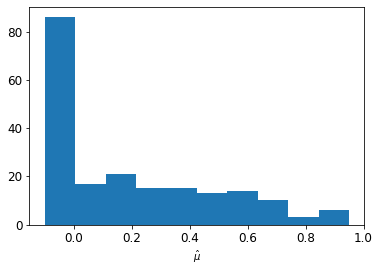

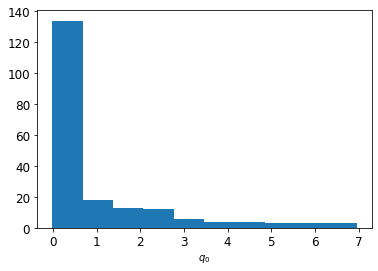

Z:0.24904484599332513
Z_std:3.0909624315420317
Z_1:2.535683681732767
Z_std_1:1.1804907309775208
3
AUC:0.9049536154845473
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

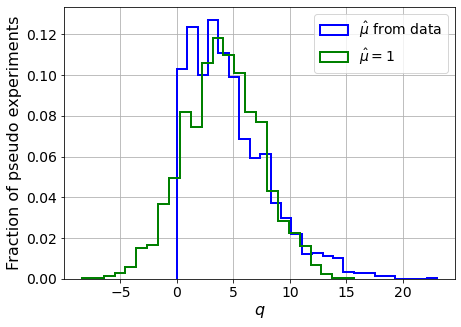

Z BL:(2.0052084391166343, 0.8740642897513978, 1.020475, 2.005270520225358, 0.8519320297005257)


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  6230.39884165  6054.2530354
  5820.92501984  5533.20172607  5175.14383177  4744.37857516
  4226.24256725  3621.00713185  2891.12268269  1979.30848328
   810.13521619  -696.22444324 -2575.67592174 -5247.29719241]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  4070.63338042  4093.0750643   4093.64705679
 

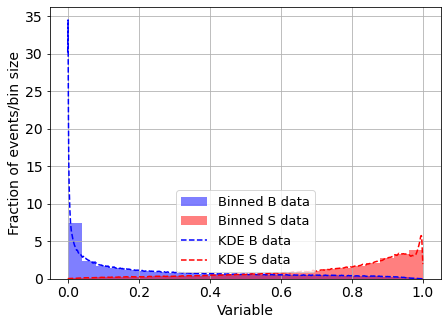

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.004700948204091118
0.004700948204091118
3 done
4 done
0.0017255927724005374
0.0017255927724005374
B_expected:  147986
S_expected:  202

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


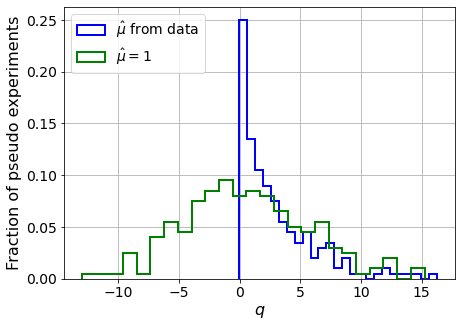

Z_MLL:  1.4432199785201003
std Z_MLL:  1.1100925385961868


  6%|████▎                                                              | 13/200 [00:20<04:05,  1.31s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.429506203428778
<p_{s}(Sdata)> = 1.9553287134909672
<p_{b}(Bdata)> = 5.2138417128301775
<p_{s}(Bdata)> = 0.41791492667613417


 15%|██████████                                                         | 30/200 [00:46<03:40,  1.30s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.49700390403499284
<p_{s}(Sdata)> = 1.8249883955714965
<p_{b}(Bdata)> = 5.208881756252211
<p_{s}(Bdata)> = 0.42037002092238995


 18%|████████████▍                                                      | 37/200 [00:56<03:20,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.43017541558185063
<p_{s}(Sdata)> = 2.04735157620531
<p_{b}(Bdata)> = 5.190874049663932
<p_{s}(Bdata)> = 0.4202463543392712


 22%|██████████████▋                                                    | 44/200 [01:06<02:51,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.45052687021798077
<p_{s}(Sdata)> = 1.904740777530019
<p_{b}(Bdata)> = 5.24668942540508
<p_{s}(Bdata)> = 0.41882033669295343


 28%|███████████████████                                                | 57/200 [01:25<02:58,  1.25s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4490106567919819
<p_{s}(Sdata)> = 1.8811366669894425
<p_{b}(Bdata)> = 5.2414861996033295
<p_{s}(Bdata)> = 0.4208791964690489


 29%|███████████████████▍                                               | 58/200 [01:26<02:22,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.43804381713126367
<p_{s}(Sdata)> = 1.9037839876305014
<p_{b}(Bdata)> = 5.2362447509601955
<p_{s}(Bdata)> = 0.41843415239279713


 38%|█████████████████████████▊                                         | 77/200 [01:51<02:25,  1.18s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.43227965251539263
<p_{s}(Sdata)> = 2.0481805111646514
<p_{b}(Bdata)> = 5.247820709003462
<p_{s}(Bdata)> = 0.42051248659314416


 47%|███████████████████████████████▍                                   | 94/200 [02:12<01:53,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3970375911016116
<p_{s}(Sdata)> = 2.193926776221811
<p_{b}(Bdata)> = 5.2402417181168035
<p_{s}(Bdata)> = 0.42009769333540303


 49%|████████████████████████████████▊                                  | 98/200 [02:17<01:51,  1.09s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4951842326498645
<p_{s}(Sdata)> = 1.7517538899928644
<p_{b}(Bdata)> = 5.2163537659063905
<p_{s}(Bdata)> = 0.4236453553110758


 54%|███████████████████████████████████▋                              | 108/200 [02:32<01:57,  1.28s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.45885912611515994
<p_{s}(Sdata)> = 1.850526036380125
<p_{b}(Bdata)> = 5.261254675006329
<p_{s}(Bdata)> = 0.4196629189824934


 55%|████████████████████████████████████▎                             | 110/200 [02:34<01:28,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44323555829285977
<p_{s}(Sdata)> = 2.0253959777883814
<p_{b}(Bdata)> = 5.218513171020596
<p_{s}(Bdata)> = 0.42013101954527626


 65%|██████████████████████████████████████████▉                       | 130/200 [03:02<01:21,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4139059235649514
<p_{s}(Sdata)> = 1.9680818279435828
<p_{b}(Bdata)> = 5.214298216974127
<p_{s}(Bdata)> = 0.41793006078778716


 82%|██████████████████████████████████████████████████████            | 164/200 [03:52<00:36,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.43570387818688155
<p_{s}(Sdata)> = 1.888119711609837
<p_{b}(Bdata)> = 5.227085582546245
<p_{s}(Bdata)> = 0.4188312945127341


 86%|████████████████████████████████████████████████████████▊         | 172/200 [04:03<00:30,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3831599877716028
<p_{s}(Sdata)> = 2.0526034141053158
<p_{b}(Bdata)> = 5.216596043108323
<p_{s}(Bdata)> = 0.42021574163140546


 93%|█████████████████████████████████████████████████████████████▍    | 186/200 [04:25<00:16,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.46451776081245366
<p_{s}(Sdata)> = 1.8570217023188695
<p_{b}(Bdata)> = 5.208459900420418
<p_{s}(Bdata)> = 0.42182253561655797


 95%|██████████████████████████████████████████████████████████████▋   | 190/200 [04:29<00:10,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4328840166352346
<p_{s}(Sdata)> = 1.9464473803212832
<p_{b}(Bdata)> = 5.221146088609878
<p_{s}(Bdata)> = 0.4223725592650536


 96%|███████████████████████████████████████████████████████████████▋  | 193/200 [04:32<00:06,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4239277461008238
<p_{s}(Sdata)> = 1.986029616635405
<p_{b}(Bdata)> = 5.244288431771206
<p_{s}(Bdata)> = 0.4172402538198389


100%|██████████████████████████████████████████████████████████████████| 200/200 [04:43<00:00,  1.42s/it]


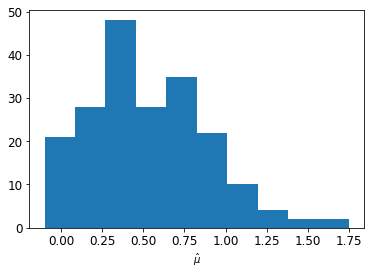

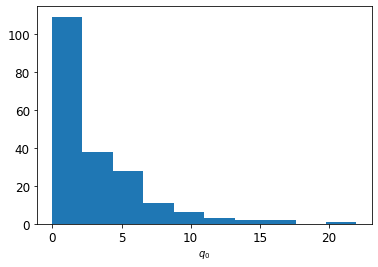

Z:1.370160223411963
Z_std:1.307305028906257
Z_1:0.3234035365410715
Z_std_1:8.697874878936117
4
AUC:0.9041030994041425
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

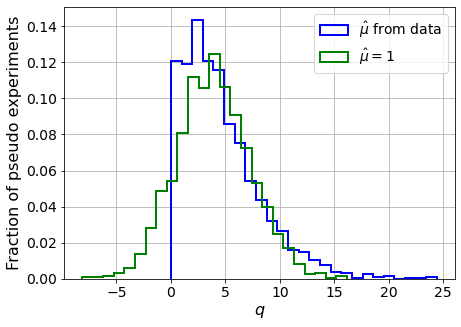

Z BL:(1.9679544753448515, 0.9008006231134466, 1.014775, 1.9679544753448515, 0.8569074010655136)


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
  5715.61405801  5442.93296909  5102.52606162  4680.73730129
  4170.41142641  3559.35701602  2828.80755579  1919.93755691
   760.48465515  -722.90268431 -2579.74388175 -5248.0260193 ]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  4068.52703819  4075.88666745


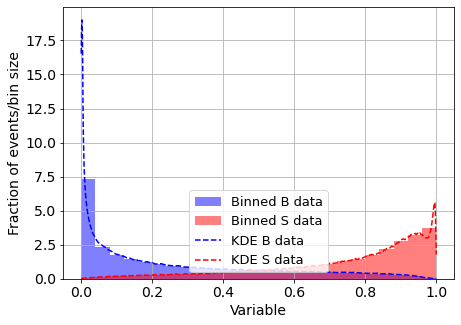

KDE Kernel:  epanechnikov
Background bandwidth:  0.005072980090653727
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.0062434832769688135
0.0062434832769688135
3 done
4 done
0.004085951301680963
0.004085951301680963
B_expected:  147986
S_expected:  202

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


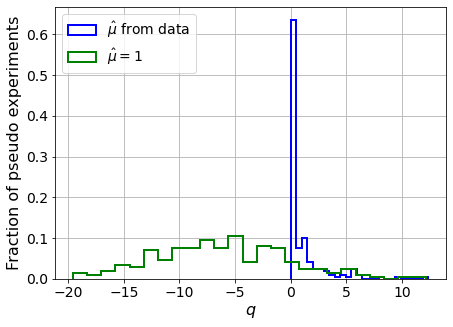

Z_MLL:  0.3050823827435826
std Z_MLL:  2.9588081758268694


  1%|▋                                                                   | 2/200 [00:01<02:19,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38911129825761354
<p_{s}(Sdata)> = 2.0773927758151283
<p_{b}(Bdata)> = 4.007837479499632
<p_{s}(Bdata)> = 0.4253045251445578


  4%|██▍                                                                 | 7/200 [00:05<02:26,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4204754523627985
<p_{s}(Sdata)> = 1.9461803121062384
<p_{b}(Bdata)> = 3.989787710306023
<p_{s}(Bdata)> = 0.42382478256590345


  9%|██████                                                             | 18/200 [00:18<02:47,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5188238033546322
<p_{s}(Sdata)> = 1.9284155724561416
<p_{b}(Bdata)> = 3.995255776800805
<p_{s}(Bdata)> = 0.42497556870099956


 10%|██████▎                                                            | 19/200 [00:18<02:19,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49250840915709726
<p_{s}(Sdata)> = 1.9152982059293036
<p_{b}(Bdata)> = 3.980081255152545
<p_{s}(Bdata)> = 0.4241701326887676


 12%|███████▋                                                           | 23/200 [00:21<02:01,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45352195916513194
<p_{s}(Sdata)> = 1.929081635737477
<p_{b}(Bdata)> = 3.996149753608097
<p_{s}(Bdata)> = 0.4241652305848677


 12%|████████                                                           | 24/200 [00:21<01:46,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5148421649526228
<p_{s}(Sdata)> = 1.8558726947135376
<p_{b}(Bdata)> = 3.981947356999892
<p_{s}(Bdata)> = 0.42517752870872777


 12%|████████▍                                                          | 25/200 [00:22<01:35,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4694100614254858
<p_{s}(Sdata)> = 1.906609461305849
<p_{b}(Bdata)> = 4.002660298604915
<p_{s}(Bdata)> = 0.4190384115056757


 14%|█████████▍                                                         | 28/200 [00:24<01:59,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.479782914308756
<p_{s}(Sdata)> = 1.7182374492445975
<p_{b}(Bdata)> = 3.989932642604239
<p_{s}(Bdata)> = 0.425637029688097


 14%|█████████▋                                                         | 29/200 [00:25<01:43,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43084659889367954
<p_{s}(Sdata)> = 2.004874312943627
<p_{b}(Bdata)> = 3.9789160906404475
<p_{s}(Bdata)> = 0.4239824854994337


 15%|██████████                                                         | 30/200 [00:25<01:33,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40867124993739484
<p_{s}(Sdata)> = 2.0773770222027026
<p_{b}(Bdata)> = 4.004564310167565
<p_{s}(Bdata)> = 0.4214182111684142


 16%|██████████▋                                                        | 32/200 [00:26<01:31,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.399805116978304
<p_{s}(Sdata)> = 2.0970771318277377
<p_{b}(Bdata)> = 3.971622876293139
<p_{s}(Bdata)> = 0.4251853688646527


 16%|███████████                                                        | 33/200 [00:27<01:23,  2.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48094837736378243
<p_{s}(Sdata)> = 1.8837238246072927
<p_{b}(Bdata)> = 4.008739586337991
<p_{s}(Bdata)> = 0.4241143672168985


 18%|████████████                                                       | 36/200 [00:29<01:50,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4328975173510703
<p_{s}(Sdata)> = 2.003060630762605
<p_{b}(Bdata)> = 4.011777174709786
<p_{s}(Bdata)> = 0.4226906769429039


 20%|█████████████                                                      | 39/200 [00:32<02:21,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43069315033415384
<p_{s}(Sdata)> = 1.9768518161566362
<p_{b}(Bdata)> = 3.9937472182049443
<p_{s}(Bdata)> = 0.4218321275981032


 20%|█████████████▋                                                     | 41/200 [00:34<02:18,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40612280528199796
<p_{s}(Sdata)> = 2.102936477057072
<p_{b}(Bdata)> = 4.0137910998259025
<p_{s}(Bdata)> = 0.4223327682078889


 22%|██████████████▍                                                    | 43/200 [00:36<01:52,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4677558277189725
<p_{s}(Sdata)> = 1.8233450130540882
<p_{b}(Bdata)> = 4.015170868636151
<p_{s}(Bdata)> = 0.4210232754304951


 23%|███████████████▍                                                   | 46/200 [00:38<01:59,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4569277215825648
<p_{s}(Sdata)> = 1.9610559390807223
<p_{b}(Bdata)> = 3.9914409356466396
<p_{s}(Bdata)> = 0.42452887583615795


 24%|███████████████▋                                                   | 47/200 [00:39<01:41,  1.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41533383344161295
<p_{s}(Sdata)> = 2.0888390805796098
<p_{b}(Bdata)> = 3.9993399226047934
<p_{s}(Bdata)> = 0.4232000810027569


 24%|████████████████                                                   | 48/200 [00:39<01:29,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4212608733277536
<p_{s}(Sdata)> = 1.9526483758357192
<p_{b}(Bdata)> = 3.9715290709956803
<p_{s}(Bdata)> = 0.422964164916055


 26%|█████████████████                                                  | 51/200 [00:42<01:48,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3915627133231508
<p_{s}(Sdata)> = 2.0976998763793646
<p_{b}(Bdata)> = 4.001028628713296
<p_{s}(Bdata)> = 0.42304597255223747


 26%|█████████████████▍                                                 | 52/200 [00:42<01:33,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4285811591942201
<p_{s}(Sdata)> = 2.0393023016678367
<p_{b}(Bdata)> = 4.017274992822683
<p_{s}(Bdata)> = 0.42182027137188055


 26%|█████████████████▊                                                 | 53/200 [00:42<01:23,  1.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41777650716214787
<p_{s}(Sdata)> = 1.97324698059139
<p_{b}(Bdata)> = 4.015502217093618
<p_{s}(Bdata)> = 0.4226834797585719


 27%|██████████████████                                                 | 54/200 [00:43<01:15,  1.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47441826830163214
<p_{s}(Sdata)> = 1.7506853074708064
<p_{b}(Bdata)> = 3.9938209059143777
<p_{s}(Bdata)> = 0.42250537872123206


 32%|█████████████████████                                              | 63/200 [00:50<01:31,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4279656484276538
<p_{s}(Sdata)> = 2.01347672495724
<p_{b}(Bdata)> = 3.968970697155593
<p_{s}(Bdata)> = 0.42380264624363645


 32%|█████████████████████▍                                             | 64/200 [00:50<01:20,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4147569433897449
<p_{s}(Sdata)> = 2.130667149164473
<p_{b}(Bdata)> = 4.010674754964832
<p_{s}(Bdata)> = 0.4210838994098441


 32%|█████████████████████▊                                             | 65/200 [00:51<01:12,  1.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4322133994811317
<p_{s}(Sdata)> = 1.9017334625280282
<p_{b}(Bdata)> = 3.9948671287809994
<p_{s}(Bdata)> = 0.4223566561109762


 33%|██████████████████████                                             | 66/200 [00:51<01:06,  2.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45167355307027873
<p_{s}(Sdata)> = 1.8392135174641453
<p_{b}(Bdata)> = 4.007914209625265
<p_{s}(Bdata)> = 0.42098264430423854


 34%|███████████████████████                                            | 69/200 [00:54<01:50,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4383110721219215
<p_{s}(Sdata)> = 1.8437659417802506
<p_{b}(Bdata)> = 3.9905016895214267
<p_{s}(Bdata)> = 0.42555378876219246


 36%|████████████████████████                                           | 72/200 [00:57<01:42,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4386195663484377
<p_{s}(Sdata)> = 2.031373883847563
<p_{b}(Bdata)> = 4.021207922828879
<p_{s}(Bdata)> = 0.42272141948364517


 36%|████████████████████████▍                                          | 73/200 [00:57<01:26,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5142167772127239
<p_{s}(Sdata)> = 1.8592305447742545
<p_{b}(Bdata)> = 4.0384612732687755
<p_{s}(Bdata)> = 0.4205054907024521


 38%|█████████████████████████▏                                         | 75/200 [00:59<01:26,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4359934464424981
<p_{s}(Sdata)> = 1.9959063451603853
<p_{b}(Bdata)> = 3.9918788648960737
<p_{s}(Bdata)> = 0.4251946301968295


 38%|█████████████████████████▍                                         | 76/200 [00:59<01:15,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4061796502892259
<p_{s}(Sdata)> = 2.004052096072409
<p_{b}(Bdata)> = 3.9888222201850883
<p_{s}(Bdata)> = 0.4229086551421368


 38%|█████████████████████████▊                                         | 77/200 [01:00<01:07,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4384899405487175
<p_{s}(Sdata)> = 1.98143755861159
<p_{b}(Bdata)> = 4.001865148498592
<p_{s}(Bdata)> = 0.4218068556480113


 40%|███████████████████████████▏                                       | 81/200 [01:03<01:18,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4359740047299096
<p_{s}(Sdata)> = 2.002960657638565
<p_{b}(Bdata)> = 3.989057919059187
<p_{s}(Bdata)> = 0.42304275230300764


 41%|███████████████████████████▍                                       | 82/200 [01:03<01:08,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43170814347963443
<p_{s}(Sdata)> = 1.97059381994558
<p_{b}(Bdata)> = 4.016568518329122
<p_{s}(Bdata)> = 0.42069442593274364


 43%|████████████████████████████▊                                      | 86/200 [01:07<01:17,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43683848041230505
<p_{s}(Sdata)> = 1.9492177549894496
<p_{b}(Bdata)> = 3.999319465132186
<p_{s}(Bdata)> = 0.42393054980655626


 44%|█████████████████████████████▏                                     | 87/200 [01:07<01:07,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4434076455979691
<p_{s}(Sdata)> = 1.92072374397853
<p_{b}(Bdata)> = 3.9827458349532936
<p_{s}(Bdata)> = 0.4244260010849497


 45%|██████████████████████████████▏                                    | 90/200 [01:09<01:13,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43959582088610494
<p_{s}(Sdata)> = 1.895851492845532
<p_{b}(Bdata)> = 4.000311197244222
<p_{s}(Bdata)> = 0.42303043360133485


 46%|██████████████████████████████▍                                    | 91/200 [01:10<01:04,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4048295733726744
<p_{s}(Sdata)> = 1.9652142987001444
<p_{b}(Bdata)> = 4.010459525954123
<p_{s}(Bdata)> = 0.42173202799007126


 46%|███████████████████████████████▏                                   | 93/200 [01:11<01:10,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44558862319821263
<p_{s}(Sdata)> = 1.9153795298773932
<p_{b}(Bdata)> = 4.029300750142908
<p_{s}(Bdata)> = 0.4221711869605076


 47%|███████████████████████████████▍                                   | 94/200 [01:12<01:02,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4088586310329198
<p_{s}(Sdata)> = 2.060938373723351
<p_{b}(Bdata)> = 3.9765886567063506
<p_{s}(Bdata)> = 0.42365404364754594


 48%|███████████████████████████████▊                                   | 95/200 [01:12<00:55,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42152814884184775
<p_{s}(Sdata)> = 2.0236075111647547
<p_{b}(Bdata)> = 3.9951023819529627
<p_{s}(Bdata)> = 0.42135911110228536


 49%|████████████████████████████████▊                                  | 98/200 [01:15<01:19,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.476399651192491
<p_{s}(Sdata)> = 2.0410830567500864
<p_{b}(Bdata)> = 3.994118798813952
<p_{s}(Bdata)> = 0.4220092013206364


 52%|██████████████████████████████████▎                               | 104/200 [01:22<01:31,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45392377509195947
<p_{s}(Sdata)> = 1.9121694943349883
<p_{b}(Bdata)> = 3.986702409063357
<p_{s}(Bdata)> = 0.4222961390365941


 53%|██████████████████████████████████▉                               | 106/200 [01:24<01:14,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3974932400737322
<p_{s}(Sdata)> = 1.9990311267067775
<p_{b}(Bdata)> = 3.989066254191793
<p_{s}(Bdata)> = 0.42291198939072117


 56%|████████████████████████████████████▉                             | 112/200 [01:30<01:18,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5141830455344133
<p_{s}(Sdata)> = 1.8766825084642473
<p_{b}(Bdata)> = 3.9913484413714273
<p_{s}(Bdata)> = 0.4243748338232573


 58%|██████████████████████████████████████▎                           | 116/200 [01:36<01:43,  1.23s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4540087313726015
<p_{s}(Sdata)> = 1.965602050893268
<p_{b}(Bdata)> = 4.004135246130425
<p_{s}(Bdata)> = 0.42263992508380804


 59%|██████████████████████████████████████▉                           | 118/200 [01:37<01:14,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4736999401836663
<p_{s}(Sdata)> = 1.8145238479951953
<p_{b}(Bdata)> = 4.003736466088676
<p_{s}(Bdata)> = 0.4266560398298537


 60%|███████████████████████████████████████▉                          | 121/200 [01:40<01:11,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.468167179395916
<p_{s}(Sdata)> = 1.8891684691488215
<p_{b}(Bdata)> = 4.00183487585114
<p_{s}(Bdata)> = 0.4246456322339037


 62%|████████████████████████████████████████▌                         | 123/200 [01:41<00:54,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4036649789422499
<p_{s}(Sdata)> = 2.083838468993048
<p_{b}(Bdata)> = 3.9964025018295755
<p_{s}(Bdata)> = 0.42208602562064673


 64%|██████████████████████████████████████████▌                       | 129/200 [01:47<00:55,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4894226133612876
<p_{s}(Sdata)> = 1.7136875864461514
<p_{b}(Bdata)> = 4.026449653760188
<p_{s}(Bdata)> = 0.42343882751979905


 66%|███████████████████████████████████████████▏                      | 131/200 [01:49<00:56,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4425644917696067
<p_{s}(Sdata)> = 1.8892469187513947
<p_{b}(Bdata)> = 4.0029585608504386
<p_{s}(Bdata)> = 0.4230939353862259


 68%|████████████████████████████████████████████▌                     | 135/200 [01:53<00:58,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43390434503462055
<p_{s}(Sdata)> = 1.9563271680997065
<p_{b}(Bdata)> = 4.0074895229782825
<p_{s}(Bdata)> = 0.4226642813698331


 68%|████████████████████████████████████████████▉                     | 136/200 [01:54<00:48,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42666117163546363
<p_{s}(Sdata)> = 1.9509190955698148
<p_{b}(Bdata)> = 4.001328539540834
<p_{s}(Bdata)> = 0.42268642668966766


 69%|█████████████████████████████████████████████▌                    | 138/200 [01:55<00:41,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42500841318770816
<p_{s}(Sdata)> = 1.9167508795747787
<p_{b}(Bdata)> = 3.996570461931467
<p_{s}(Bdata)> = 0.4236957115345055


 71%|██████████████████████████████████████████████▊                   | 142/200 [01:58<00:38,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4864324936589113
<p_{s}(Sdata)> = 1.8254994426911426
<p_{b}(Bdata)> = 4.010663355739044
<p_{s}(Bdata)> = 0.42363373303757956


 72%|███████████████████████████████████████████████▏                  | 143/200 [01:58<00:33,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45543600053642863
<p_{s}(Sdata)> = 1.976348181268266
<p_{b}(Bdata)> = 3.9933626609565716
<p_{s}(Bdata)> = 0.4229475296665822


 72%|███████████████████████████████████████████████▌                  | 144/200 [01:59<00:29,  1.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45839410774278433
<p_{s}(Sdata)> = 1.9360729936001866
<p_{b}(Bdata)> = 3.994411268988316
<p_{s}(Bdata)> = 0.42536984490096197


 74%|████████████████████████████████████████████████▌                 | 147/200 [02:01<00:37,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4322799781197127
<p_{s}(Sdata)> = 1.9423972473175606
<p_{b}(Bdata)> = 3.995779219466324
<p_{s}(Bdata)> = 0.4243380056790625


 74%|█████████████████████████████████████████████████▏                | 149/200 [02:02<00:31,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.424758036779123
<p_{s}(Sdata)> = 1.9426636250778049
<p_{b}(Bdata)> = 4.014644119393211
<p_{s}(Bdata)> = 0.42315946169963903


 75%|█████████████████████████████████████████████████▌                | 150/200 [02:03<00:27,  1.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4203009211193389
<p_{s}(Sdata)> = 1.891471114888669
<p_{b}(Bdata)> = 3.9917264323688424
<p_{s}(Bdata)> = 0.42535308887123674


 76%|█████████████████████████████████████████████████▊                | 151/200 [02:03<00:25,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4041152742865127
<p_{s}(Sdata)> = 2.042906988770966
<p_{b}(Bdata)> = 3.98445669174799
<p_{s}(Bdata)> = 0.4236480581704859


 76%|██████████████████████████████████████████████████▏               | 152/200 [02:04<00:23,  2.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40660365374911883
<p_{s}(Sdata)> = 2.059686646608223
<p_{b}(Bdata)> = 3.979636725970383
<p_{s}(Bdata)> = 0.4249210837745983


 76%|██████████████████████████████████████████████████▍               | 153/200 [02:04<00:21,  2.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44370765872959056
<p_{s}(Sdata)> = 1.9929502996510342
<p_{b}(Bdata)> = 4.013636045615564
<p_{s}(Bdata)> = 0.4242659193355721


 77%|██████████████████████████████████████████████████▊               | 154/200 [02:04<00:20,  2.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4096383070753604
<p_{s}(Sdata)> = 2.1192494888200177
<p_{b}(Bdata)> = 3.9838262269842906
<p_{s}(Bdata)> = 0.4242854667984713


 78%|███████████████████████████████████████████████████▏              | 155/200 [02:05<00:19,  2.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4293906456678459
<p_{s}(Sdata)> = 1.9957400826015828
<p_{b}(Bdata)> = 3.9786653370044465
<p_{s}(Bdata)> = 0.4224765849995921


 78%|███████████████████████████████████████████████████▊              | 157/200 [02:07<00:28,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4770938197089897
<p_{s}(Sdata)> = 1.9171814911795066
<p_{b}(Bdata)> = 4.004602298908531
<p_{s}(Bdata)> = 0.42517058879817665


 79%|████████████████████████████████████████████████████▏             | 158/200 [02:07<00:24,  1.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4432432622962976
<p_{s}(Sdata)> = 1.858632025666564
<p_{b}(Bdata)> = 4.018376667504426
<p_{s}(Bdata)> = 0.42122340100544414


 80%|████████████████████████████████████████████████████▍             | 159/200 [02:08<00:21,  1.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4244851428133225
<p_{s}(Sdata)> = 2.0604953997304642
<p_{b}(Bdata)> = 3.996927730127561
<p_{s}(Bdata)> = 0.42272525041275577


 80%|█████████████████████████████████████████████████████▏            | 161/200 [02:09<00:21,  1.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4669565353084328
<p_{s}(Sdata)> = 1.8790254037064804
<p_{b}(Bdata)> = 4.004010469820564
<p_{s}(Bdata)> = 0.42234621847639486


 82%|██████████████████████████████████████████████████████            | 164/200 [02:12<00:25,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4188722069511725
<p_{s}(Sdata)> = 2.008607063599739
<p_{b}(Bdata)> = 4.006003394709599
<p_{s}(Bdata)> = 0.4238046045753559


 82%|██████████████████████████████████████████████████████▍           | 165/200 [02:12<00:21,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4534681245894887
<p_{s}(Sdata)> = 1.9428841355055526
<p_{b}(Bdata)> = 3.9858141954411663
<p_{s}(Bdata)> = 0.42101013550127975


 85%|████████████████████████████████████████████████████████          | 170/200 [02:17<00:25,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4838007664186632
<p_{s}(Sdata)> = 1.9258745758957183
<p_{b}(Bdata)> = 3.994056387299449
<p_{s}(Bdata)> = 0.4237014899578741


 86%|████████████████████████████████████████████████████████▊         | 172/200 [02:19<00:24,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4598899810891584
<p_{s}(Sdata)> = 1.9104283904905155
<p_{b}(Bdata)> = 3.9955808244956756
<p_{s}(Bdata)> = 0.42311817782775313


 88%|██████████████████████████████████████████████████████████        | 176/200 [02:23<00:20,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42067891746235636
<p_{s}(Sdata)> = 1.9899866020240848
<p_{b}(Bdata)> = 3.987567809134195
<p_{s}(Bdata)> = 0.424115455299745


 88%|██████████████████████████████████████████████████████████▍       | 177/200 [02:23<00:16,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47839116814951343
<p_{s}(Sdata)> = 1.7940076416720199
<p_{b}(Bdata)> = 4.029708298325894
<p_{s}(Bdata)> = 0.4213489130937805


 90%|███████████████████████████████████████████████████████████▍      | 180/200 [02:26<00:15,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4492703151560429
<p_{s}(Sdata)> = 1.993723735769713
<p_{b}(Bdata)> = 3.994679468063327
<p_{s}(Bdata)> = 0.42156301823115766


 90%|███████████████████████████████████████████████████████████▋      | 181/200 [02:26<00:12,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4221765078755527
<p_{s}(Sdata)> = 1.9680176813576657
<p_{b}(Bdata)> = 3.9865582884431587
<p_{s}(Bdata)> = 0.4234197103936252


 96%|███████████████████████████████████████████████████████████████   | 191/200 [02:37<00:08,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40705834067803404
<p_{s}(Sdata)> = 1.9846565634254352
<p_{b}(Bdata)> = 3.9995526605807217
<p_{s}(Bdata)> = 0.42271669113620824


 96%|███████████████████████████████████████████████████████████████▎  | 192/200 [02:37<00:06,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4519107323157682
<p_{s}(Sdata)> = 1.9808550885660803
<p_{b}(Bdata)> = 4.0062529985463105
<p_{s}(Bdata)> = 0.42124053305288456


 97%|████████████████████████████████████████████████████████████████  | 194/200 [02:39<00:04,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4275781004579388
<p_{s}(Sdata)> = 1.98130468961068
<p_{b}(Bdata)> = 4.0133880475212935
<p_{s}(Bdata)> = 0.4224804941195261


100%|██████████████████████████████████████████████████████████████████| 200/200 [02:46<00:00,  1.20it/s]


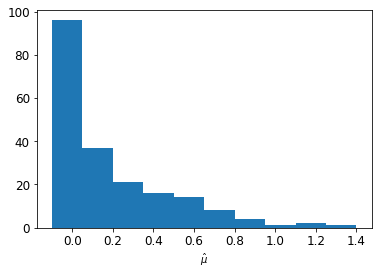

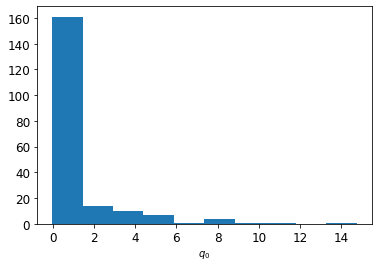

Z:0.15871081179206065
Z_std:6.728571800080259
Z_1:2.6866401342345485
Z_std_1:1.1933559730259211
5
AUC:0.9042836101379903
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

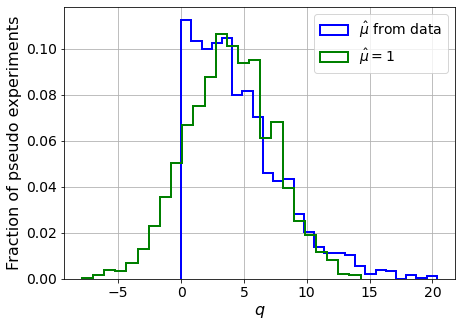

Z BL:(1.9629468113750714, 0.889585095645551, 1.01275, 1.9629468113750714, 0.875547462628261)


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf
  5679.41129408  5389.89759092  5026.6709135   4595.76974228
  4076.35391455  3468.0063683   2741.66085525  1841.57674775
   692.19067985  -794.92893761 -2648.28994264 -5272.76506669]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  4057.44129704  4074.63360038  4075.4634909
 

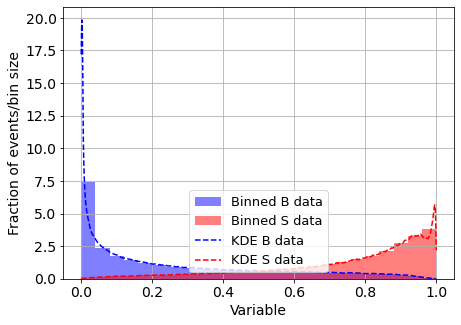

KDE Kernel:  epanechnikov
Background bandwidth:  0.005072980090653727
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.008515732621656915
0.008515732621656915
3 done
4 done
0.004852765510828261
0.004852765510828261
B_expected:  147986
S_expected:  202

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


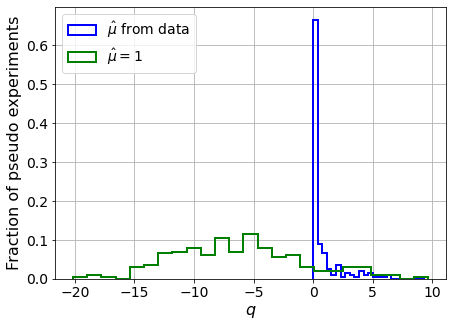

Z_MLL:  0.24108915734271552
std Z_MLL:  3.1259430857627186


  0%|▎                                                                   | 1/200 [00:00<01:19,  2.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4245438015435331
<p_{s}(Sdata)> = 2.0785880913381356
<p_{b}(Bdata)> = 4.183706135894732
<p_{s}(Bdata)> = 0.41991007775750044


  1%|▋                                                                   | 2/200 [00:00<01:19,  2.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4312707304422874
<p_{s}(Sdata)> = 1.89964802027611
<p_{b}(Bdata)> = 4.162834957111236
<p_{s}(Bdata)> = 0.4233452480149029


  2%|█▋                                                                  | 5/200 [00:03<02:24,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45283158427788206
<p_{s}(Sdata)> = 1.8472743725296308
<p_{b}(Bdata)> = 4.173672186480277
<p_{s}(Bdata)> = 0.4230098323120383


  4%|██▋                                                                 | 8/200 [00:05<02:01,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40407433784001506
<p_{s}(Sdata)> = 1.986504911998333
<p_{b}(Bdata)> = 4.171743187514025
<p_{s}(Bdata)> = 0.42477183276308084


  6%|████                                                               | 12/200 [00:08<02:10,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5144956211550002
<p_{s}(Sdata)> = 1.9441675335982243
<p_{b}(Bdata)> = 4.18094967293517
<p_{s}(Bdata)> = 0.41947116678847696


  6%|████▎                                                              | 13/200 [00:08<01:53,  1.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4501811732208926
<p_{s}(Sdata)> = 1.9514798577327828
<p_{b}(Bdata)> = 4.158027631607936
<p_{s}(Bdata)> = 0.42240558752112023


  8%|█████▎                                                             | 16/200 [00:10<01:46,  1.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4190598911862029
<p_{s}(Sdata)> = 2.007376523610565
<p_{b}(Bdata)> = 4.147977953965513
<p_{s}(Bdata)> = 0.42403750093797354


 10%|██████▋                                                            | 20/200 [00:14<02:01,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42274856748234035
<p_{s}(Sdata)> = 2.1202134302588944
<p_{b}(Bdata)> = 4.1841201437303654
<p_{s}(Bdata)> = 0.4204367292402732


 10%|███████                                                            | 21/200 [00:14<01:46,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4544732163734836
<p_{s}(Sdata)> = 1.9712810220721086
<p_{b}(Bdata)> = 4.161969141887317
<p_{s}(Bdata)> = 0.42426207523856335


 13%|████████▋                                                          | 26/200 [00:18<02:04,  1.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45669600100712937
<p_{s}(Sdata)> = 2.03003657714986
<p_{b}(Bdata)> = 4.16044834450798
<p_{s}(Bdata)> = 0.4234834493919248


 16%|██████████▋                                                        | 32/200 [00:23<02:02,  1.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46651495259726294
<p_{s}(Sdata)> = 1.8634542004923895
<p_{b}(Bdata)> = 4.187150911418746
<p_{s}(Bdata)> = 0.42278096166026674


 16%|███████████                                                        | 33/200 [00:24<01:44,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3997674304803523
<p_{s}(Sdata)> = 1.9987898634815633
<p_{b}(Bdata)> = 4.157946750610261
<p_{s}(Bdata)> = 0.4225299833736293


 20%|█████████████                                                      | 39/200 [00:29<01:50,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4815225707391446
<p_{s}(Sdata)> = 1.8294810102149741
<p_{b}(Bdata)> = 4.194991328793269
<p_{s}(Bdata)> = 0.42328435091278876


 20%|█████████████▋                                                     | 41/200 [00:30<01:50,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4081558155122697
<p_{s}(Sdata)> = 2.0105085423782567
<p_{b}(Bdata)> = 4.177519910995846
<p_{s}(Bdata)> = 0.42121062397479336


 21%|██████████████                                                     | 42/200 [00:31<01:35,  1.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42120167780637247
<p_{s}(Sdata)> = 2.045234911369477
<p_{b}(Bdata)> = 4.17764071347064
<p_{s}(Bdata)> = 0.42356384836713407


 22%|██████████████▋                                                    | 44/200 [00:32<01:46,  1.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39969013067086295
<p_{s}(Sdata)> = 2.1091945812199238
<p_{b}(Bdata)> = 4.158439977002847
<p_{s}(Bdata)> = 0.4219196252692828


 24%|████████████████▍                                                  | 49/200 [00:36<01:45,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5029194729030634
<p_{s}(Sdata)> = 1.8202426856823746
<p_{b}(Bdata)> = 4.174405073869104
<p_{s}(Bdata)> = 0.4224579326299375


 27%|██████████████████                                                 | 54/200 [00:40<01:53,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4351797172577161
<p_{s}(Sdata)> = 1.9893956770891228
<p_{b}(Bdata)> = 4.168277481450162
<p_{s}(Bdata)> = 0.4229593155373581


 30%|███████████████████▊                                               | 59/200 [00:45<02:05,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4152297824737441
<p_{s}(Sdata)> = 1.921495099902249
<p_{b}(Bdata)> = 4.193053118257516
<p_{s}(Bdata)> = 0.42087680884477346


 30%|████████████████████                                               | 60/200 [00:46<01:43,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4267964577755418
<p_{s}(Sdata)> = 1.9567706253572437
<p_{b}(Bdata)> = 4.181380750800185
<p_{s}(Bdata)> = 0.42104770880029413


 34%|███████████████████████                                            | 69/200 [00:54<01:32,  1.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4855700375186075
<p_{s}(Sdata)> = 2.003530608327348
<p_{b}(Bdata)> = 4.176301575107881
<p_{s}(Bdata)> = 0.42422619625451186


 36%|███████████████████████▊                                           | 71/200 [00:55<01:20,  1.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43172495652009385
<p_{s}(Sdata)> = 1.9438233532196398
<p_{b}(Bdata)> = 4.1568872506041314
<p_{s}(Bdata)> = 0.422511644222343


 37%|████████████████████████▊                                          | 74/200 [00:57<01:18,  1.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46396690083001635
<p_{s}(Sdata)> = 1.8136945723579858
<p_{b}(Bdata)> = 4.162015559207579
<p_{s}(Bdata)> = 0.4229598170044666


 38%|█████████████████████████▍                                         | 76/200 [00:59<01:24,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45883096280743296
<p_{s}(Sdata)> = 2.075153361950721
<p_{b}(Bdata)> = 4.14686471019306
<p_{s}(Bdata)> = 0.42343981698908134


 40%|██████████████████████████▍                                        | 79/200 [01:01<01:14,  1.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4060610152096319
<p_{s}(Sdata)> = 2.0820878345083678
<p_{b}(Bdata)> = 4.15780307814875
<p_{s}(Bdata)> = 0.4218685832241683


 41%|███████████████████████████▍                                       | 82/200 [01:03<01:22,  1.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4744065126071308
<p_{s}(Sdata)> = 2.030057377263139
<p_{b}(Bdata)> = 4.173878498774946
<p_{s}(Bdata)> = 0.42291655396903055


 43%|████████████████████████████▊                                      | 86/200 [01:07<01:25,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46272513517934244
<p_{s}(Sdata)> = 1.9832824148512964
<p_{b}(Bdata)> = 4.165791495780429
<p_{s}(Bdata)> = 0.4217638886256502


 46%|███████████████████████████████▏                                   | 93/200 [01:14<01:47,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4742718220901954
<p_{s}(Sdata)> = 2.003482856750827
<p_{b}(Bdata)> = 4.176425785583756
<p_{s}(Bdata)> = 0.4212520938626861


 47%|███████████████████████████████▍                                   | 94/200 [01:15<01:26,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42603638643306646
<p_{s}(Sdata)> = 1.9289332640688204
<p_{b}(Bdata)> = 4.162527637273629
<p_{s}(Bdata)> = 0.4243111601385866


 48%|███████████████████████████████▊                                   | 95/200 [01:15<01:12,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44707115907741674
<p_{s}(Sdata)> = 1.8384027771600986
<p_{b}(Bdata)> = 4.18982061313601
<p_{s}(Bdata)> = 0.4239608797357676


 48%|████████████████████████████████▏                                  | 96/200 [01:16<01:02,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42758615357750224
<p_{s}(Sdata)> = 1.9201104007310217
<p_{b}(Bdata)> = 4.2030390902119965
<p_{s}(Bdata)> = 0.42184818561787996


 50%|█████████████████████████████████▏                                 | 99/200 [01:18<01:06,  1.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4624742781825184
<p_{s}(Sdata)> = 1.918365869321232
<p_{b}(Bdata)> = 4.175315034042553
<p_{s}(Bdata)> = 0.42340473440263


 50%|█████████████████████████████████                                 | 100/200 [01:18<00:57,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.465899028795318
<p_{s}(Sdata)> = 2.165117767627678
<p_{b}(Bdata)> = 4.151973267772008
<p_{s}(Bdata)> = 0.42335173017240424


 50%|█████████████████████████████████▎                                | 101/200 [01:19<00:51,  1.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45237690942805375
<p_{s}(Sdata)> = 1.9183220006116828
<p_{b}(Bdata)> = 4.1870296738959585
<p_{s}(Bdata)> = 0.42108230405308616


 51%|█████████████████████████████████▋                                | 102/200 [01:19<00:46,  2.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4594964690668089
<p_{s}(Sdata)> = 1.9725974057443034
<p_{b}(Bdata)> = 4.171313975824855
<p_{s}(Bdata)> = 0.42431642008077636


 52%|█████████████████████████████████▉                                | 103/200 [01:19<00:43,  2.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4238608967070934
<p_{s}(Sdata)> = 2.0128542092426955
<p_{b}(Bdata)> = 4.172333575666597
<p_{s}(Bdata)> = 0.4198642309317955


 52%|██████████████████████████████████▎                               | 104/200 [01:20<00:41,  2.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4224674350054356
<p_{s}(Sdata)> = 1.970469688172078
<p_{b}(Bdata)> = 4.145089320915623
<p_{s}(Bdata)> = 0.4242028532185527


 53%|██████████████████████████████████▉                               | 106/200 [01:21<00:44,  2.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42031543469261884
<p_{s}(Sdata)> = 1.9334287998213804
<p_{b}(Bdata)> = 4.168260568901655
<p_{s}(Bdata)> = 0.42330539906600034


 54%|███████████████████████████████████▋                              | 108/200 [01:22<00:46,  1.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5474052735589824
<p_{s}(Sdata)> = 1.9634216189061189
<p_{b}(Bdata)> = 4.178129661877634
<p_{s}(Bdata)> = 0.4220405907244313


 55%|███████████████████████████████████▉                              | 109/200 [01:22<00:42,  2.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41336627551657035
<p_{s}(Sdata)> = 2.029832084385111
<p_{b}(Bdata)> = 4.174943337503873
<p_{s}(Bdata)> = 0.42330501845733276


 56%|████████████████████████████████████▋                             | 111/200 [01:24<00:52,  1.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4007441972752647
<p_{s}(Sdata)> = 2.113323783285332
<p_{b}(Bdata)> = 4.1731989777419605
<p_{s}(Bdata)> = 0.4212244267879961


 57%|█████████████████████████████████████▌                            | 114/200 [01:27<01:05,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46127808336607745
<p_{s}(Sdata)> = 1.9781602184467344
<p_{b}(Bdata)> = 4.137896328361011
<p_{s}(Bdata)> = 0.42406164912126265


 58%|██████████████████████████████████████▌                           | 117/200 [01:29<00:56,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43984682401742087
<p_{s}(Sdata)> = 1.92652702237376
<p_{b}(Bdata)> = 4.171843792152726
<p_{s}(Bdata)> = 0.421334552269088


 59%|██████████████████████████████████████▉                           | 118/200 [01:29<00:48,  1.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4373732200460502
<p_{s}(Sdata)> = 1.9745064541791189
<p_{b}(Bdata)> = 4.1785563039655775
<p_{s}(Bdata)> = 0.4214965403760712


 60%|███████████████████████████████████████▎                          | 119/200 [01:30<00:42,  1.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5411519352405033
<p_{s}(Sdata)> = 1.7723831389723002
<p_{b}(Bdata)> = 4.1571965607168035
<p_{s}(Bdata)> = 0.4246731741019814


 60%|███████████████████████████████████████▌                          | 120/200 [01:30<00:39,  2.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45653521854604984
<p_{s}(Sdata)> = 1.9869991301852306
<p_{b}(Bdata)> = 4.18245288185871
<p_{s}(Bdata)> = 0.4216242663118834


 61%|████████████████████████████████████████▎                         | 122/200 [01:31<00:39,  1.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43380213836503995
<p_{s}(Sdata)> = 1.983572955048962
<p_{b}(Bdata)> = 4.18404206862243
<p_{s}(Bdata)> = 0.4212038179476567


 62%|████████████████████████████████████████▌                         | 123/200 [01:32<00:35,  2.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4236068772083053
<p_{s}(Sdata)> = 1.9651136141587162
<p_{b}(Bdata)> = 4.160236211552983
<p_{s}(Bdata)> = 0.4238543700453155


 64%|██████████████████████████████████████████▌                       | 129/200 [01:37<00:53,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4555798107304871
<p_{s}(Sdata)> = 2.0069358417519974
<p_{b}(Bdata)> = 4.16526854559577
<p_{s}(Bdata)> = 0.4242580766825152


 66%|███████████████████████████████████████████▌                      | 132/200 [01:39<00:45,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4602044737823628
<p_{s}(Sdata)> = 2.0217722176285418
<p_{b}(Bdata)> = 4.1831868579828235
<p_{s}(Bdata)> = 0.4215752367669115


 68%|████████████████████████████████████████████▉                     | 136/200 [01:43<00:58,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4244852434396542
<p_{s}(Sdata)> = 1.9304640184561614
<p_{b}(Bdata)> = 4.169524129463327
<p_{s}(Bdata)> = 0.4234349140209427


 68%|█████████████████████████████████████████████▏                    | 137/200 [01:44<00:47,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4539973206657293
<p_{s}(Sdata)> = 1.946582004555051
<p_{b}(Bdata)> = 4.163603132303341
<p_{s}(Bdata)> = 0.42269109503454966


 70%|█████████████████████████████████████████████▊                    | 139/200 [01:45<00:38,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4124282463615405
<p_{s}(Sdata)> = 2.0245809011536
<p_{b}(Bdata)> = 4.184884171549864
<p_{s}(Bdata)> = 0.4226307061399883


 71%|██████████████████████████████████████████████▊                   | 142/200 [01:48<00:51,  1.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4957626635955687
<p_{s}(Sdata)> = 1.7146968660078608
<p_{b}(Bdata)> = 4.164917295369922
<p_{s}(Bdata)> = 0.4229232393661893


 74%|████████████████████████████████████████████████▊                 | 148/200 [01:54<00:45,  1.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4346819960308784
<p_{s}(Sdata)> = 2.005206377339432
<p_{b}(Bdata)> = 4.150260065764078
<p_{s}(Bdata)> = 0.42298125961833505


 78%|███████████████████████████████████████████████████▏              | 155/200 [02:00<00:34,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45254030786898786
<p_{s}(Sdata)> = 1.9663824571280464
<p_{b}(Bdata)> = 4.176215469937678
<p_{s}(Bdata)> = 0.42349315449689073


 78%|███████████████████████████████████████████████████▍              | 156/200 [02:00<00:28,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4646000625293222
<p_{s}(Sdata)> = 1.8433711826667625
<p_{b}(Bdata)> = 4.162356510231623
<p_{s}(Bdata)> = 0.42180229664290686


 80%|█████████████████████████████████████████████████████▏            | 161/200 [02:06<00:32,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3964835296020655
<p_{s}(Sdata)> = 2.170331129861914
<p_{b}(Bdata)> = 4.158201626030071
<p_{s}(Bdata)> = 0.4247155495873225


 81%|█████████████████████████████████████████████████████▍            | 162/200 [02:06<00:26,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4279883431781284
<p_{s}(Sdata)> = 2.075871450724306
<p_{b}(Bdata)> = 4.168712826799446
<p_{s}(Bdata)> = 0.4202524384171176


 82%|█████████████████████████████████████████████████████▊            | 163/200 [02:06<00:22,  1.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41557371982897845
<p_{s}(Sdata)> = 1.939621330955331
<p_{b}(Bdata)> = 4.173504246736477
<p_{s}(Bdata)> = 0.41999942263320966


 82%|██████████████████████████████████████████████████████            | 164/200 [02:07<00:19,  1.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47347943241161783
<p_{s}(Sdata)> = 1.9799753201488188
<p_{b}(Bdata)> = 4.199363209924182
<p_{s}(Bdata)> = 0.4193404742144753


 82%|██████████████████████████████████████████████████████▍           | 165/200 [02:07<00:17,  2.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.427715535871971
<p_{s}(Sdata)> = 1.9140137210880497
<p_{b}(Bdata)> = 4.184892214851989
<p_{s}(Bdata)> = 0.41938219982611374


 84%|███████████████████████████████████████████████████████▊          | 169/200 [02:11<00:23,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4603370113610858
<p_{s}(Sdata)> = 1.795178487097206
<p_{b}(Bdata)> = 4.149964960135422
<p_{s}(Bdata)> = 0.424728801983078


 86%|████████████████████████████████████████████████████████▍         | 171/200 [02:12<00:20,  1.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44808343172408555
<p_{s}(Sdata)> = 2.010800003021799
<p_{b}(Bdata)> = 4.1894988358381084
<p_{s}(Bdata)> = 0.42143299752597563


 86%|█████████████████████████████████████████████████████████         | 173/200 [02:14<00:18,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4565262018648137
<p_{s}(Sdata)> = 1.9828256586827488
<p_{b}(Bdata)> = 4.180281257470049
<p_{s}(Bdata)> = 0.422464595795565


 88%|██████████████████████████████████████████████████████████▍       | 177/200 [02:19<00:22,  1.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4268741722601603
<p_{s}(Sdata)> = 2.0645065642461176
<p_{b}(Bdata)> = 4.174948370957255
<p_{s}(Bdata)> = 0.4206953600143767


 89%|██████████████████████████████████████████████████████████▋       | 178/200 [02:20<00:17,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4493967447843124
<p_{s}(Sdata)> = 1.9718729029513105
<p_{b}(Bdata)> = 4.15392779503823
<p_{s}(Bdata)> = 0.424099639965647


 90%|███████████████████████████████████████████████████████████▍      | 180/200 [02:21<00:14,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42437731619154856
<p_{s}(Sdata)> = 2.0157249650232947
<p_{b}(Bdata)> = 4.1827179925475395
<p_{s}(Bdata)> = 0.42276865079196424


 92%|█████████████████████████████████████████████████████████████     | 185/200 [02:26<00:13,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4801517674814678
<p_{s}(Sdata)> = 1.8576722772018053
<p_{b}(Bdata)> = 4.191176493600506
<p_{s}(Bdata)> = 0.424434401435126


 94%|██████████████████████████████████████████████████████████████    | 188/200 [02:29<00:10,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3964042385072742
<p_{s}(Sdata)> = 2.163587978740261
<p_{b}(Bdata)> = 4.173256094416111
<p_{s}(Bdata)> = 0.42260700695498016


 95%|██████████████████████████████████████████████████████████████▋   | 190/200 [02:30<00:07,  1.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4354723189639343
<p_{s}(Sdata)> = 1.9370616500015518
<p_{b}(Bdata)> = 4.16796004818019
<p_{s}(Bdata)> = 0.4217552784142625


 96%|███████████████████████████████████████████████████████████████   | 191/200 [02:31<00:05,  1.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4446022946580372
<p_{s}(Sdata)> = 1.9775519224741744
<p_{b}(Bdata)> = 4.192571924426989
<p_{s}(Bdata)> = 0.41848844866356794


 96%|███████████████████████████████████████████████████████████████▎  | 192/200 [02:31<00:04,  1.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39958218867663636
<p_{s}(Sdata)> = 2.0989808323432912
<p_{b}(Bdata)> = 4.169745476954556
<p_{s}(Bdata)> = 0.422540192765713


 96%|███████████████████████████████████████████████████████████████▋  | 193/200 [02:32<00:03,  1.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5027995642798015
<p_{s}(Sdata)> = 1.9234488439466761
<p_{b}(Bdata)> = 4.16726091918835
<p_{s}(Bdata)> = 0.4238629494403021


 98%|█████████████████████████████████████████████████████████████████ | 197/200 [02:34<00:01,  1.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4028942759367495
<p_{s}(Sdata)> = 2.030587652616537
<p_{b}(Bdata)> = 4.17833196322457
<p_{s}(Bdata)> = 0.42348536718033175


100%|█████████████████████████████████████████████████████████████████▋| 199/200 [02:36<00:00,  1.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4310009359661424
<p_{s}(Sdata)> = 1.9632570327963894
<p_{b}(Bdata)> = 4.183510779865737
<p_{s}(Bdata)> = 0.42323967249506306


100%|██████████████████████████████████████████████████████████████████| 200/200 [02:37<00:00,  1.27it/s]


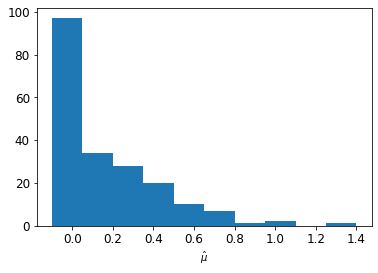

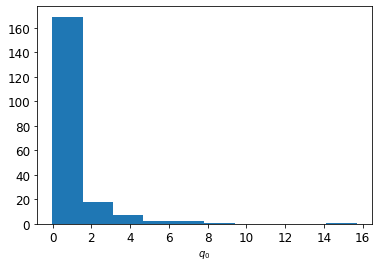

Z:0.15822101619794582
Z_std:5.330281495890611
Z_1:2.61746935900132
Z_std_1:1.1231696931310546
6
AUC:0.9052246117539007
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

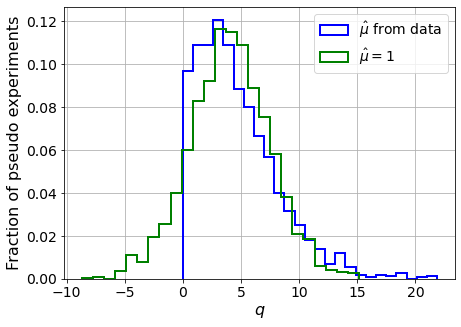

Z BL:(1.9995309310386364, 0.8737751080965838, 1.015725, 1.9995309310386364, 0.854332896753732)


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  6329.13529151  6138.2894818
  5894.57960215  5590.26976596  5221.11517525  4777.04477588
  4242.2352774   3606.92642478  2851.57084082  1920.62355386
   745.87181896  -740.26236174 -2603.32602725 -5260.0540499 ]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  4101.0773512   4116.54265703  4117.95959555
 

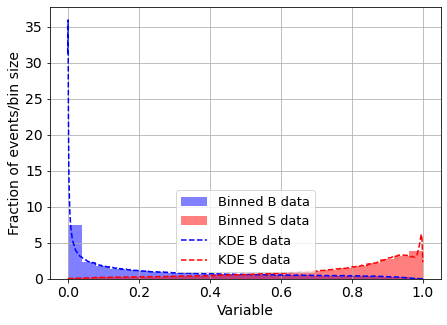

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.005385317934796382
0.005385317934796382
3 done
4 done
0.0016207971554725762
0.0016207971554725762
B_expected:  147986
S_expected:  202

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


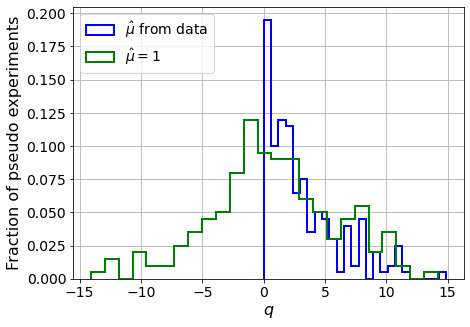

Z_MLL:  1.5157815248795472
std Z_MLL:  0.9968049964469009


  4%|██▋                                                                 | 8/200 [00:11<04:26,  1.39s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4530806535335877
<p_{s}(Sdata)> = 1.977993196994933
<p_{b}(Bdata)> = 5.475498873021998
<p_{s}(Bdata)> = 0.41824633357193075


  7%|████▋                                                              | 14/200 [00:18<02:53,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.468472191373084
<p_{s}(Sdata)> = 1.896348092967846
<p_{b}(Bdata)> = 5.520788429912778
<p_{s}(Bdata)> = 0.4169489979158251


  8%|█████▎                                                             | 16/200 [00:21<03:01,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4248210300237363
<p_{s}(Sdata)> = 1.964947628853917
<p_{b}(Bdata)> = 5.476389349927078
<p_{s}(Bdata)> = 0.4179563325126044


  8%|█████▋                                                             | 17/200 [00:21<02:27,  1.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4191974197196561
<p_{s}(Sdata)> = 2.0538817311780315
<p_{b}(Bdata)> = 5.4618352809096855
<p_{s}(Bdata)> = 0.4194304106468551


 24%|████████████████                                                   | 48/200 [01:07<02:54,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4112494412427043
<p_{s}(Sdata)> = 1.9336264437816355
<p_{b}(Bdata)> = 5.516036646862838
<p_{s}(Bdata)> = 0.419590376768485


 24%|████████████████▍                                                  | 49/200 [01:07<02:19,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45357239571255026
<p_{s}(Sdata)> = 1.9656349116566243
<p_{b}(Bdata)> = 5.4714032260826775
<p_{s}(Bdata)> = 0.4171479976083322


 50%|█████████████████████████████████▏                                 | 99/200 [02:12<01:33,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.434322120896632
<p_{s}(Sdata)> = 1.9944060702899886
<p_{b}(Bdata)> = 5.416885914107361
<p_{s}(Bdata)> = 0.42015974525941957


 55%|████████████████████████████████████▎                             | 110/200 [02:27<01:39,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.6629733246254036
<p_{s}(Sdata)> = 1.8804496555516022
<p_{b}(Bdata)> = 5.492051332435311
<p_{s}(Bdata)> = 0.42070129276437507


 64%|██████████████████████████████████████████▏                       | 128/200 [02:49<01:01,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43168197040959416
<p_{s}(Sdata)> = 1.888740696756973
<p_{b}(Bdata)> = 5.444025381648315
<p_{s}(Bdata)> = 0.41988751193058277


 65%|██████████████████████████████████████████▉                       | 130/200 [02:50<00:52,  1.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40036703649332606
<p_{s}(Sdata)> = 2.1587087353591006
<p_{b}(Bdata)> = 5.477026729936377
<p_{s}(Bdata)> = 0.41890059198170887


 78%|███████████████████████████████████████████████████▍              | 156/200 [03:24<00:47,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.3935340198344249
<p_{s}(Sdata)> = 2.0818572611125274
<p_{b}(Bdata)> = 5.495750947895358
<p_{s}(Bdata)> = 0.42061004033613186


 80%|████████████████████████████████████████████████████▍             | 159/200 [03:29<00:47,  1.15s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.43185874445311573
<p_{s}(Sdata)> = 1.9377762967991292
<p_{b}(Bdata)> = 5.483894100384327
<p_{s}(Bdata)> = 0.4212562750117397


 92%|█████████████████████████████████████████████████████████████     | 185/200 [04:03<00:14,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4067386517149963
<p_{s}(Sdata)> = 2.019744519982514
<p_{b}(Bdata)> = 5.5011364148876
<p_{s}(Bdata)> = 0.4198249877933942


 95%|██████████████████████████████████████████████████████████████▋   | 190/200 [04:08<00:09,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40556872426169277
<p_{s}(Sdata)> = 1.9829707646564099
<p_{b}(Bdata)> = 5.454954208572778
<p_{s}(Bdata)> = 0.42036987013025395


100%|██████████████████████████████████████████████████████████████████| 200/200 [04:22<00:00,  1.31s/it]


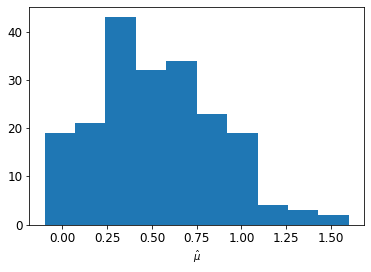

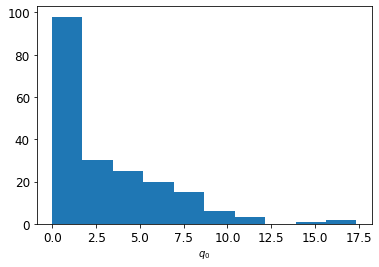

Z:1.3699961126628328
Z_std:1.209364244440926
Z_1:0.5133486710649067
Z_std_1:5.516649109575389
7
AUC:0.9042655386416283
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

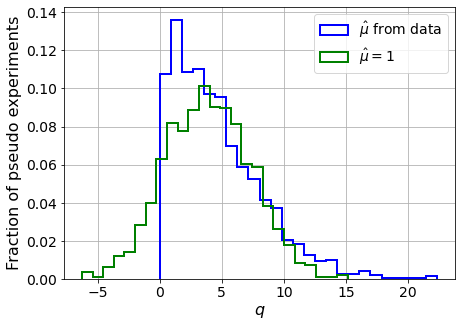

Z BL:(1.9580536584530357, 0.9068655464463924, 1.0221000000000002, 1.9587580044375543, 0.8692294994404298)


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  5881.21072697
  5662.44408813  5386.55712757  5037.26504299  4612.35707456
  4107.42436084  3499.91720567  2767.6520642   1871.45041543
   726.08831118  -748.01899341 -2590.61108702 -5253.88075705]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  4078.15493044  4079.61378439


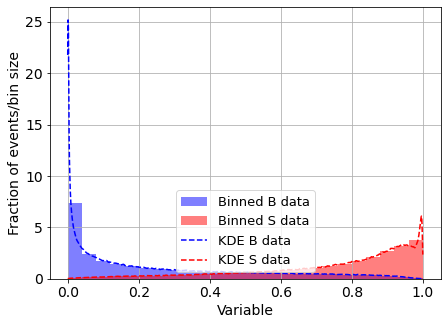

KDE Kernel:  epanechnikov
Background bandwidth:  0.0031053121543406503
Signal bandwidth:  0.0031053121543406503
This may take a while...
1 done
2 done
0.005639110296190345
0.005639110296190345
3 done
4 done
0.0027535013763851394
0.0027535013763851394
B_expected:  147986
S_expected:  202

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


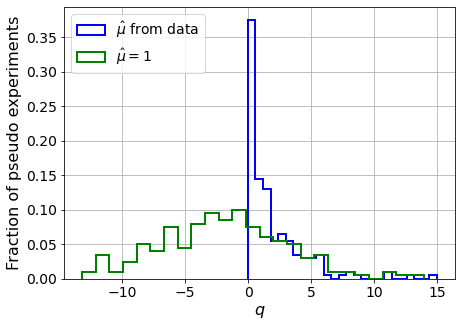

Z_MLL:  1.0571810264202974
std Z_MLL:  1.1420082423796043


  0%|▎                                                                   | 1/200 [00:00<01:17,  2.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4577536606455693
<p_{s}(Sdata)> = 1.8927928686979618
<p_{b}(Bdata)> = 4.50582373083019
<p_{s}(Bdata)> = 0.4208823854035185


  1%|▋                                                                   | 2/200 [00:00<01:17,  2.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45994933745185773
<p_{s}(Sdata)> = 1.9327528960943943
<p_{b}(Bdata)> = 4.494539923719214
<p_{s}(Bdata)> = 0.42428962525472486


  5%|███▎                                                               | 10/200 [00:09<03:01,  1.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4341038840481103
<p_{s}(Sdata)> = 2.0540454507311345
<p_{b}(Bdata)> = 4.514789385971506
<p_{s}(Bdata)> = 0.42397240677214454


  6%|███▋                                                               | 11/200 [00:10<02:27,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4303179182669722
<p_{s}(Sdata)> = 2.0088527539331578
<p_{b}(Bdata)> = 4.533399785013869
<p_{s}(Bdata)> = 0.4216676716856027


  6%|████▎                                                              | 13/200 [00:11<02:26,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4657385934074983
<p_{s}(Sdata)> = 1.9174504203695022
<p_{b}(Bdata)> = 4.518593787274928
<p_{s}(Bdata)> = 0.4219688060839358


  8%|█████▎                                                             | 16/200 [00:14<02:31,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4864110980916917
<p_{s}(Sdata)> = 2.0320572162591928
<p_{b}(Bdata)> = 4.511627422773872
<p_{s}(Bdata)> = 0.42159395335251065


  8%|█████▋                                                             | 17/200 [00:15<02:06,  1.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4645625802441517
<p_{s}(Sdata)> = 2.0396809575975325
<p_{b}(Bdata)> = 4.472747071661007
<p_{s}(Bdata)> = 0.42002201749996587


 10%|██████▋                                                            | 20/200 [00:17<02:15,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46809185752274096
<p_{s}(Sdata)> = 1.8977222904927615
<p_{b}(Bdata)> = 4.530992887059116
<p_{s}(Bdata)> = 0.4195167504073295


 12%|████████▍                                                          | 25/200 [00:23<02:50,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46361940908805466
<p_{s}(Sdata)> = 1.891495882341928
<p_{b}(Bdata)> = 4.51740524231146
<p_{s}(Bdata)> = 0.42127363925560496


 14%|█████████                                                          | 27/200 [00:25<02:36,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5325207553529816
<p_{s}(Sdata)> = 2.0073717662303374
<p_{b}(Bdata)> = 4.502565510146144
<p_{s}(Bdata)> = 0.4207637801533839


 18%|████████████▍                                                      | 37/200 [00:38<03:15,  1.20s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4405305760958124
<p_{s}(Sdata)> = 2.02859143539718
<p_{b}(Bdata)> = 4.504299983453823
<p_{s}(Bdata)> = 0.4226157085164848


 19%|████████████▋                                                      | 38/200 [00:39<02:35,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4862245416468298
<p_{s}(Sdata)> = 2.0208494029067254
<p_{b}(Bdata)> = 4.473138111055515
<p_{s}(Bdata)> = 0.4210826822453218


 24%|███████████████▋                                                   | 47/200 [00:47<02:06,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48713466170281433
<p_{s}(Sdata)> = 2.082204581585201
<p_{b}(Bdata)> = 4.511869491808589
<p_{s}(Bdata)> = 0.4224011777781692


 26%|█████████████████▊                                                 | 53/200 [00:52<01:57,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4085838431986419
<p_{s}(Sdata)> = 2.0205399951472933
<p_{b}(Bdata)> = 4.521421209569167
<p_{s}(Bdata)> = 0.42014583319289767


 28%|██████████████████▊                                                | 56/200 [00:54<01:51,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43850114209140223
<p_{s}(Sdata)> = 1.9653898801825902
<p_{b}(Bdata)> = 4.515702022920615
<p_{s}(Bdata)> = 0.41967842827389623


 28%|███████████████████                                                | 57/200 [00:55<01:34,  1.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44719555915388076
<p_{s}(Sdata)> = 1.8277029578057367
<p_{b}(Bdata)> = 4.530532381715224
<p_{s}(Bdata)> = 0.4187820345244381


 29%|███████████████████▍                                               | 58/200 [00:55<01:22,  1.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43637186147086726
<p_{s}(Sdata)> = 2.0266548388489056
<p_{b}(Bdata)> = 4.504532932422988
<p_{s}(Bdata)> = 0.42286252293021376


 30%|████████████████████▍                                              | 61/200 [00:58<01:42,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39932759792400874
<p_{s}(Sdata)> = 2.0297356385067924
<p_{b}(Bdata)> = 4.487729902447542
<p_{s}(Bdata)> = 0.42273529930396314


 32%|█████████████████████                                              | 63/200 [00:59<01:34,  1.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48574902273217635
<p_{s}(Sdata)> = 2.0175309285473704
<p_{b}(Bdata)> = 4.488663607740624
<p_{s}(Bdata)> = 0.4220151229459216


 43%|████████████████████████████▊                                      | 86/200 [01:29<02:06,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.46202713723720307
<p_{s}(Sdata)> = 1.951991286985012
<p_{b}(Bdata)> = 4.51655285600967
<p_{s}(Bdata)> = 0.4215658783277737


 47%|███████████████████████████████▍                                   | 94/200 [01:40<01:41,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43864396267193334
<p_{s}(Sdata)> = 1.876444878549358
<p_{b}(Bdata)> = 4.502111112600226
<p_{s}(Bdata)> = 0.4211702291734109


 48%|████████████████████████████████▏                                  | 96/200 [01:41<01:24,  1.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42494890855754225
<p_{s}(Sdata)> = 1.8979176295303186
<p_{b}(Bdata)> = 4.523530173933884
<p_{s}(Bdata)> = 0.4208244797464474


 52%|█████████████████████████████████▉                                | 103/200 [01:49<01:37,  1.00s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4403943534630958
<p_{s}(Sdata)> = 2.0925063386801486
<p_{b}(Bdata)> = 4.491231458329459
<p_{s}(Bdata)> = 0.4200113460857224


 54%|███████████████████████████████████▋                              | 108/200 [01:53<01:15,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43088444028465833
<p_{s}(Sdata)> = 2.015501120588136
<p_{b}(Bdata)> = 4.486958944377935
<p_{s}(Bdata)> = 0.4218953758605144


 55%|████████████████████████████████████▎                             | 110/200 [01:54<01:06,  1.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42849240601700495
<p_{s}(Sdata)> = 1.8777525546269391
<p_{b}(Bdata)> = 4.507938466493191
<p_{s}(Bdata)> = 0.42034385721897366


 60%|███████████████████████████████████████▎                          | 119/200 [02:05<01:24,  1.04s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4675400066066393
<p_{s}(Sdata)> = 1.9657163355179657
<p_{b}(Bdata)> = 4.479339708195542
<p_{s}(Bdata)> = 0.42297855001451506


 63%|█████████████████████████████████████████▌                        | 126/200 [02:13<01:21,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4229884314050932
<p_{s}(Sdata)> = 2.0425284067607783
<p_{b}(Bdata)> = 4.519368925934372
<p_{s}(Bdata)> = 0.4216567090704612


 64%|██████████████████████████████████████████▏                       | 128/200 [02:15<01:06,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40627982756443315
<p_{s}(Sdata)> = 2.1393854689327507
<p_{b}(Bdata)> = 4.543222422971149
<p_{s}(Bdata)> = 0.41911861054520594


 66%|███████████████████████████████████████████▉                      | 133/200 [02:20<00:57,  1.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4178652651918448
<p_{s}(Sdata)> = 1.9826800531732645
<p_{b}(Bdata)> = 4.505055804634185
<p_{s}(Bdata)> = 0.42120745689495004


 72%|███████████████████████████████████████████████▏                  | 143/200 [02:32<01:03,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.42173483496333997
<p_{s}(Sdata)> = 1.9566882394116847
<p_{b}(Bdata)> = 4.5208095978260685
<p_{s}(Bdata)> = 0.42070789305914513


 72%|███████████████████████████████████████████████▊                  | 145/200 [02:34<00:49,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43201114810724517
<p_{s}(Sdata)> = 1.8613664967471164
<p_{b}(Bdata)> = 4.5097372192473975
<p_{s}(Bdata)> = 0.4228734464368189


 76%|█████████████████████████████████████████████████▊                | 151/200 [02:40<00:45,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41342770287820196
<p_{s}(Sdata)> = 1.973746193258064
<p_{b}(Bdata)> = 4.488389967419796
<p_{s}(Bdata)> = 0.42349314390994275


 76%|██████████████████████████████████████████████████▏               | 152/200 [02:40<00:36,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4232760809995992
<p_{s}(Sdata)> = 2.007037181884557
<p_{b}(Bdata)> = 4.487185568867043
<p_{s}(Bdata)> = 0.42071810714671


 79%|████████████████████████████████████████████████████▏             | 158/200 [02:47<00:38,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4155638126828858
<p_{s}(Sdata)> = 2.0938147577209834
<p_{b}(Bdata)> = 4.509113176554303
<p_{s}(Bdata)> = 0.4199873099979432


 80%|████████████████████████████████████████████████████▊             | 160/200 [02:48<00:28,  1.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41866222567365824
<p_{s}(Sdata)> = 1.9641740911489118
<p_{b}(Bdata)> = 4.503214146984523
<p_{s}(Bdata)> = 0.42048349525321693


 86%|████████████████████████████████████████████████████████▊         | 172/200 [03:01<00:23,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42625998895734996
<p_{s}(Sdata)> = 1.9069859658975925
<p_{b}(Bdata)> = 4.535563351658598
<p_{s}(Bdata)> = 0.41987791124834206


 92%|████████████████████████████████████████████████████████████▍     | 183/200 [03:14<00:16,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48286063155527836
<p_{s}(Sdata)> = 1.9210194135584864
<p_{b}(Bdata)> = 4.487328227992141
<p_{s}(Bdata)> = 0.4241702153460768


 96%|███████████████████████████████████████████████████████████████▎  | 192/200 [03:24<00:06,  1.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45855684078874037
<p_{s}(Sdata)> = 1.9154988501587222
<p_{b}(Bdata)> = 4.498917682716701
<p_{s}(Bdata)> = 0.4205890420067907


 98%|████████████████████████████████████████████████████████████████▋ | 196/200 [03:29<00:04,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4414419521068904
<p_{s}(Sdata)> = 1.9563490257956997
<p_{b}(Bdata)> = 4.510273536444517
<p_{s}(Bdata)> = 0.4211004884485659


100%|██████████████████████████████████████████████████████████████████| 200/200 [03:33<00:00,  1.07s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4047801656573385
<p_{s}(Sdata)> = 1.9779762618282146
<p_{b}(Bdata)> = 4.507126976910841
<p_{s}(Bdata)> = 0.42439394501888555


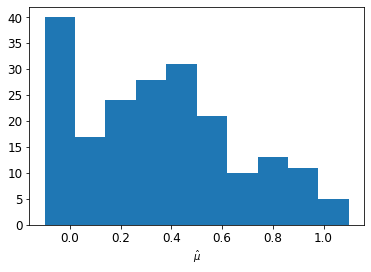

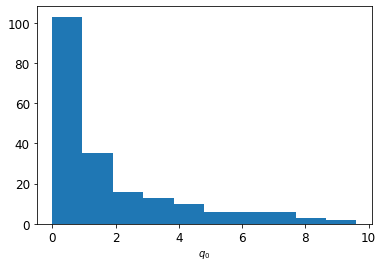

Z:0.9426124787592702
Z_std:1.1576841332261854
Z_1:1.566347059755486
Z_std_1:1.6902897709613893
8
AUC:0.9041266300857635
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

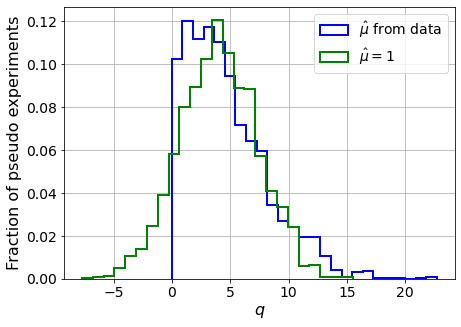

Z BL:(2.0024132231484053, 0.8631796819168751, 1.0324500000000003, 2.0040016967531056, 0.8319699280242856)


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  5957.21553689
  5726.10019088  5440.1129745   5082.92698293  4650.03889655
  4141.08383386  3552.21002915  2830.13637074  1931.53891672
   774.64739845  -718.68870201 -2570.25798326 -5243.98048509]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  4073.69570259  4073.54770292


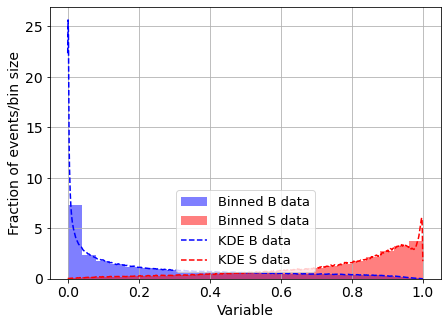

KDE Kernel:  epanechnikov
Background bandwidth:  0.0031053121543406503
Signal bandwidth:  0.0019008479046983867
This may take a while...
1 done
2 done
0.0060776031706688246
0.0060776031706688246
3 done
4 done
0.002611036691723898
0.002611036691723898
B_expected:  147986
S_expected:  202

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


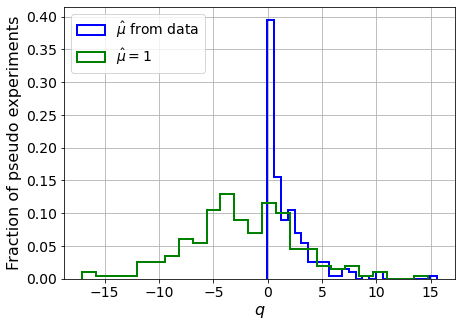

Z_MLL:  0.9717178744882006
std Z_MLL:  1.1480443109650602


  1%|▋                                                                   | 2/200 [00:01<02:52,  1.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4390807478787858
<p_{s}(Sdata)> = 1.9500220848563778
<p_{b}(Bdata)> = 4.540766785937583
<p_{s}(Bdata)> = 0.42175838098472884


  5%|███▎                                                               | 10/200 [00:10<02:56,  1.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4303453007160502
<p_{s}(Sdata)> = 1.8836643252788488
<p_{b}(Bdata)> = 4.5854645600807595
<p_{s}(Bdata)> = 0.4244379662624092


 18%|███████████▋                                                       | 35/200 [00:39<02:45,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.392332154799103
<p_{s}(Sdata)> = 2.0152759368240662
<p_{b}(Bdata)> = 4.5700422255956985
<p_{s}(Bdata)> = 0.424141111215796


 18%|████████████                                                       | 36/200 [00:39<02:14,  1.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4072537759741046
<p_{s}(Sdata)> = 2.1482872703419273
<p_{b}(Bdata)> = 4.560688300293166
<p_{s}(Bdata)> = 0.4228236480929241


 21%|██████████████                                                     | 42/200 [00:47<03:04,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.43527870889943054
<p_{s}(Sdata)> = 2.037997979907186
<p_{b}(Bdata)> = 4.564600843133225
<p_{s}(Bdata)> = 0.4209634559909063


 24%|███████████████▋                                                   | 47/200 [00:52<02:26,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44350448274696375
<p_{s}(Sdata)> = 1.9194316736948898
<p_{b}(Bdata)> = 4.559123062595772
<p_{s}(Bdata)> = 0.4224930232000892


 36%|███████████████████████▊                                           | 71/200 [01:21<02:10,  1.01s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4353603615549104
<p_{s}(Sdata)> = 1.9246710530242406
<p_{b}(Bdata)> = 4.588517814435312
<p_{s}(Bdata)> = 0.42221929055548474


 40%|██████████████████████████▊                                        | 80/200 [01:30<01:58,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45797013415868104
<p_{s}(Sdata)> = 1.8148200728181572
<p_{b}(Bdata)> = 4.553473952618766
<p_{s}(Bdata)> = 0.424106215373437


 46%|██████████████████████████████▊                                    | 92/200 [01:48<02:12,  1.22s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4004328514584026
<p_{s}(Sdata)> = 2.1128804262837346
<p_{b}(Bdata)> = 4.571166383530529
<p_{s}(Bdata)> = 0.42007249664819474


 50%|█████████████████████████████████                                 | 100/200 [01:57<01:30,  1.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42859509880647595
<p_{s}(Sdata)> = 1.9335678768968847
<p_{b}(Bdata)> = 4.562865416698662
<p_{s}(Bdata)> = 0.424579221709449


 52%|█████████████████████████████████▉                                | 103/200 [02:01<01:34,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42608244147270785
<p_{s}(Sdata)> = 1.9978185425543749
<p_{b}(Bdata)> = 4.572235567745669
<p_{s}(Bdata)> = 0.4222894615232597


 64%|██████████████████████████████████████████▏                       | 128/200 [02:33<01:19,  1.10s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.401125217231408
<p_{s}(Sdata)> = 2.081753891218008
<p_{b}(Bdata)> = 4.543906223145257
<p_{s}(Bdata)> = 0.422397348593911


 65%|██████████████████████████████████████████▉                       | 130/200 [02:34<00:59,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43407615062585003
<p_{s}(Sdata)> = 2.0225868677695544
<p_{b}(Bdata)> = 4.546922269977887
<p_{s}(Bdata)> = 0.421761316719757


 68%|█████████████████████████████████████████████▏                    | 137/200 [02:41<00:57,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4532929977394399
<p_{s}(Sdata)> = 1.8734254397956516
<p_{b}(Bdata)> = 4.552418822590462
<p_{s}(Bdata)> = 0.42374874984412264


 70%|██████████████████████████████████████████████▌                   | 141/200 [02:45<00:51,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4221585506998747
<p_{s}(Sdata)> = 1.9670664268718097
<p_{b}(Bdata)> = 4.539127727870038
<p_{s}(Bdata)> = 0.42252462234071586


 71%|██████████████████████████████████████████████▊                   | 142/200 [02:45<00:42,  1.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.358818935140988
<p_{s}(Sdata)> = 2.2082757022184825
<p_{b}(Bdata)> = 4.570681765599376
<p_{s}(Bdata)> = 0.4214251310401175


 74%|████████████████████████████████████████████████▌                 | 147/200 [02:51<00:48,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4098189649910996
<p_{s}(Sdata)> = 1.99833208008521
<p_{b}(Bdata)> = 4.554689395827524
<p_{s}(Bdata)> = 0.4225962545534621


 75%|█████████████████████████████████████████████████▌                | 150/200 [02:54<00:43,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42164222822846714
<p_{s}(Sdata)> = 2.0079814411056507
<p_{b}(Bdata)> = 4.557145656715136
<p_{s}(Bdata)> = 0.420599083654676


 76%|██████████████████████████████████████████████████▍               | 153/200 [02:57<00:43,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44604443963096657
<p_{s}(Sdata)> = 1.9721171835999156
<p_{b}(Bdata)> = 4.5767473289125995
<p_{s}(Bdata)> = 0.42189982547203697


 80%|█████████████████████████████████████████████████████▏            | 161/200 [03:05<00:33,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44887857469564085
<p_{s}(Sdata)> = 1.9361533285267318
<p_{b}(Bdata)> = 4.555149261427058
<p_{s}(Bdata)> = 0.4236810204762443


 82%|██████████████████████████████████████████████████████▍           | 165/200 [03:10<00:34,  1.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4460127358712644
<p_{s}(Sdata)> = 2.014416102688929
<p_{b}(Bdata)> = 4.602210202783554
<p_{s}(Bdata)> = 0.422915000509749


 89%|██████████████████████████████████████████████████████████▋       | 178/200 [03:25<00:22,  1.03s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.40364144671045393
<p_{s}(Sdata)> = 1.997178852722355
<p_{b}(Bdata)> = 4.595182586842042
<p_{s}(Bdata)> = 0.4210738761539967


 90%|███████████████████████████████████████████████████████████▋      | 181/200 [03:28<00:17,  1.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4248601676442233
<p_{s}(Sdata)> = 1.889938800686858
<p_{b}(Bdata)> = 4.521246125431913
<p_{s}(Bdata)> = 0.42483091401976475


 91%|████████████████████████████████████████████████████████████      | 182/200 [03:28<00:13,  1.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45840326473307064
<p_{s}(Sdata)> = 1.9443246824651466
<p_{b}(Bdata)> = 4.565386097270558
<p_{s}(Bdata)> = 0.4213861122393526


 92%|████████████████████████████████████████████████████████████▍     | 183/200 [03:29<00:11,  1.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4315258411771886
<p_{s}(Sdata)> = 1.9543526800388753
<p_{b}(Bdata)> = 4.590201330808225
<p_{s}(Bdata)> = 0.4210979830199522


 94%|█████████████████████████████████████████████████████████████▋    | 187/200 [03:34<00:13,  1.02s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4577048888653412
<p_{s}(Sdata)> = 1.969932837007857
<p_{b}(Bdata)> = 4.5734587634639015
<p_{s}(Bdata)> = 0.4210743488186974


 94%|██████████████████████████████████████████████████████████████    | 188/200 [03:34<00:09,  1.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4305841539127837
<p_{s}(Sdata)> = 1.9898550667775372
<p_{b}(Bdata)> = 4.582330415873863
<p_{s}(Bdata)> = 0.42150309989760354


 95%|██████████████████████████████████████████████████████████████▋   | 190/200 [03:37<00:09,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4264257806154509
<p_{s}(Sdata)> = 1.922196855223114
<p_{b}(Bdata)> = 4.542140656974626
<p_{s}(Bdata)> = 0.4216973855851469


 98%|████████████████████████████████████████████████████████████████▋ | 196/200 [03:41<00:02,  1.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4047186797659792
<p_{s}(Sdata)> = 1.96222525064679
<p_{b}(Bdata)> = 4.557116231499923
<p_{s}(Bdata)> = 0.4214420812455108


100%|██████████████████████████████████████████████████████████████████| 200/200 [03:45<00:00,  1.13s/it]


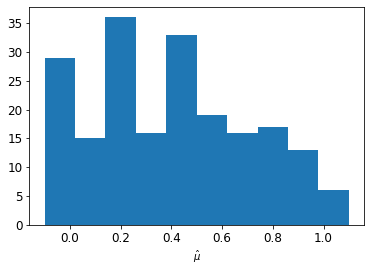

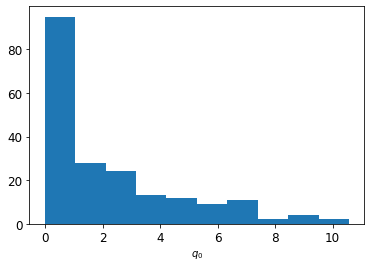

Z:1.1399490851651444
Z_std:1.080262570842807
Z_1:1.2803570146108696
Z_std_1:2.227591598365802
9
AUC:0.9055512551462513
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

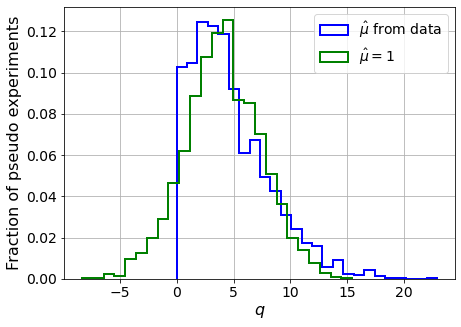

Z BL:(2.007802624775146, 0.862409371905461, 1.028375, 2.0096044711155496, 0.8383379314323192)


/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  6047.98360943
  5815.40913838  5517.71091438  5149.66895281  4716.08931939
  4206.98156223  3600.13344274  2868.40930807  1951.10163913
   779.55784898  -717.93946544 -2588.9848609  -5252.94096332]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  4142.16797562  4138.94691691


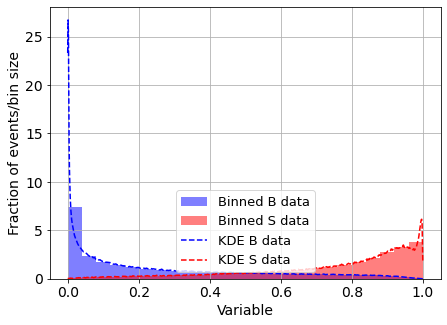

KDE Kernel:  epanechnikov
Background bandwidth:  0.0031053121543406503
Signal bandwidth:  0.0019008479046983867
This may take a while...
1 done
2 done
0.006251356439597446
0.006251356439597446
3 done
4 done
0.0035560428951527424
0.0035560428951527424
B_expected:  147986
S_expected:  202

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


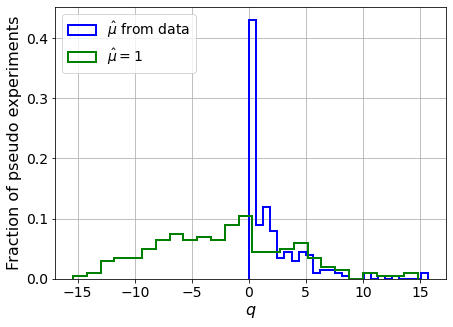

Z_MLL:  1.0637225458637976
std Z_MLL:  1.2994476558712595


  6%|████▎                                                              | 13/200 [00:15<03:06,  1.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4182198892850755
<p_{s}(Sdata)> = 1.9508989884083556
<p_{b}(Bdata)> = 4.783142688625995
<p_{s}(Bdata)> = 0.4157856716120377


 10%|██████▎                                                            | 19/200 [00:21<02:34,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45706131053754473
<p_{s}(Sdata)> = 2.041434091032899
<p_{b}(Bdata)> = 4.762475326169355
<p_{s}(Bdata)> = 0.420050782787031


 12%|████████▍                                                          | 25/200 [00:27<02:47,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48222478773674154
<p_{s}(Sdata)> = 1.8714898740454247
<p_{b}(Bdata)> = 4.7712384329037
<p_{s}(Bdata)> = 0.41920440543859616


 13%|████████▋                                                          | 26/200 [00:28<02:17,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3995274149707233
<p_{s}(Sdata)> = 2.0669764925621426
<p_{b}(Bdata)> = 4.807624926383584
<p_{s}(Bdata)> = 0.4174678071245905


 14%|█████████                                                          | 27/200 [00:28<01:56,  1.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38999116316653754
<p_{s}(Sdata)> = 2.0077987103129633
<p_{b}(Bdata)> = 4.753080272576246
<p_{s}(Bdata)> = 0.4188361477566429


 14%|█████████▋                                                         | 29/200 [00:30<02:12,  1.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47157338213173594
<p_{s}(Sdata)> = 1.8105081773782248
<p_{b}(Bdata)> = 4.817079305931537
<p_{s}(Bdata)> = 0.4176721799362605


 17%|███████████▍                                                       | 34/200 [00:35<02:11,  1.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4755391991377594
<p_{s}(Sdata)> = 1.9364423121148813
<p_{b}(Bdata)> = 4.776902753300588
<p_{s}(Bdata)> = 0.41723343878640173


 20%|█████████████                                                      | 39/200 [00:39<02:03,  1.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44967483948815246
<p_{s}(Sdata)> = 1.870542353528146
<p_{b}(Bdata)> = 4.800158026863409
<p_{s}(Bdata)> = 0.4190327342722738


 22%|██████████████▍                                                    | 43/200 [00:43<02:28,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4443287168926296
<p_{s}(Sdata)> = 1.9407568836880458
<p_{b}(Bdata)> = 4.750902383577093
<p_{s}(Bdata)> = 0.41879451166559184


 24%|████████████████                                                   | 48/200 [00:48<01:59,  1.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39392496599468524
<p_{s}(Sdata)> = 2.0813356376525896
<p_{b}(Bdata)> = 4.786233395334066
<p_{s}(Bdata)> = 0.4179812069658754


 26%|█████████████████                                                  | 51/200 [00:50<01:56,  1.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4166050836644463
<p_{s}(Sdata)> = 2.0123597724308007
<p_{b}(Bdata)> = 4.790907954283023
<p_{s}(Bdata)> = 0.4194810802122839


 28%|███████████████████                                                | 57/200 [00:56<02:01,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43215688807519975
<p_{s}(Sdata)> = 1.9752250572294856
<p_{b}(Bdata)> = 4.751584531074994
<p_{s}(Bdata)> = 0.4196739729972562


 30%|████████████████████▍                                              | 61/200 [01:00<01:59,  1.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4002087889553266
<p_{s}(Sdata)> = 2.0221466579275207
<p_{b}(Bdata)> = 4.811910726516302
<p_{s}(Bdata)> = 0.4180755912243984


 32%|█████████████████████                                              | 63/200 [01:02<01:43,  1.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42042428074073707
<p_{s}(Sdata)> = 2.1295419938811095
<p_{b}(Bdata)> = 4.799669745612644
<p_{s}(Bdata)> = 0.4167555501899551


 38%|█████████████████████████▍                                         | 76/200 [01:16<01:59,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48945652582026744
<p_{s}(Sdata)> = 1.8284805772580166
<p_{b}(Bdata)> = 4.74316015961128
<p_{s}(Bdata)> = 0.419932794614256


 41%|███████████████████████████▍                                       | 82/200 [01:23<01:49,  1.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4659116001328302
<p_{s}(Sdata)> = 2.106508659318713
<p_{b}(Bdata)> = 4.796357964902511
<p_{s}(Bdata)> = 0.4190999427015363


 43%|████████████████████████████▊                                      | 86/200 [01:27<01:49,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4027446484689419
<p_{s}(Sdata)> = 2.0202695459291244
<p_{b}(Bdata)> = 4.809857898505997
<p_{s}(Bdata)> = 0.4190515695806077


 46%|██████████████████████████████▊                                    | 92/200 [01:33<01:26,  1.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43635219322682883
<p_{s}(Sdata)> = 2.042215891080158
<p_{b}(Bdata)> = 4.7662132022782995
<p_{s}(Bdata)> = 0.41998523215059325


 46%|███████████████████████████████▏                                   | 93/200 [01:34<01:12,  1.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4187717843980045
<p_{s}(Sdata)> = 2.077746291174919
<p_{b}(Bdata)> = 4.75644054061777
<p_{s}(Bdata)> = 0.4187011547974354


 53%|██████████████████████████████████▉                               | 106/200 [01:48<01:19,  1.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39791351832222277
<p_{s}(Sdata)> = 2.0313952890963995
<p_{b}(Bdata)> = 4.781906986056281
<p_{s}(Bdata)> = 0.41777465204986103


 61%|████████████████████████████████████████▎                         | 122/200 [02:06<01:11,  1.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42066604360650023
<p_{s}(Sdata)> = 2.0328099942750653
<p_{b}(Bdata)> = 4.760859180123055
<p_{s}(Bdata)> = 0.4191519056991355


 68%|█████████████████████████████████████████████▏                    | 137/200 [02:25<01:08,  1.08s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4647581669273468
<p_{s}(Sdata)> = 1.9462278889775817
<p_{b}(Bdata)> = 4.755664141055589
<p_{s}(Bdata)> = 0.4189888770798255


 69%|█████████████████████████████████████████████▌                    | 138/200 [02:25<00:54,  1.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4222599916086912
<p_{s}(Sdata)> = 1.9064760390656463
<p_{b}(Bdata)> = 4.793429987046298
<p_{s}(Bdata)> = 0.4180195129275044


 82%|██████████████████████████████████████████████████████▍           | 165/200 [02:58<00:34,  1.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4123046248602668
<p_{s}(Sdata)> = 2.1090102996603233
<p_{b}(Bdata)> = 4.754012635893947
<p_{s}(Bdata)> = 0.4160815543048564


 86%|████████████████████████████████████████████████████████▍         | 171/200 [03:05<00:27,  1.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4770769266975087
<p_{s}(Sdata)> = 1.7983199747573901
<p_{b}(Bdata)> = 4.750902313679194
<p_{s}(Bdata)> = 0.41766357640836116


 88%|██████████████████████████████████████████████████████████▍       | 177/200 [03:12<00:26,  1.17s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.4753951767690011
<p_{s}(Sdata)> = 2.0039403380786163
<p_{b}(Bdata)> = 4.794728907005681
<p_{s}(Bdata)> = 0.41732377857387637


 89%|██████████████████████████████████████████████████████████▋       | 178/200 [03:13<00:20,  1.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44790829987416986
<p_{s}(Sdata)> = 1.9288165165837825
<p_{b}(Bdata)> = 4.778978099419675
<p_{s}(Bdata)> = 0.41878311016360303


100%|██████████████████████████████████████████████████████████████████| 200/200 [03:41<00:00,  1.11s/it]

muhat = -0.1
<p_{b}(Sdata)> = 0.40993212737468004
<p_{s}(Sdata)> = 1.8876784549914567
<p_{b}(Bdata)> = 4.805798646527575
<p_{s}(Bdata)> = 0.4179373594887351


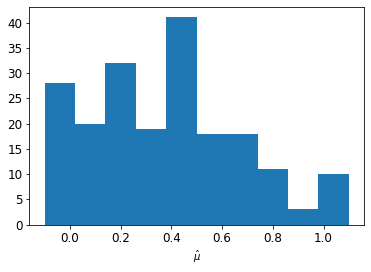

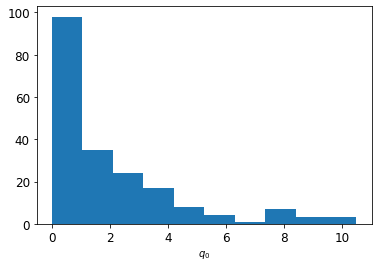

Z:1.0907673387698325
Z_std:1.0868717925071565
Z_1:1.4376513322864044
Z_std_1:1.830340793726081


<Figure size 432x288 with 0 Axes>

In [62]:
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)
num_pseudo = 2000
D_or_E = 'discovery'

Z_BL        = []

Z_MLL_code    = []
Z_MLL        = []
Z_MLL_std    = []
Z_MLL_mu     = []
Z_MLL_std_mu = []

auc_total   = []
auc_wgamma  = []
auc_wjets   = []
auc_ttgamma = []
for iloop in range(10):
    
    print(iloop)
    nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
    df = pd.DataFrame()


    #np.random.seed(28890)

    SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

    df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
    df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
    df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
    df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

    df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
    df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
    df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

    df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
    df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
    df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
    df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])
    df[lst[11]]= np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][:nobs,4]])

    df[lst[12]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
    df[lst[13]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

    df[lst[14]]= np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][:nobs,0]])
    df[lst[15]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])
    df[lst[16]]= np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][:nobs,2]])

    df[lst[17]]= np.concatenate([ST_SM[SM_indices], ST_NP[bp][:nobs]])
    df[lst[18]]= np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][:nobs]])
    #df[lst[19]]= np.concatenate([m_eff_SM[SM_indices], m_eff_NP[bp][:nobs]])

    df[lst[19]]= np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][:nobs]])
    df[lst[20]]= np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][:nobs]])
    df[lst[21]]= np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][:nobs]])


    df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

    df[lst[22]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

    df_array = np.asarray(df)
    
    df_test = pd.DataFrame()

    SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

    df_test[lst[0]]= np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][nobs:,0]])
    df_test[lst[1]]= np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][nobs:,1]])
    df_test[lst[2]]= np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][nobs:,2]])
    df_test[lst[3]]= np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][nobs:,3]])

    df_test[lst[4]]= np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][nobs:,0]])
    df_test[lst[5]]= np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][nobs:,1]])
    df_test[lst[6]]= np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][nobs:,2]])

    df_test[lst[7]]= np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][nobs:,0]])
    df_test[lst[8]]= np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][nobs:,1]])
    df_test[lst[9]]= np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][nobs:,2]])
    df_test[lst[10]]= np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][nobs:,3]])
    df_test[lst[11]]= np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][nobs:,4]])

    df_test[lst[12]]= np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][nobs:,0]])
    df_test[lst[13]]= np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][nobs:,2]])

    df_test[lst[14]]= np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][nobs:,0]])
    df_test[lst[15]]= np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][nobs:,1]])
    df_test[lst[16]]= np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][nobs:,2]])

    df_test[lst[17]]= np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][nobs:]])
    df_test[lst[18]]= np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][nobs:]])
    #df_test[lst[19]]= np.concatenate([m_eff_SM_pool[SM_indices], m_eff_NP[bp][nobs:]])

    df_test[lst[19]]= np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][nobs:]])
    df_test[lst[20]]= np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][nobs:]])
    df_test[lst[21]]= np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][nobs:]])


    df_test['bkg_flag_pool']= np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][nobs:]))) )

    df_test[lst[22]]= np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][nobs:]))])

    df_test_array = np.asarray(df_test)
    
    nobs = len(df_array)

    train_size = int(0.80 * nobs)
    val_size   = nobs - train_size #%- test_size 

    random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

    train_indices = random_indices[:train_size]
    val_indices   = random_indices[train_size:]
    
    
    X_train        = df_array[train_indices, :22]
    bkg_flag_train = df_array[train_indices, 22]
    y_mon_train    = df_array[train_indices, -1]

    X_test        = df_test_array[:, :22]
    bkg_flag_test = df_test_array[:, 22]
    y_mon_test    = df_test_array[:, -1]

    X_val        = df_array[val_indices, :22]
    bkg_flag_val = df_array[val_indices, 22]
    y_mon_val    = df_array[val_indices, -1]
    
    # to normalize
    x_scaler = preprocessing.MinMaxScaler()
    x_scaler = x_scaler.fit(X_train)

    X_mon_train = x_scaler.transform(X_train)
    X_mon_test  = x_scaler.transform(X_test)
    X_mon_val   = x_scaler.transform(X_val)
    
    
    # CLASSIFIER
    classifier = XGBClassifier(
        n_estimators  = 500,
        learning_rate = 0.1,
        reg_lambda    = 0.0, reg_alpha = 0.0,
        early_stopping_rounds = 50,#early stopping
        eval_metric = 'logloss',
        gamma = 0.0, objective = 'binary:logistic',
        max_depth = 5)

    # FIT
    classifier.fit(X_mon_train, y_mon_train, 
                   eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
                   verbose  = False)

    # PREDICTIONS
    y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

    pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
    pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]
    
    
    # Let's estimate the ROC Curve
    nvals = 50
    tpr_total   = np.zeros(nvals) 
    fpr_total   = np.zeros(nvals) 
    tpr_ttgamma = np.zeros(nvals) 
    fpr_ttgamma = np.zeros(nvals) 
    tpr_wgamma  = np.zeros(nvals) 
    fpr_wgamma  = np.zeros(nvals) 
    tpr_wjets   = np.zeros(nvals) 
    fpr_wjets   = np.zeros(nvals) 

    for ith, th in enumerate(np.linspace(0,1, nvals)):
        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_total[ith] = len(tp) / (len(tp) + len(fn))
        fpr_total[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_ttgamma.append( auc(fpr_ttgamma, tpr_ttgamma) )
    auc_wjets.append( auc(fpr_wjets, tpr_wjets) )
    auc_wgamma.append( auc(fpr_wgamma, tpr_wgamma) )
    auc_total.append( auc(fpr_total, tpr_total) )
    
    
    print('AUC:' + str(auc_total[iloop]))
    
    Z_BL.append( BL_test_fast('discovery', pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, 5, linear_bins=True) )

    print('Z BL:' + str(Z_BL[iloop]))
    
    kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                            50000, # Numero de datos para fitear
                                                                                            np.logspace(-4.0, 0.05, 20), 
                                                                                            set_kernel='epanechnikov')
    print('This may take a while...')

    pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
    print('1 done')
    pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
    print('2 done')

    # Normalize
    pB_B_data = pB_B_data / norm_factor_SM
    pS_B_data = pS_B_data / norm_factor_NP
    
    print(np.min(pB_B_data))
    pB_B_data[np.where(pB_B_data == 0 )[0]] = np.min(pB_B_data[np.where(pB_B_data > 0 )[0]])
    pS_B_data[np.where(pS_B_data == 0 )[0]] = np.min(pS_B_data[np.where(pS_B_data > 0 )[0]])
    print(np.min(pB_B_data))
    
    pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
    print('3 done')
    pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
    print('4 done')

    # Normalize
    pB_S_data = pB_S_data / norm_factor_SM
    pS_S_data = pS_S_data / norm_factor_NP
    
    print(np.min(pB_S_data))
    pB_S_data[np.where(pB_S_data == 0 )[0]] = np.min(pB_S_data[np.where(pB_S_data > 0 )[0]])
    pS_S_data[np.where(pS_S_data == 0 )[0]] = np.min(pS_S_data[np.where(pS_S_data > 0 )[0]])
    print(np.min(pB_S_data))
    
    print('B_expected: ', int(B_expected))
    print('S_expected: ', int(S_expected[bp]))
    print('')

    Z_MLL_code.append( MLL_test_fast(D_or_E, pB_B_data, pS_B_data, pB_S_data, 
                          pS_S_data, B_expected, int(S_expected[bp]), num_pseudo = 200) )
    print('Z_MLL: ', Z_MLL_code[iloop][0])
    print('std Z_MLL: ', Z_MLL_code[iloop][1])
    
    # indeces (to later build a random pseudo experiment)
    indices_B = [i for i in range(len(pS_B_data))]
    indices_S = [i for i in range(len(pS_S_data))]
    # loop over the number of pseudo experiments
    #np.random.seed(91218)

    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(200)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )



    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )
    
    try:
        plt.hist(np.asarray(muhat_selected_MLL_list))
        plt.xlabel(r'$\hat{\mu}$')
        plt.savefig('../graph/BP' + str(bp+1) + '/muhat_hist_' + str(iloop) + '.pdf')
        plt.show()
        plt.clf()

        plt.hist(np.asarray(q_muhat_MLL))
        plt.xlabel(r'$q_{0}$')
        plt.savefig('../graph/BP' + str(bp+1) + '/q0_hist_' + str(iloop) + '.pdf')
        plt.show()
        plt.clf()
    except:
        pass
    print('Z:' + str(Z_MLL[iloop]))
    print('Z_std:' + str(Z_MLL_std[iloop]))
    print('Z_1:' + str(Z_MLL_mu[iloop]))
    print('Z_std_1:' + str(Z_MLL_std_mu[iloop]))

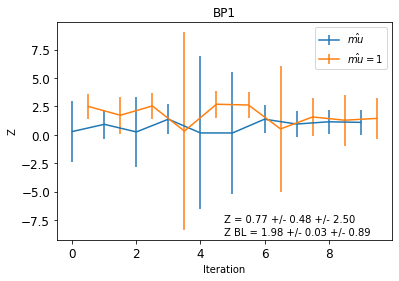

In [63]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.text(0.5,0.08, 'Z = ' + '{:.2f}'.format(np.mean(np.asarray(Z_MLL))) + ' +/- ' + 
         '{:.2f}'.format(np.std(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.mean(np.nan_to_num(Z_MLL_std, nan=0, posinf=0, neginf=0))),
         transform = plt.gca().transAxes)
plt.text(0.5,0.02, 'Z BL = ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,0])) + ' +/- ' + 
         '{:.2f}'.format(np.std(np.asarray(Z_BL)[:,0])) + ' +/- ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,1])), transform = plt.gca().transAxes)
plt.title('BP' + str(bp+1))
plt.xlabel('Iteration')
plt.savefig('../graph/loopBP' + str(bp+1) + '_50000_MLLvariable_new2.pdf')

In [64]:
print('Z = ' + '{:.2f}'.format(np.mean(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.std(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.mean(np.nan_to_num(Z_MLL_std, nan=0, posinf=0, neginf=0))))
print('Z BL = ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,0])) + ' +/- ' + '{:.2f}'.format(np.std(np.asarray(Z_BL)[:,0]))  + ' +/- ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,1])) )

Z = 0.77 +/- 0.48 +/- 2.50
Z BL = 1.98 +/- 0.03 +/- 0.89


In [71]:
np.asarray(Z_MLL_code)[:,0]

0.8185899221196709

In [67]:
Z_MLL

[0.28390059798180467,
 0.9183105048030975,
 0.24904484599332513,
 1.370160223411963,
 0.15871081179206065,
 0.15822101619794582,
 1.3699961126628328,
 0.9426124787592702,
 1.1399490851651444,
 1.0907673387698325]

In [65]:
Z_MLL_std

[2.7132660094149856,
 1.280614391655558,
 3.0909624315420317,
 1.307305028906257,
 6.728571800080259,
 5.330281495890611,
 1.209364244440926,
 1.1576841332261854,
 1.080262570842807,
 1.0868717925071565]

In [66]:
print('AUC : ' + str(np.mean(np.asarray(auc_total))) + ' +/- ' + str(np.std(np.asarray(auc_total))))

AUC : 0.904668479986146 +/- 0.0006160255840975816
